In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import specgram
from scipy.io import wavfile
from skimage.feature import peak_local_max
import librosa
import pydub

In [12]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [13]:
path = 'C:\\Users\\pizza\\Google Drive\\1_Break_Spots\\'

In [14]:
# In contrast to `librosa`, `pydub` reads the data as dtype 'int16', resulting in `2^16 * librosa = pydub`. 
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

In [15]:
def identify_peaks(im, *args, **kwargs):
    # Encapsulate this fulctionality for possible replacements of the function that generates `coordinates`.
    coordinates = peak_local_max(im, *args, **kwargs)
    
    time_coordinates = coordinates[:, 1]
    freq_coordinates = coordinates[:, 0]
    
    time_sort_ind = np.argsort(time_coordinates)
    
    return (freq_coordinates[time_sort_ind],
            time_coordinates[time_sort_ind])

In [16]:
# This function returns a booleans mask, which defines the target zone.
def define_target_zone(dt):
    
    tz_start = 0
    
    tz_end_type = 'count'
    tz_end = 300
    
    max_tz_length = 10
    
    # 1. Define the starting point of the target zone (and also include all consecutive points).
    target_zone = (dt > tz_start)
    
    # 2. Define the ending point of the target zone.
    # If `tz_end_type` equals 'count', the number of points in the zone is considered rather than the time.
    if tz_end_type == 'count':
        # Sum per column and take only those points where the sum is within the limit of `tz_end`.
        target_zone = target_zone & (np.cumsum(target_zone, axis = 0) <= tz_end)
        
        # Nonetheless apply a upper contraint for the time to keep the target zone resonably sized.
        target_zone = target_zone & (dt <= tz_start + max_tz_length)
    else:
        target_zone = target_zone & (dt <= tz_end)
        
    # 3. Apply lower and upper bounds for the frequency range of the target zone.
    #TODO:
    
    return target_zone

In [17]:
def extract_pairs(im, freqs, t, *args, **kwargs):
    freq_coords, time_coords = identify_peaks(im, *args, **kwargs)
    
    # Explicitly reshape `freqs` and `t` to make them column vectors.
    freqs = np.reshape(freqs[freq_coords], (-1, 1))
    t = np.reshape(t[time_coords], (-1, 1))
    
    # Calculate `dt` 
    # The first row of `dt` has elements t[0] - t[0], t[0] - t[1], t[0] - t[2], ...
    # The first column of `dt` stores all (positve, i.e. forward looking) Δt with reference to t[0].
    dt = t - t.T
    
    target_zone = define_target_zone(dt)

    # Convert `target_zone` to int to be able to use NaNs.
    target_zone = target_zone.astype(float)
    # Set all values in the target zone mask to NaN that are not within the respective target zone.
    target_zone[target_zone == 0] = np.nan
    
    # Transpose `freqs` and `t` such that they become row vectors and each column (which only has one element) is related to the columns of `dt`.
    f_anchor = freqs.T * target_zone
    t_anchor = t.T * target_zone
    f_2 = freqs * target_zone
    dt = dt * target_zone
    
    return np.stack((f_anchor, f_2, dt, t_anchor), axis=2)

In [18]:
def extract_coord_pairs(im, freqs, t, *args, **kwargs):
    freq_coords, time_coords = identify_peaks(im, *args, **kwargs)
    
    # Explicitly reshape `freqs` and `t` to make them column vectors.
    freq_inds = np.reshape(freq_coords, (-1, 1))
    t_inds = np.reshape(time_coords, (-1, 1))
    
    # Calculate `dt` 
    # The first row of `dt` has elements t[0] - t[0], t[0] - t[1], t[0] - t[2], ...
    # The first column of `dt` stores all (positve, i.e. forward looking) Δt with reference to t[0].
    dt = t_inds - t_inds.T
    
    # Note that here the actaul time values are used and not the indices.
    target_zone = define_target_zone(np.reshape(t[time_coords], (-1, 1)) - np.reshape(t[time_coords], (-1, 1)).T)
    #target_zone = define_target_zone(dt)
    
    # Convert `target_zone` to int to be able to use NaNs.
    target_zone = target_zone.astype(float)
    # Set all values in the target zone mask to NaN that are not within the respective target zone.
    target_zone[target_zone == 0] = np.nan
    
    # Transpose `f_anchor` and `t_anchor` such that they become row vectors and each column (which only has one element) is related to the columns of `dt`.
    f_anchor = freq_inds.T * target_zone
    t_anchor = t_inds.T * target_zone
    f_2 = freq_inds * target_zone
    dt = dt * target_zone
    
    return np.stack((f_anchor, f_2, dt, t_anchor), axis=2)

In [19]:
def condense_coords(coord_pairs):
    # Create a four-dimensional column vector 
    coord_pairs_rs = np.reshape(coord_pairs, (-1, 4), order='F')

    nans_per_row = np.isnan(coord_pairs_rs).sum(axis=1)
    # Remove all row that contain at least one NaN (i.e. only keep those where `nans_per row` equals 0)
    coord_pairs_rs = coord_pairs_rs[nans_per_row == 0, :]
    
    return coord_pairs_rs

In [20]:
def hash_by_sobot(coordinates):
    # For the operations to follow the dtype needs to be integer.
    try:
        coordinates = coordinates.astype('int32')
    except ValueError:
        return np.nan
    
    hash_value = (coordinates[:, 2] & 0x0000FFFF) | ((coordinates[:, 1] & 0x000000FF) << 16) | ((coordinates[:, 0] & 0x000000FF) << 24)
    return (hash_value, coordinates[:, 3])

In [21]:
def hash_by_late(coordinates):
    # For the operations to follow the dtype needs to be integer.
    try:
        coordinates = coordinates.astype('int32')
    except ValueError:
        return np.nan
               # 1-8 Bit for dt                    # 9-20 Bit for f_2                         # 21-32 Bit for f_anchor 
    hash_value = (coordinates[:, 2] & 0x000000FF) | ((coordinates[:, 1] & 0x00000FFF) << 8) | ((coordinates[:, 0] & 0x00000FFF) << 20)
    return (hash_value, coordinates[:, 3])

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def get_lines(y_val, color=None):
    x_val = np.arange(len(y_val))
    
    # Create the x and y points and shape it approriately.
    points = np.array([x_val, y_val]).T.reshape(-1, 1, 2)
   # print(points)
    # Take the start and end points (x,y) of each individual segment and stack along the 2nd axis.
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    if color is None:
        color = y_val
    
    norm = plt.Normalize(color.min(), color.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(color)
    lc.set_linewidth(2)
        
    return lc

In [74]:
# Returns a tuple of arrays.
def spec2hash(im, freqs, t, *args, **kwargs):
    # Extract the coordinate pairs (each coordinate is a 2-D Matrix)
    coord_pairs = extract_coord_pairs(im, freqs, t, *args, **kwargs)
    
    # Condense the coordinates to remove the NaN values (each coordinate is now a 1-D column vector)
    condensed_coords = condense_coords(coord_pairs)
    
#     f_anchor =  condensed_coords[:, 0]
#     f_2 = condensed_coords[:, 1]
#     dt = condensed_coords[:, 2]
    
    
#     fig, ax = plt.subplots(1, 3, figsize=(30, 5))
#     ax = ax.ravel()
    
#     line = ax[0].add_collection(get_lines(f_anchor, color=f_anchor))
#     cb = plt.colorbar(mappable=line, ax=ax[0])
#     cb.set_label(r'Index of $f_{Anchor}$')
#     ax[0].set_title(r'$f_{Anchor}$')
#     ax[0].set_xlim(0, len(f_anchor))
#     ax[0].set_ylim(f_anchor.min() - (f_anchor.max() - f_anchor.min()) * .2, f_anchor.max() + (f_anchor.max() - f_anchor.min()) * .2)
    
#     line = ax[1].add_collection(get_lines(f_2, color=f_anchor))
#     cb = plt.colorbar(mappable=line, ax=ax[1])
#     cb.set_label(r'Index of $f_{Anchor}$')
#     ax[1].set_title(r'$f_{2}$')
#     ax[1].set_xlim(0, len(f_2))
#     ax[1].set_ylim(f_2.min() - (f_2.max() - f_2.min()) * .2,  f_2.max() + (f_2.max() - f_2.min()) * .2)
    
#     line = ax[2].add_collection(get_lines(dt, color=f_anchor))
#     cb = plt.colorbar(mappable=line, ax=ax[2])
#     cb.set_label(r'Index of $f_{Anchor}$')
#     ax[2].set_title(r'$dt$')
#     ax[2].set_xlim(0, len(dt))
#     ax[2].set_ylim(dt.min() - (dt.max() - dt.min()) * .2, dt.max() +  (dt.max() - dt.min()) * .2)
    
    # Apply the hash function
    return hash_by_sobot(condensed_coords)
    #return hash_by_late(condensed_coords)

In [24]:
# Returns a list of tuples.
def windowed_hash(im, freqs, t, window_length=None, window_overlap=None, *args, **kwargs):
       
    if window_length is None:
        window_length = len(t) / 10
        
    if type(window_length) is not int:
        window_length = int(window_length)
        
    if window_overlap is None:
        window_overlap = window_length / 2
        
    if type(window_overlap) is not int:
        window_overlap = int(window_overlap)
    
    # The last window should be at least 'window_overlap' from the end point.
    start_inds = np.arange(0, len(t) - window_overlap, window_overlap)
    
    hash_vals = [np.nan] * len(start_inds)
    
    for i, start_ind in enumerate(start_inds):
        # Note that x[i:j] does not include the j-th element. 
        end_ind = min(len(t), start_ind + window_length)
        
        hash_vals[i] = spec2hash(im[:, start_ind:end_ind], freqs, t[start_ind:end_ind], *args, **kwargs)
        
        plot_im = np.copy(im)
        plot_im[:, :start_ind] = np.nan
        plot_im[:, end_ind + 1:] = np.nan
        plt.figure(figsize=(40,5))
        freq_ind, time_ind = identify_peaks(plot_im, *args, **kwargs)
        pcon = plt.contourf(plot_im)
        plt.scatter(time_ind, freq_ind, s=2, color='r')
        plt.colorbar(mappable=pcon)
        plt.title('Window {0:d} with {1:d} peaks'.format(i, len(freq_ind)))
        plt.show()
        
    return hash_vals

In [25]:
def check_matches(ground_truth, stream_spec, stream_freq, stream_t, window_length=None, window_overlap=None, *args, **kwargs):
    windowed_hash_vals = windowed_hash(stream_spec, stream_freq, stream_t, window_length, window_overlap, *args, **kwargs)
    
    score = np.empty(len(windowed_hash_vals))
    # Get a boolean array, where the hashes of the window equal one of the hashes in ground truth
    for i, window in enumerate(windowed_hash_vals):
        

        print(len(window[0]))
        print(np.in1d(window[0], ground_truth[0]).sum())
        print([bin(hash) for hash in window[0][np.in1d(window[0], ground_truth[0])]])
        score[i] = (np.in1d(window[0], ground_truth[0]).sum())/len(window[0])
        
    return score    

In [26]:
window = np.array([3, 4, 5])
ALDI_spot = np.arange(10)
np.in1d(window, ALDI_spot).sum()/len(window)

1.0

In [27]:
full_block, rate = librosa.load(path + '20201030-075500.mp3', sr = 44100, mono=True)
ALDI, _ = librosa.load(path + 'ALDI_20s.mp3', sr = 44100, mono=True)

C:\Users\pizza\miniconda3\envs\Application_Project\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [75]:
# The spectrograms have dimensions of frequency-by-time.
#full_spec, freq, full_t = specgram(np.hstack((np.zeros(1269784), ALDI, np.zeros(8979152))) , NFFT=4096, Fs=rate, noverlap=2048)
full_spec, freq, full_t = specgram(full_block, NFFT=256, Fs=rate, noverlap=128)
ALDI_spec, freq, ALDI_t = specgram(ALDI, NFFT=256, Fs=rate, noverlap=128)

# Set zero values to small values so `np.log10` works.
full_spec[full_spec == 0] = 1e-6
ALDI_spec[ALDI_spec == 0] = 1e-6

In [76]:
full_spec_dB = 10.0 * np.log10(full_spec)
ALDI_spec_dB = 10.0 * np.log10(ALDI_spec)

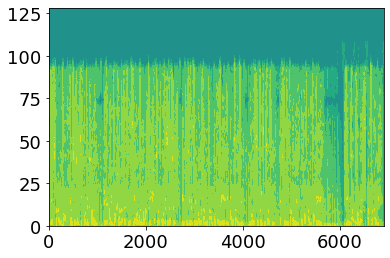

In [77]:
plt.contourf(ALDI_spec_dB)

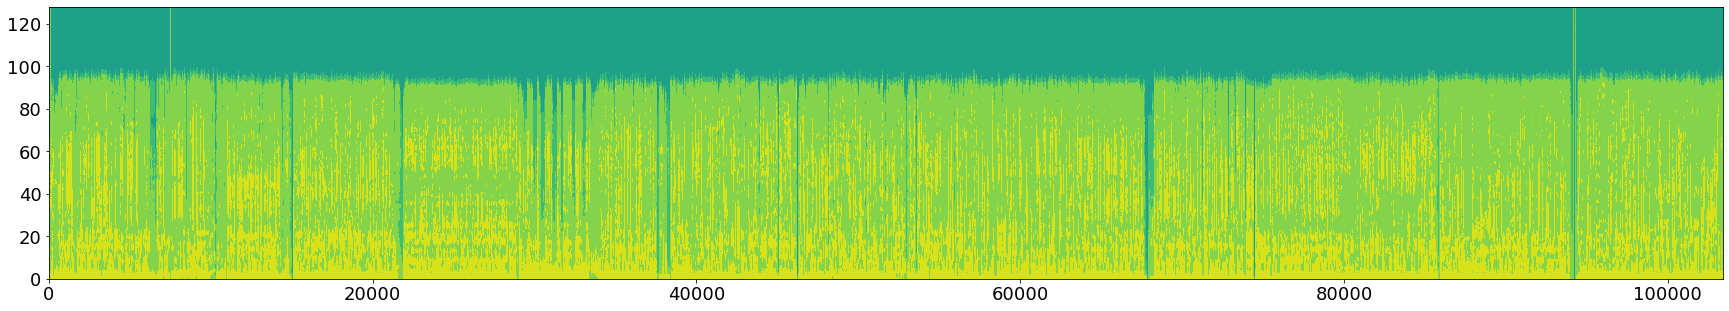

In [78]:
plt.figure(figsize=(30,5))
plt.contourf(full_spec_dB)

In [88]:
ALDI_hash = spec2hash(ALDI_spec_dB, freq, ALDI_t, min_distance=20, threshold_abs=-60)

In [89]:
ALDI_hash[0].shape

(1140,)

In [86]:
full_hash = spec2hash(full_spec_dB, freq, full_t, min_distance=20, threshold_abs=-60)

In [87]:
full_hash[0].shape

(68168,)

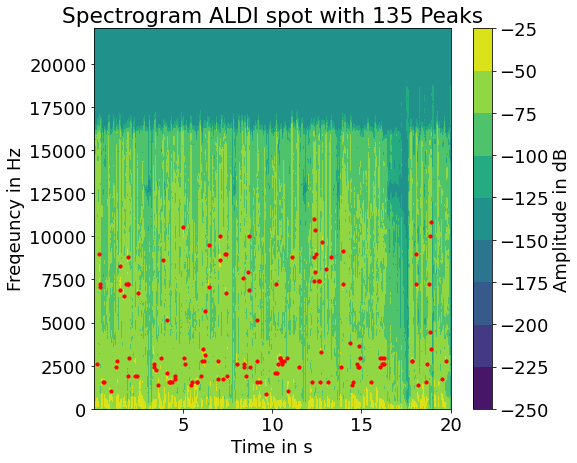

In [83]:
plt.figure(figsize = (8,7))
con = plt.contourf(ALDI_t, freq, ALDI_spec_dB)
## Get the peaks
freq_ind, time_ind = identify_peaks(ALDI_spec_dB, min_distance=5, threshold_abs=-50)
plt.scatter(ALDI_t[time_ind], freq[freq_ind], s=10, color='r')
plt.xlabel('Time in s')
plt.ylabel('Freqeuncy in Hz')
plt.title('Spectrogram ALDI spot with {0:d} Peaks'.format(len(time_ind)))
cb = plt.colorbar(mappable=con)
cb.set_label('Amplitude in dB')

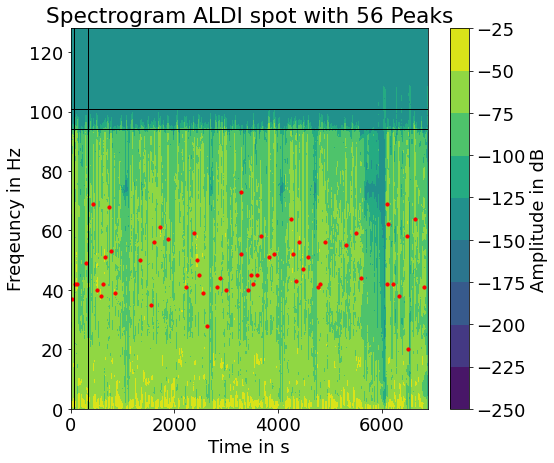

In [85]:
plt.figure(figsize = (8,7))
con = plt.contourf(ALDI_spec_dB)
## Get the peaks
freq_ind, time_ind = identify_peaks(ALDI_spec_dB, min_distance=20, threshold_abs=-60)
plt.scatter(time_ind, freq_ind, s=10, color='r')
plt.axhline(y=94, linewidth=1, color='k')
plt.axhline(y=101, linewidth=1, color='k')
plt.axvline(x=58, linewidth=1, color='k')
plt.axvline(x=327, linewidth=1, color='k')

plt.xlabel('Time in s')
plt.ylabel('Freqeuncy in Hz')
plt.title('Spectrogram ALDI spot with {0:d} Peaks'.format(len(time_ind)))
cb = plt.colorbar(mappable=con)
cb.set_label('Amplitude in dB')

In [8]:
0b1011110

94

In [54]:
0b000001100101

101

In [56]:
0b00001101

13

In [ ]:
101111000000110010

In [64]:
f_anchor = freq_ind[0]
f_2 = freq_ind[2]

In [67]:
time_ind[2] - time_ind[0]

269

In [71]:
ALDI_spec_dB.shape

(257, 3446)

In [73]:
len(bin(1723)) - 2

11

In [66]:
f_2

101

In [52]:
ALDI_hash[0]

array([ 98587079,  98592013,  98592099,  98596133,  98596467,  98591623,
        98592961,  98588517,  98588213,  84960582,  84960668,  84964702,
        84965036,  84960192,  84961530,  84957086,  84956782,  84961146,
       105932118, 105936152, 105936486, 105931642, 105932980, 105928536,
       105928232, 105932596, 105936322, 105936400, 105931556, 105932894,
       105928450, 105928402, 105932766, 105933506, 105934849, 122713678,
       122708834, 122710172, 122705728, 122705424, 122709788, 122710528,
       122712127, 122704388, 123757332, 123758670, 123754482, 123754178,
       123758542, 123759282, 123760881, 123753142, 123762608, 103835706,
       103831518, 103831214, 103835578, 103836318, 103837917, 103830178,
       103839644, 103835905, 109074340, 109074036, 109078400, 109079140,
       109080739, 109073000, 109082466, 109078983,  91248336,  91252700,
        91253440,  91255039,  91247300,  91256766,  91253027,  90203916,
        90204912,  90206255,  90198772,  90208238, 

In [53]:
0b101111000000110010100001101

98592013

In [4]:
hashvals = ['0b101111000000110010100001101', '0b101111000000111010100100101', '0b110010100000111010100011000', '0b110010100000110100001011110']

In [63]:
[(x[2:-20], x[-20:-9], x[-9:]) for x in hashvals]

[('1011110', '00000110010', '100001101'),
 ('1011110', '00000111010', '100100101'),
 ('1100101', '00000111010', '100011000'),
 ('1100101', '00000110100', '001011110')]

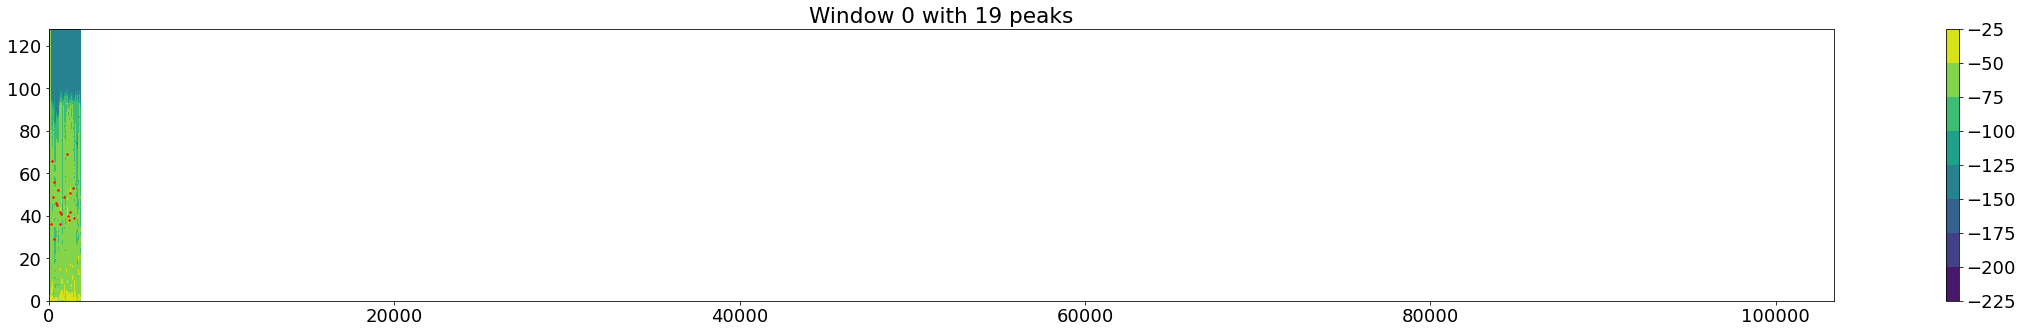

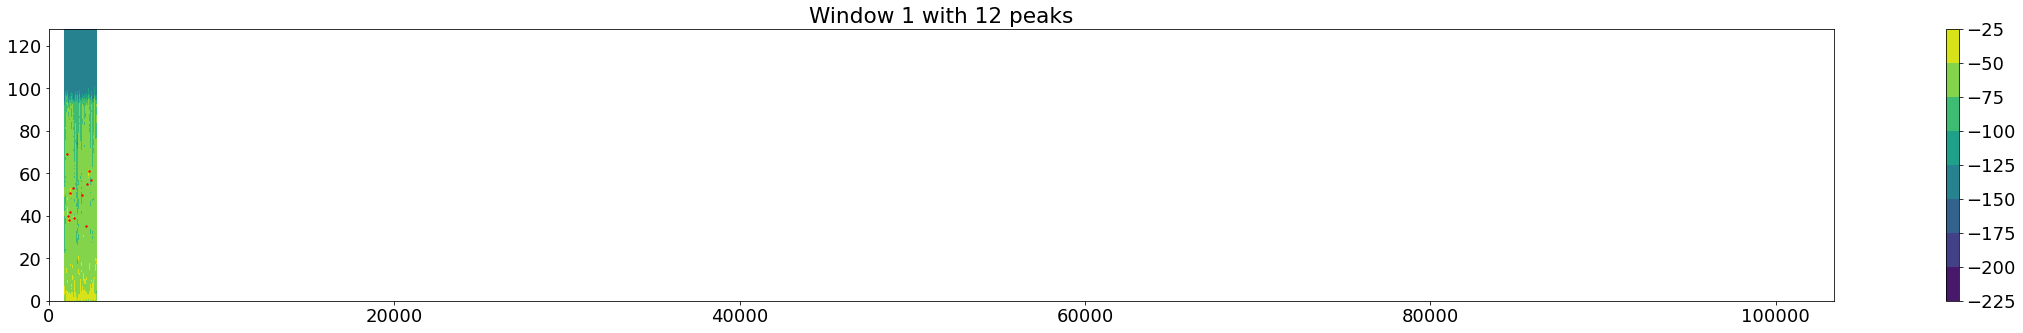

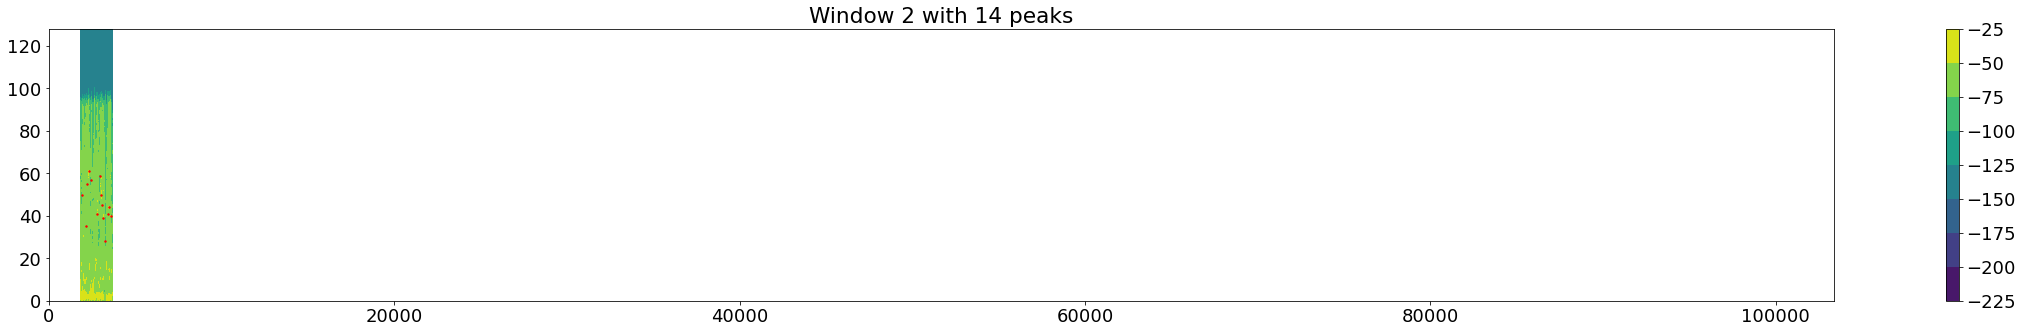

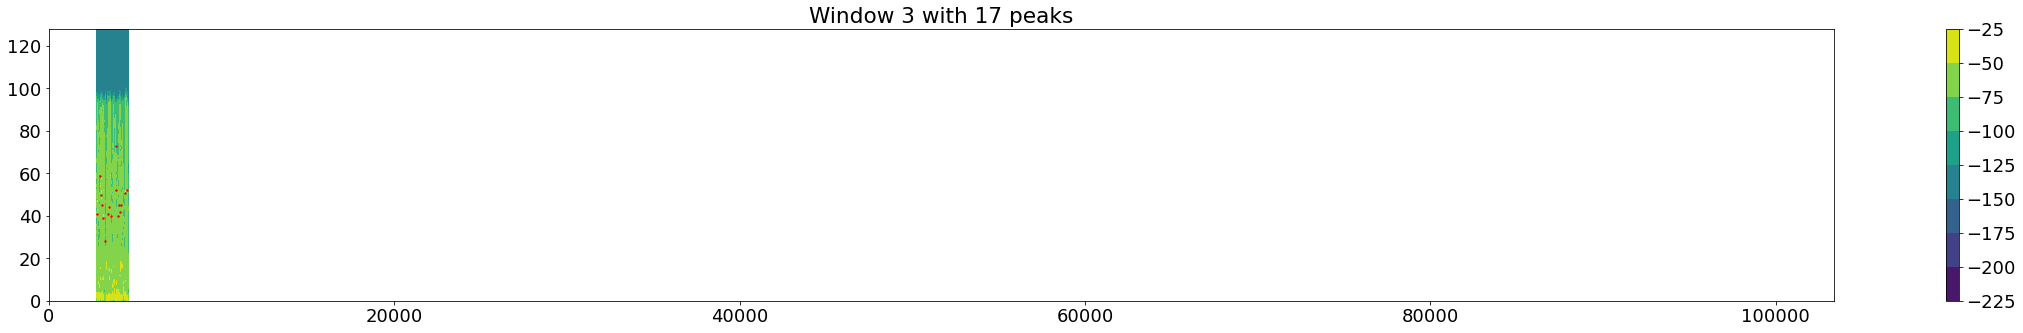

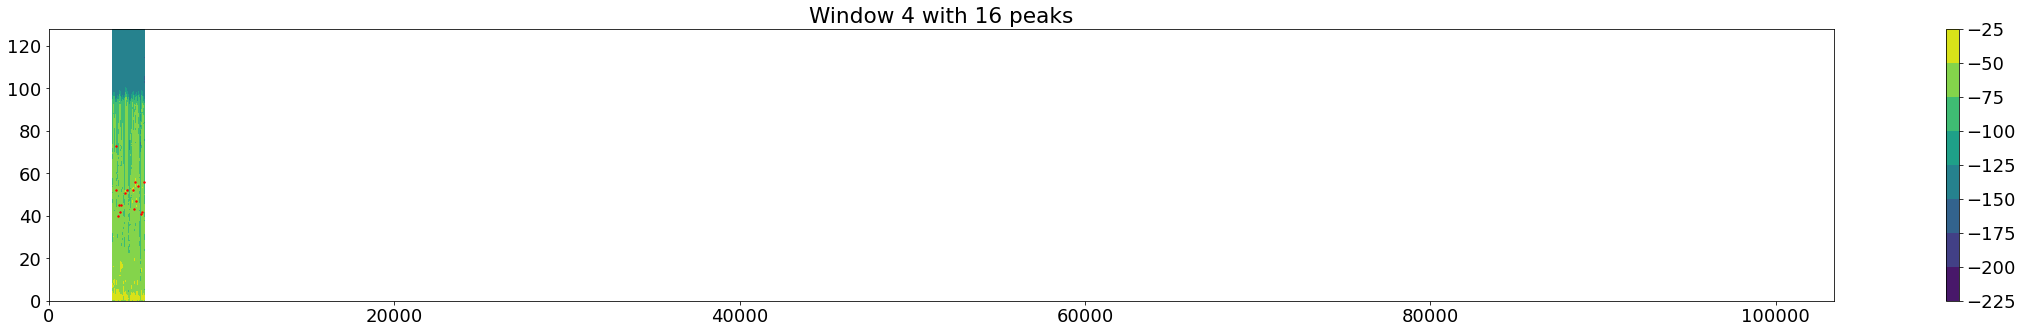

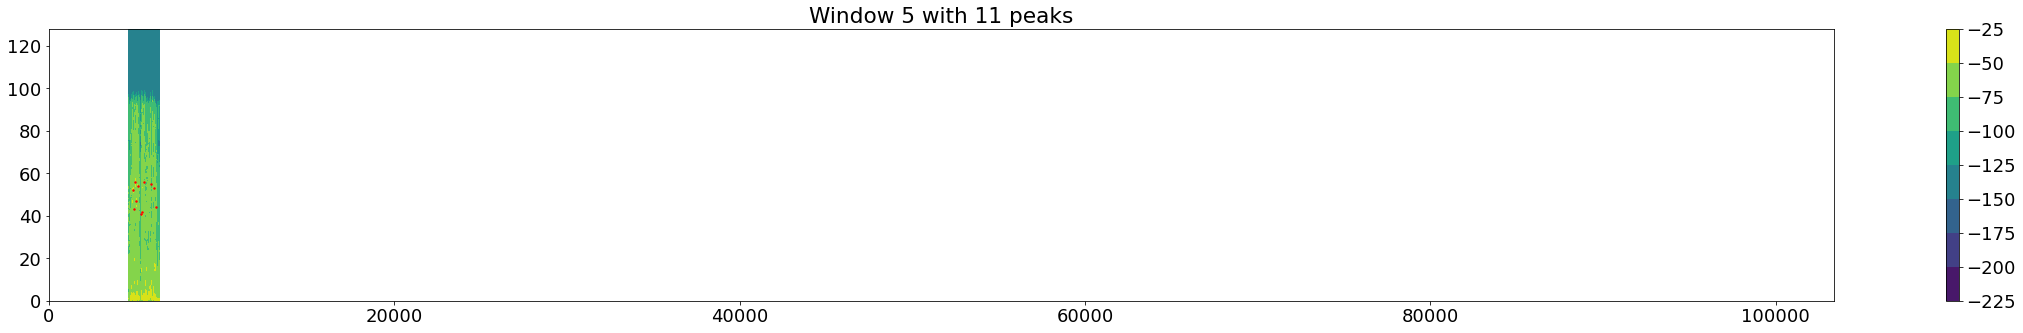

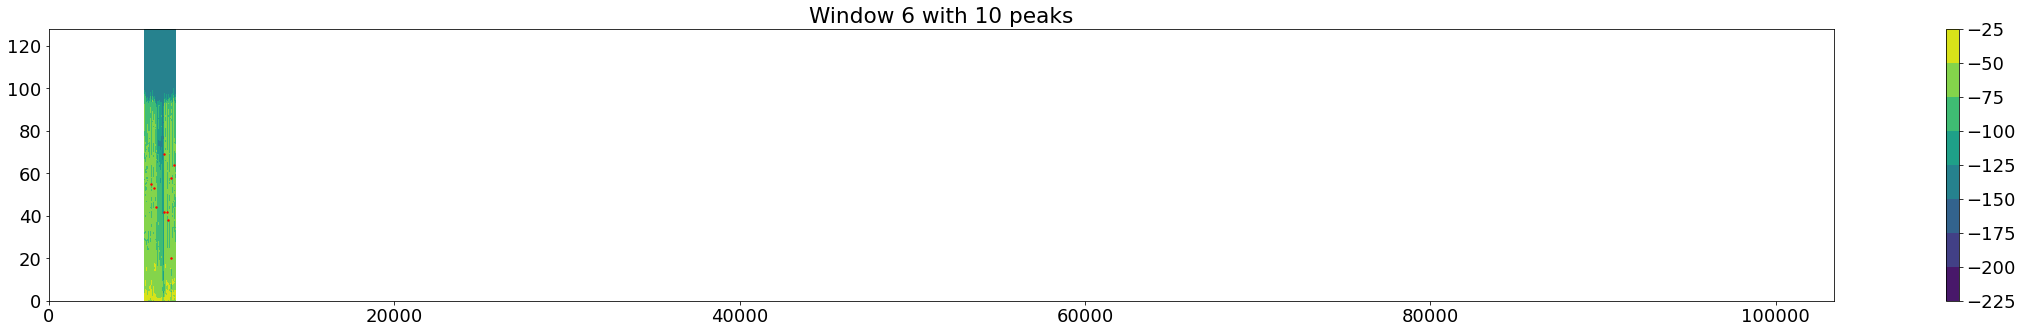

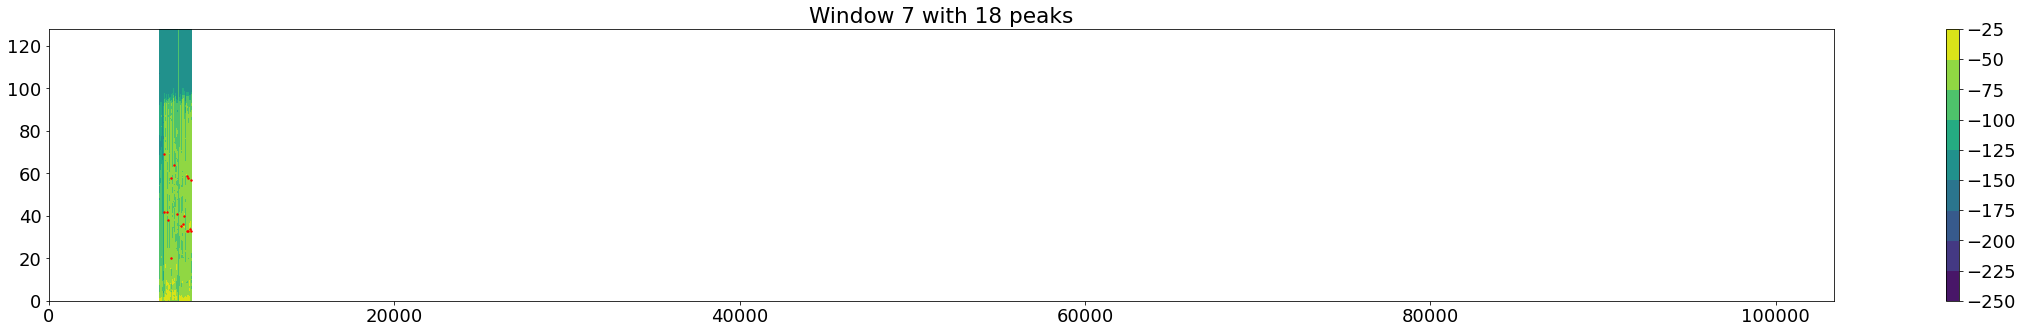

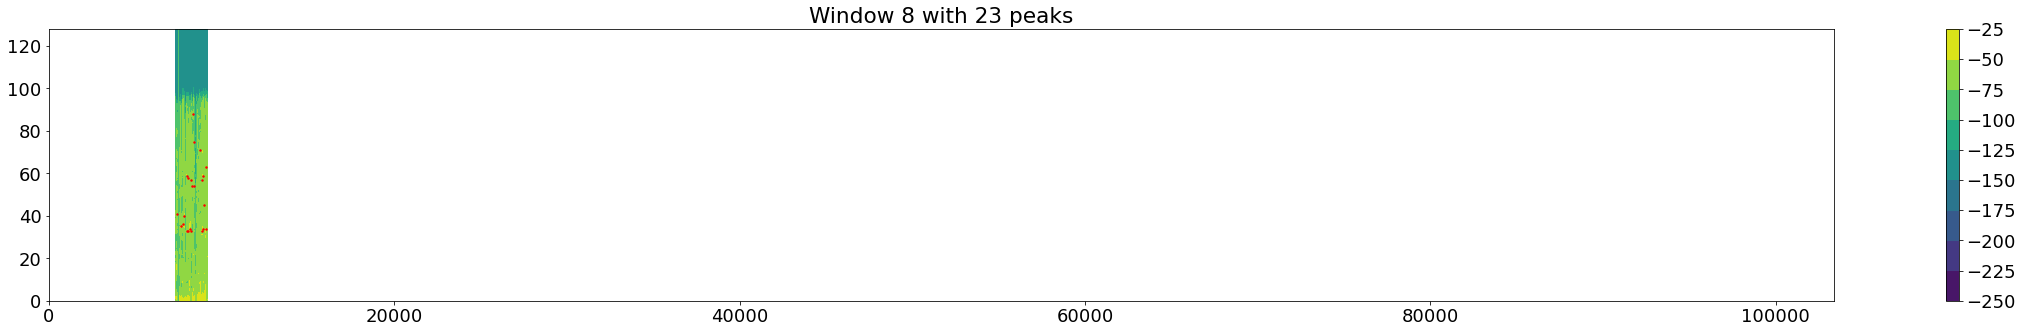

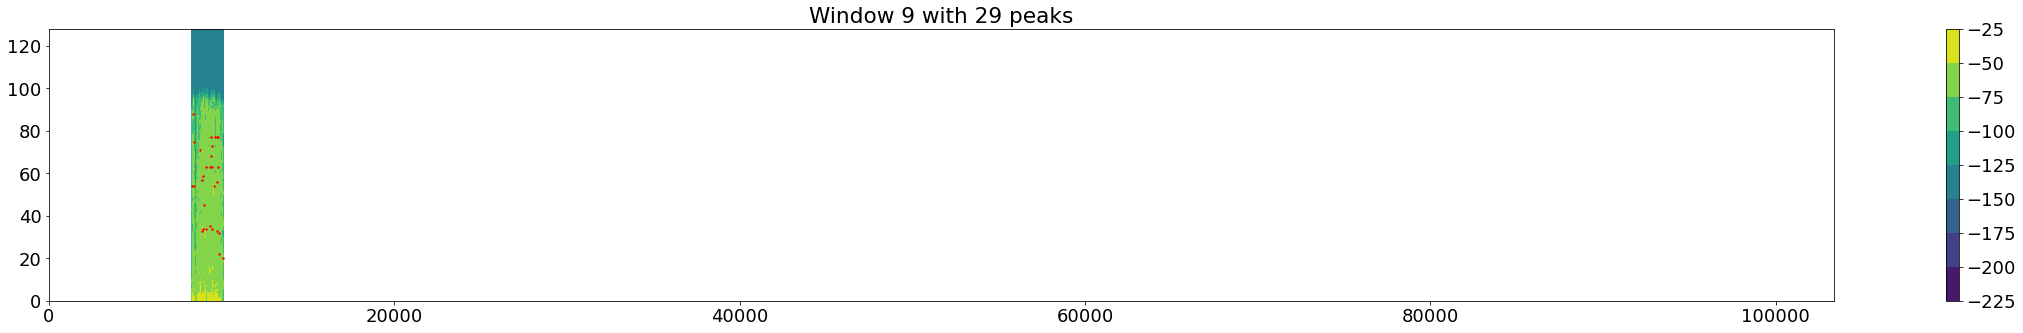

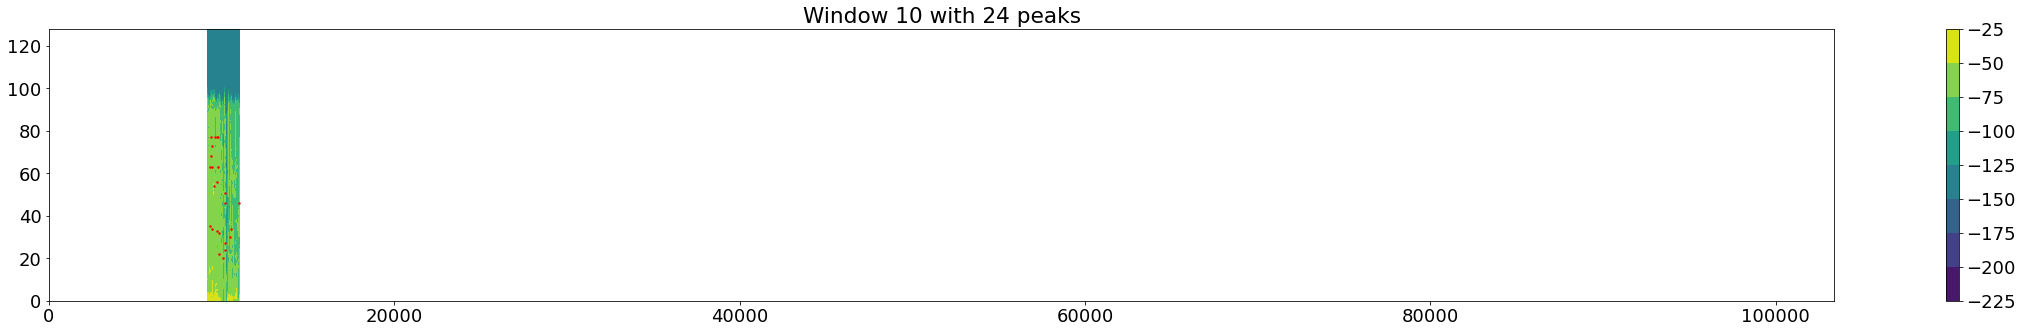

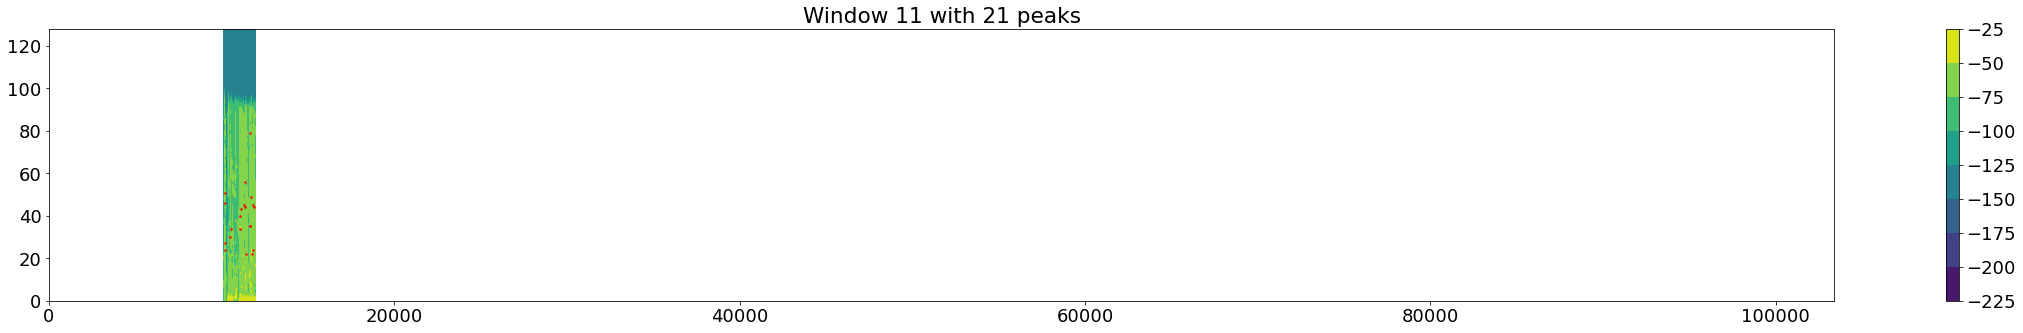

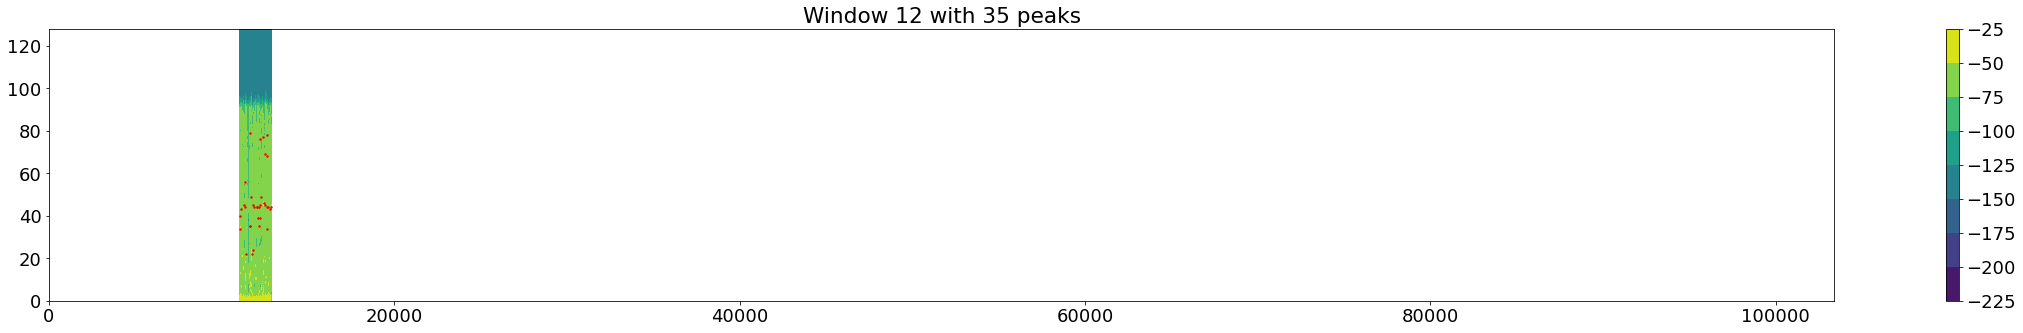

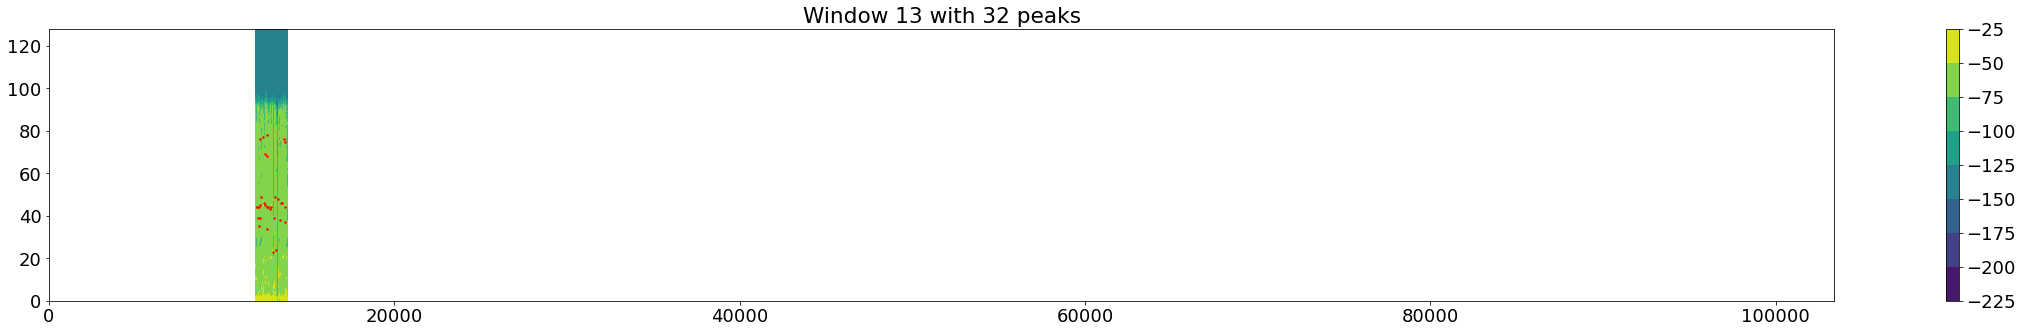

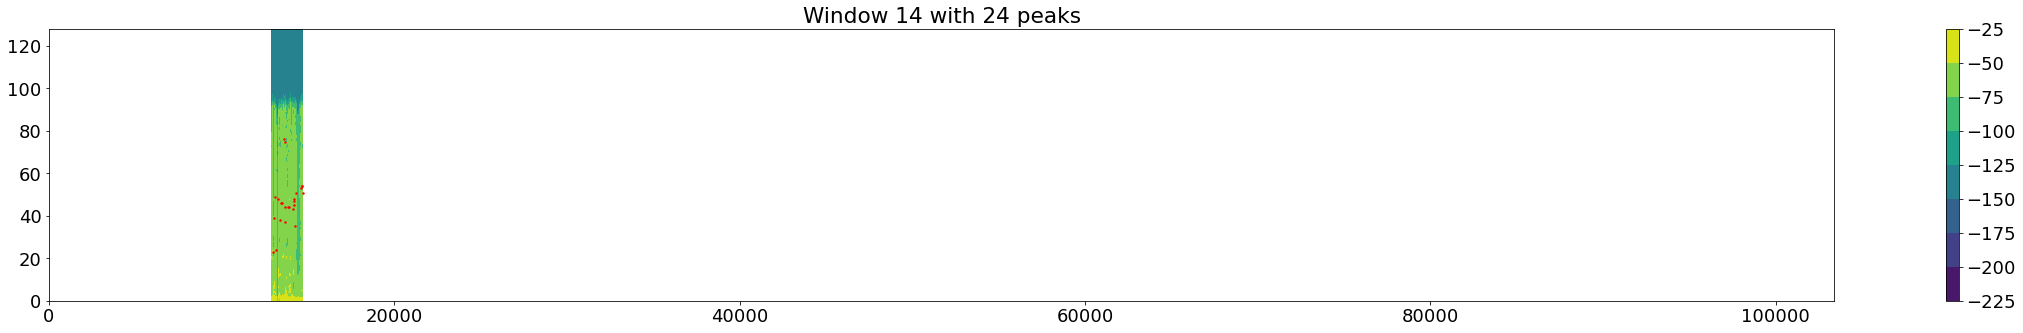

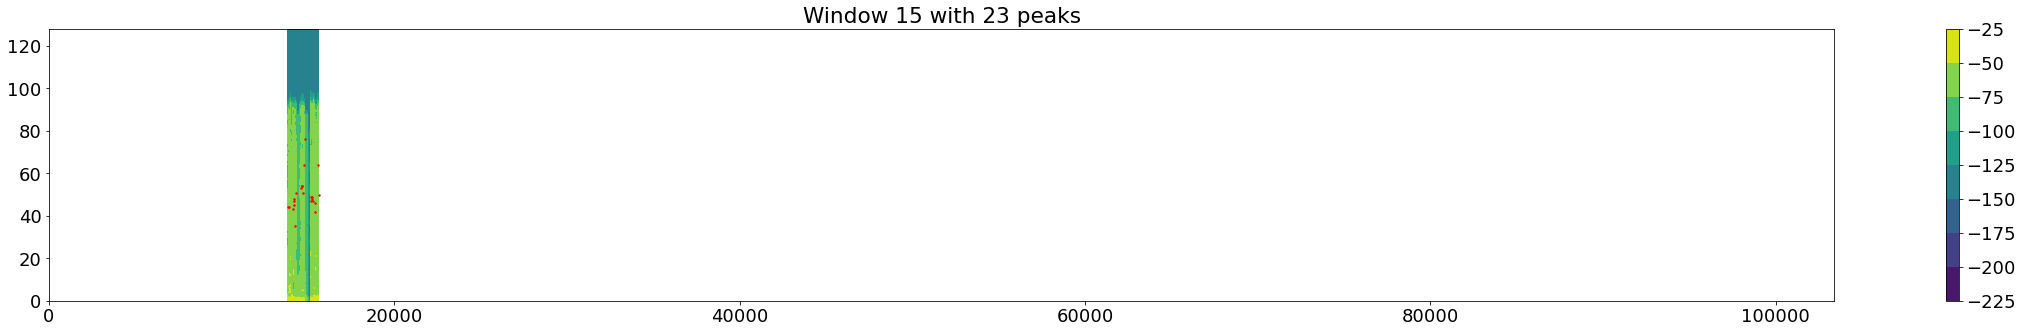

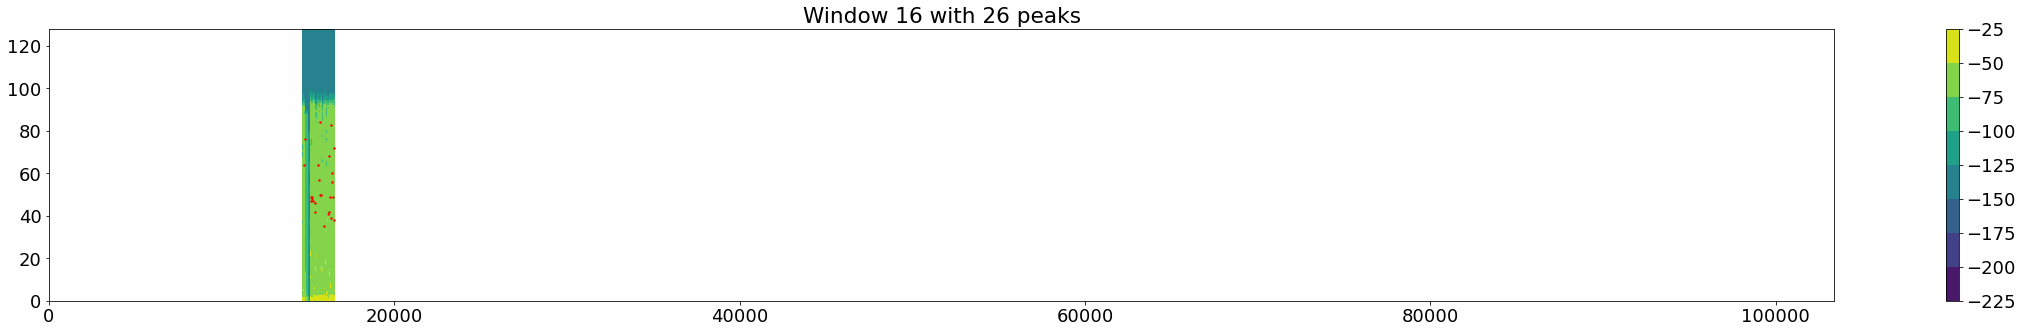

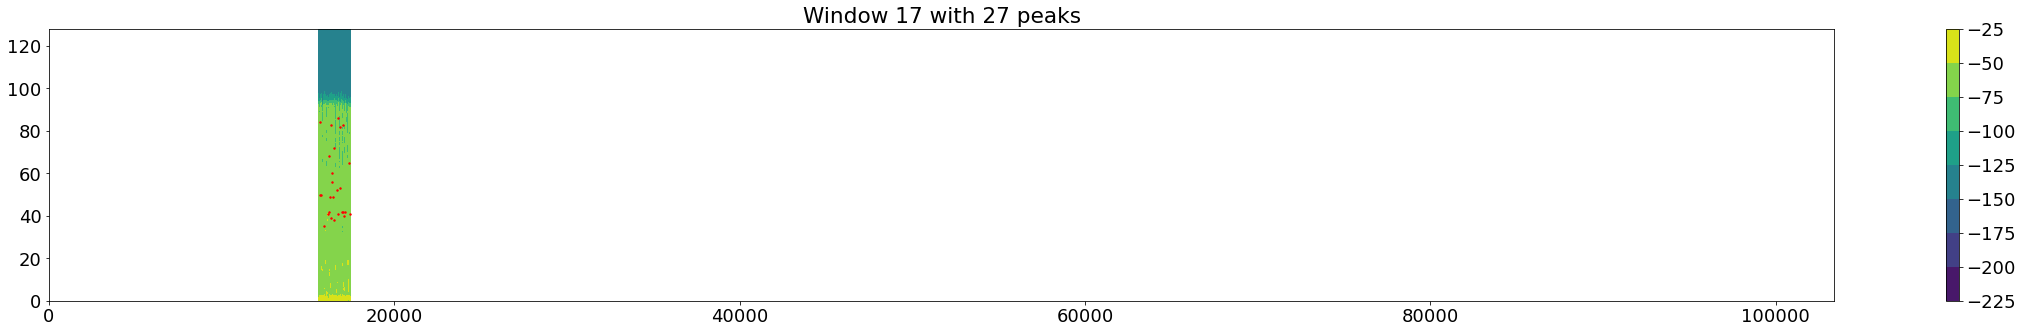

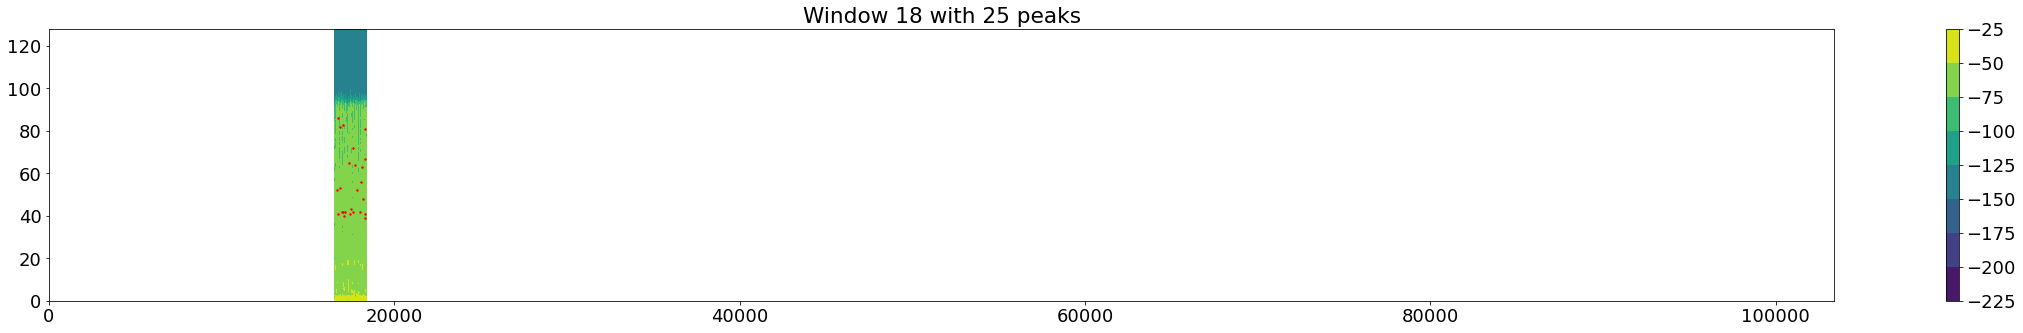

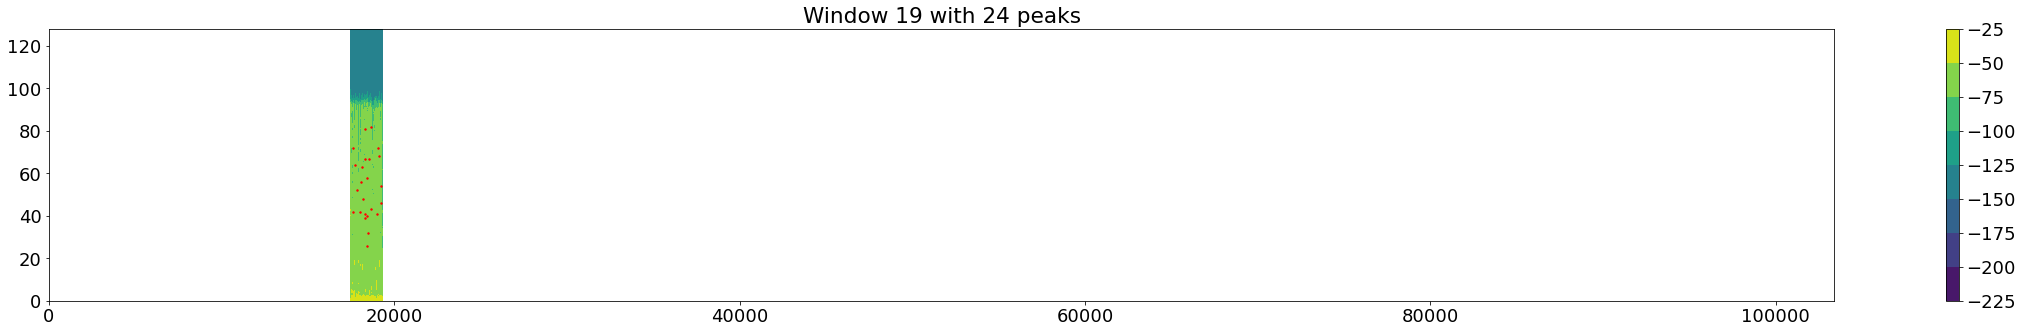

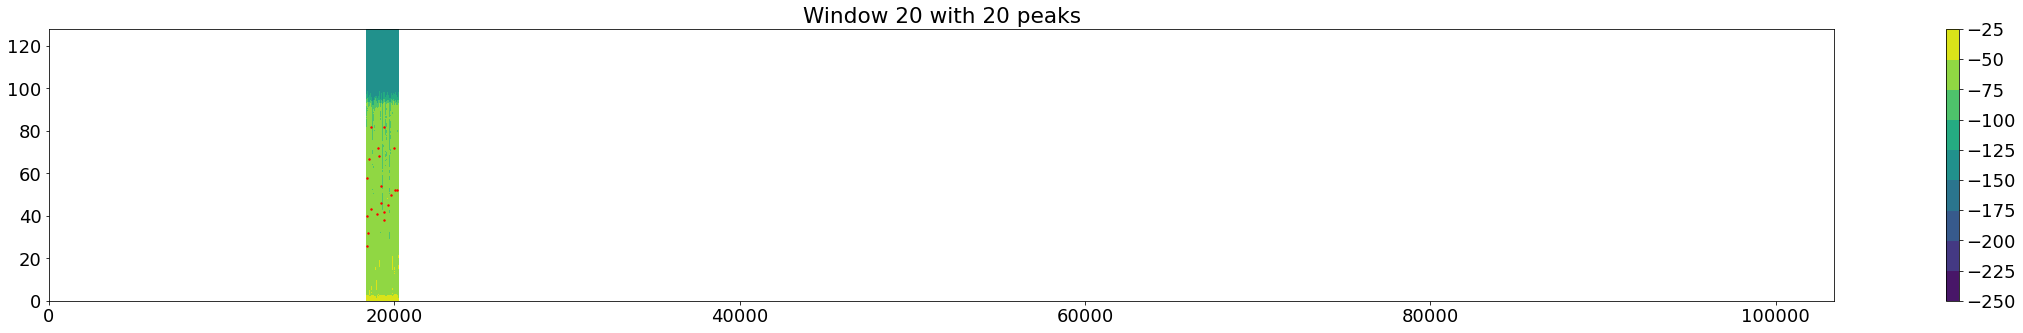

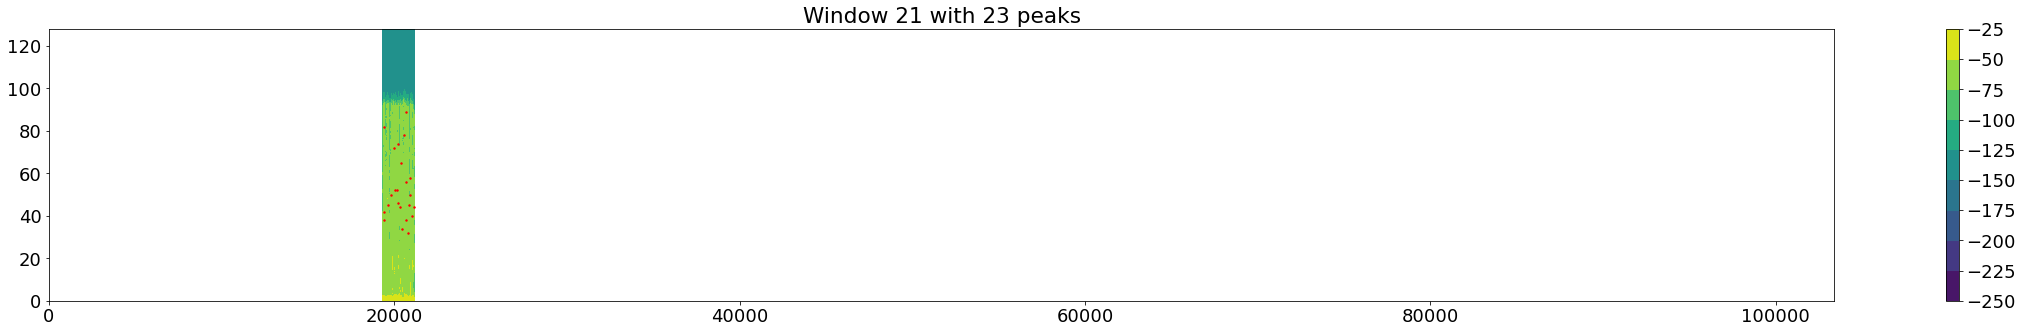

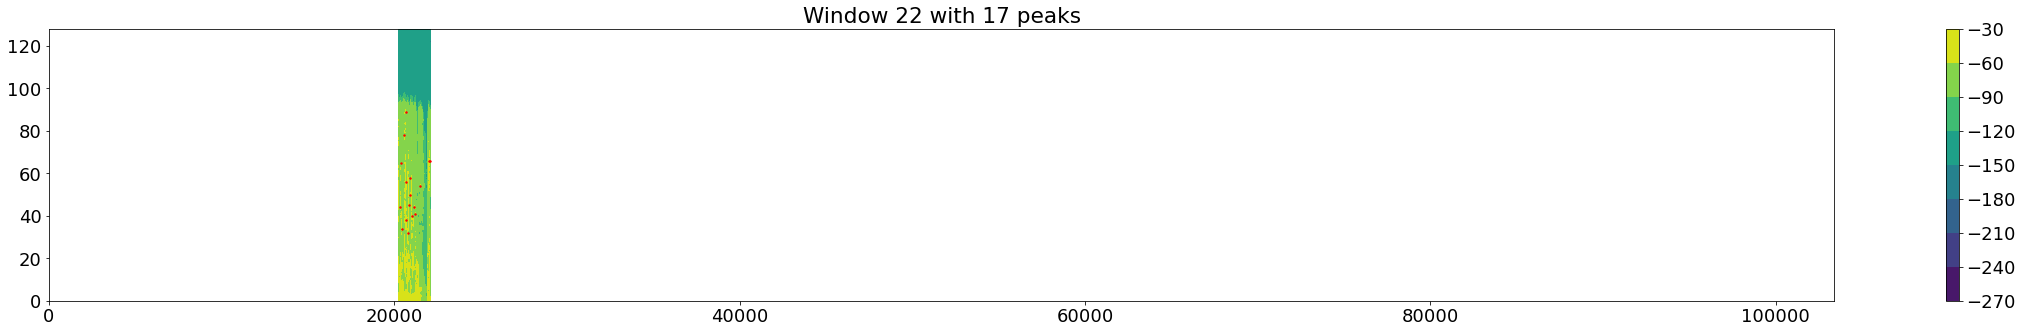

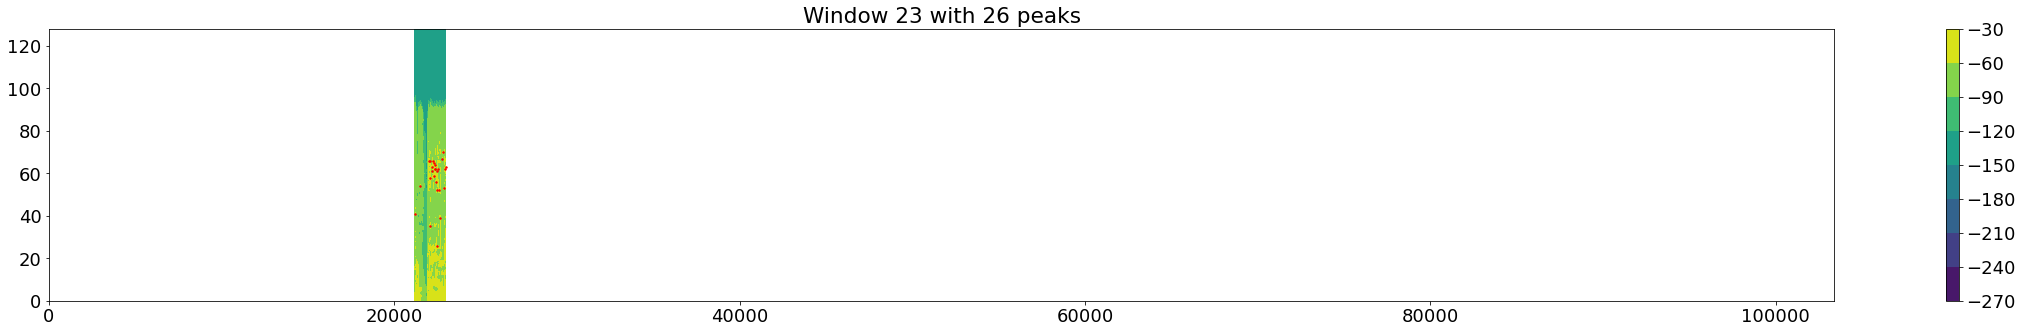

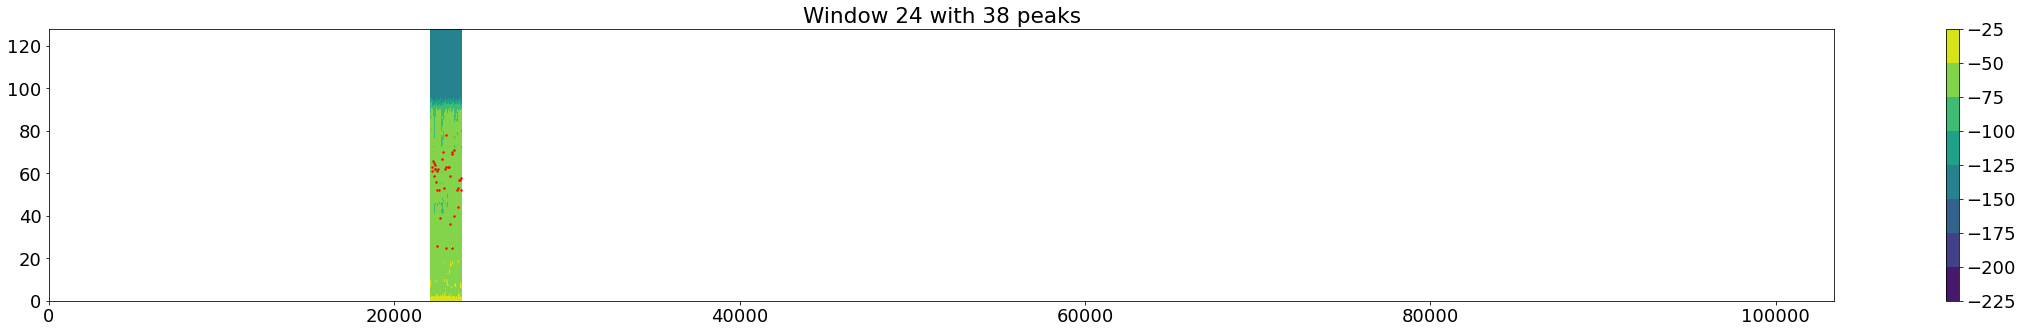

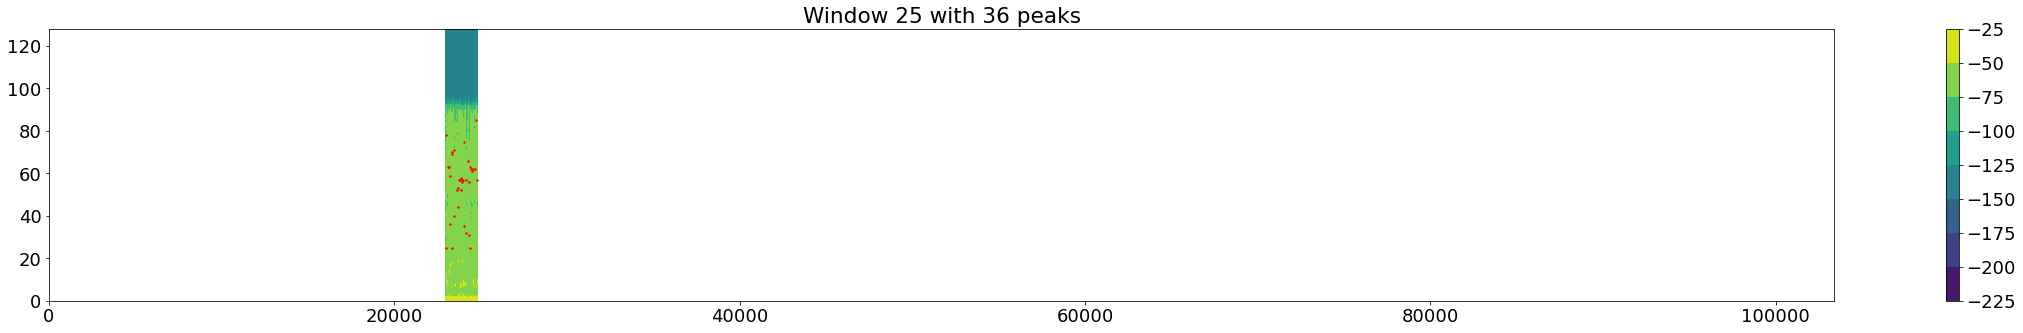

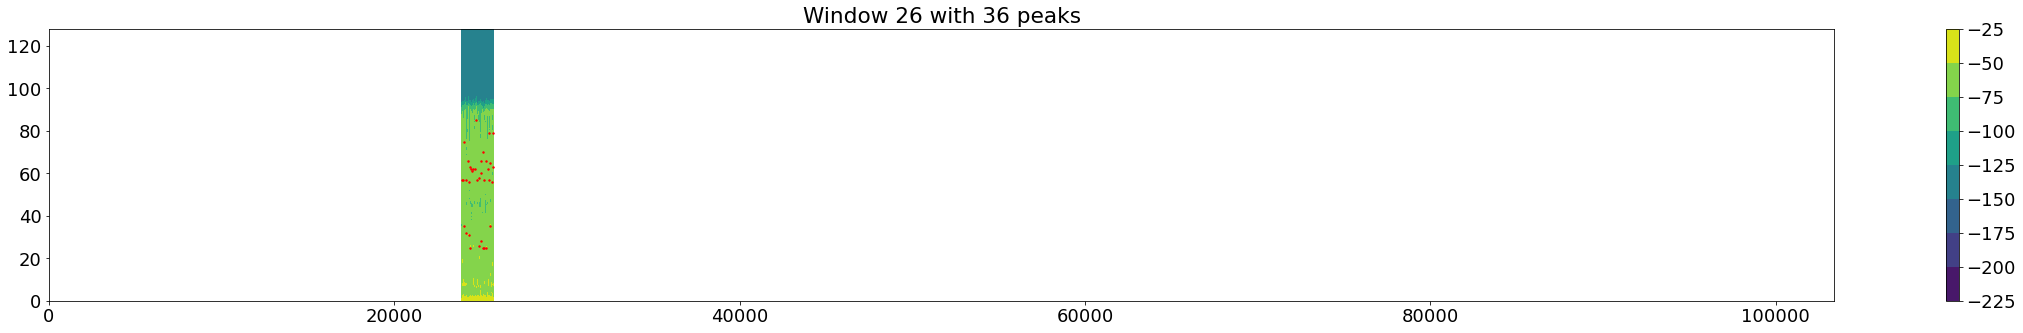

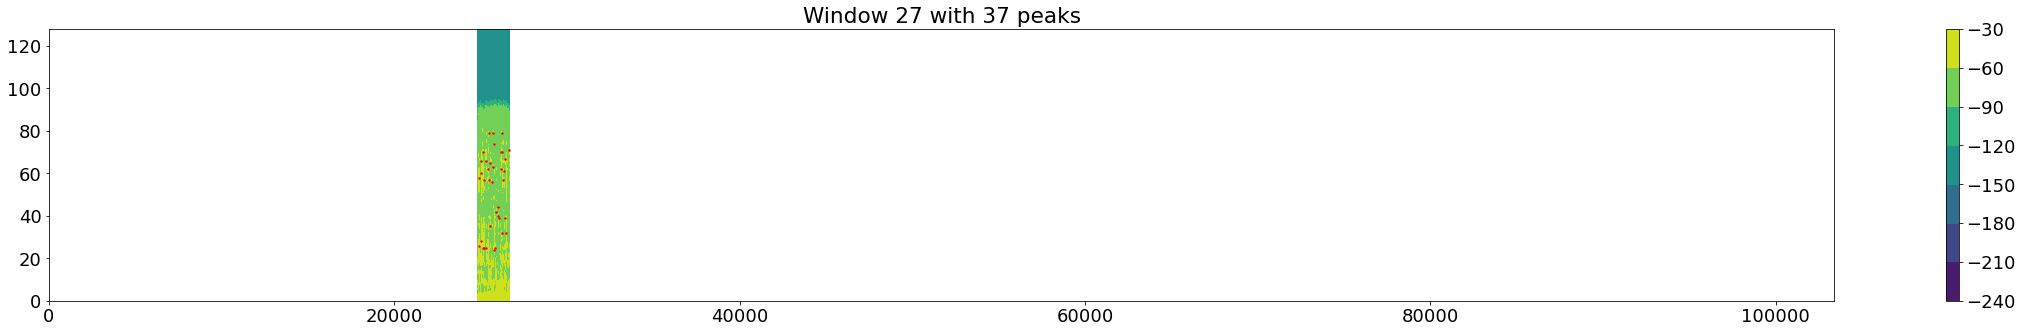

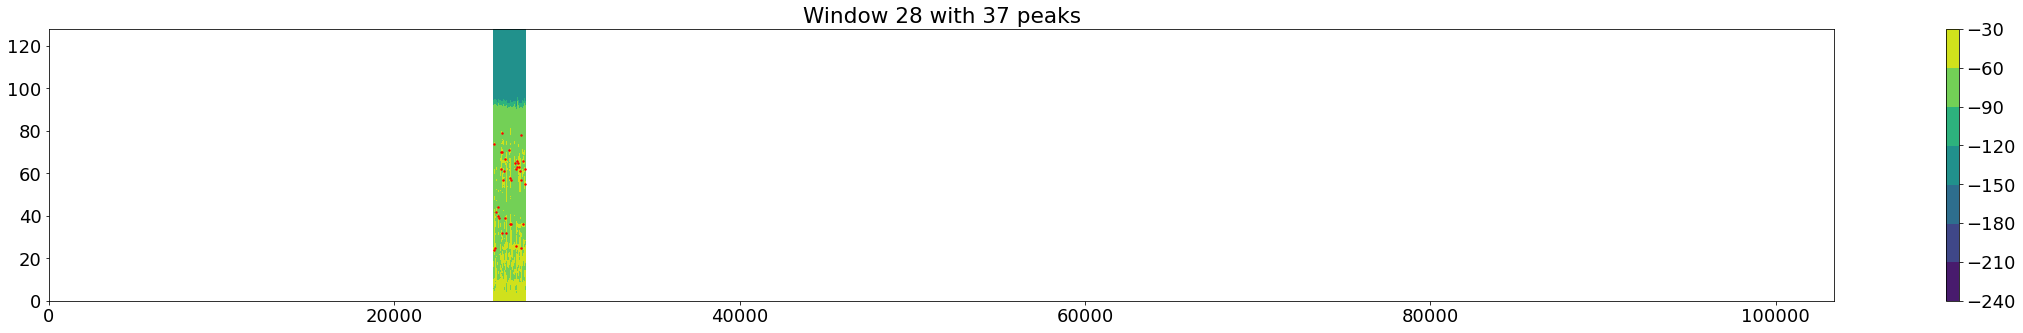

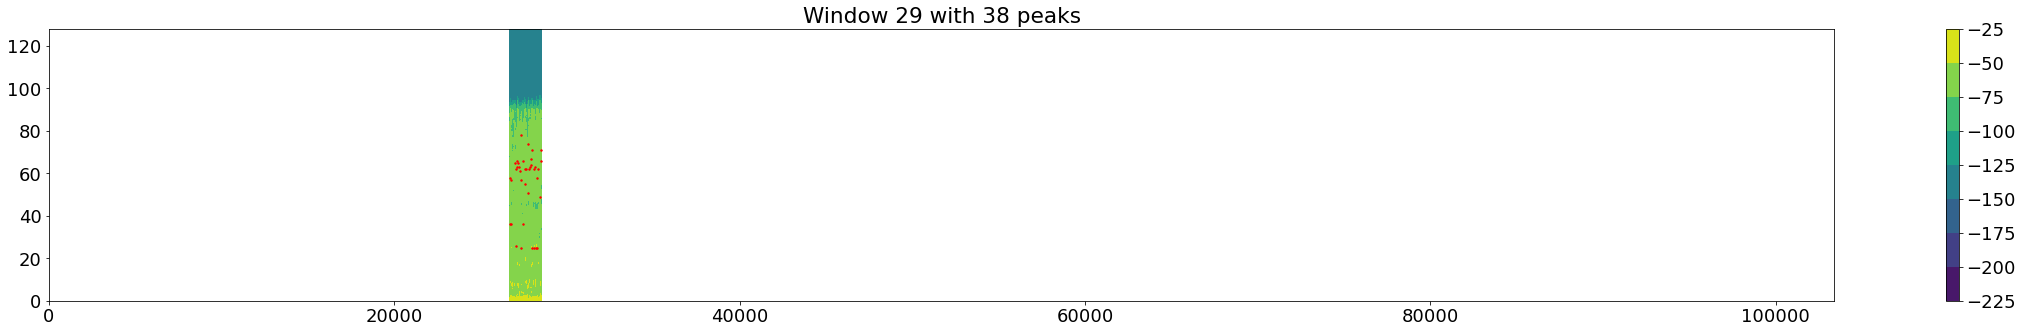

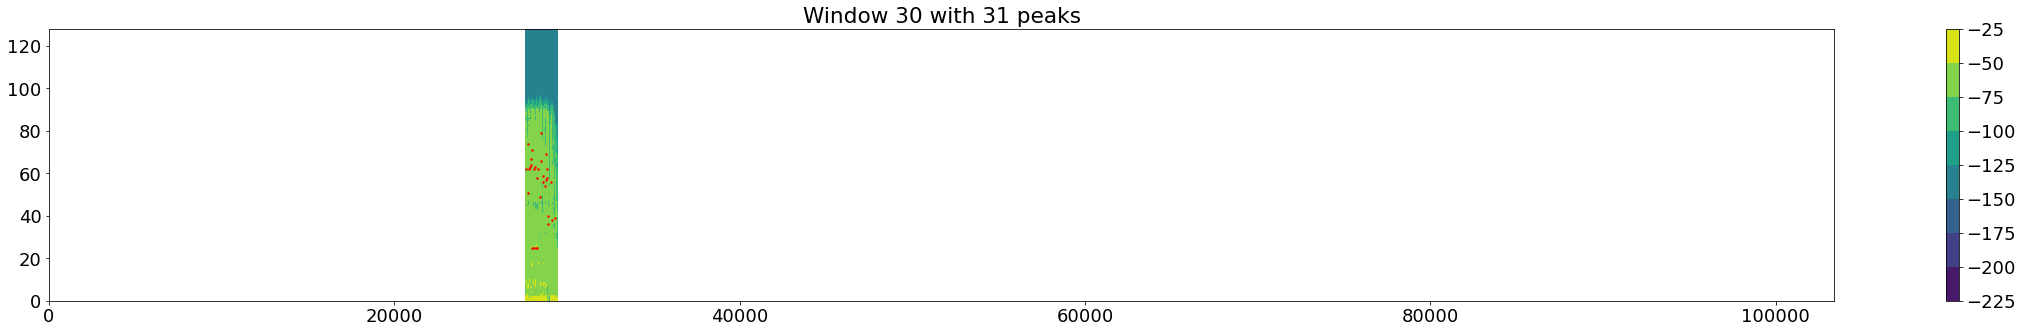

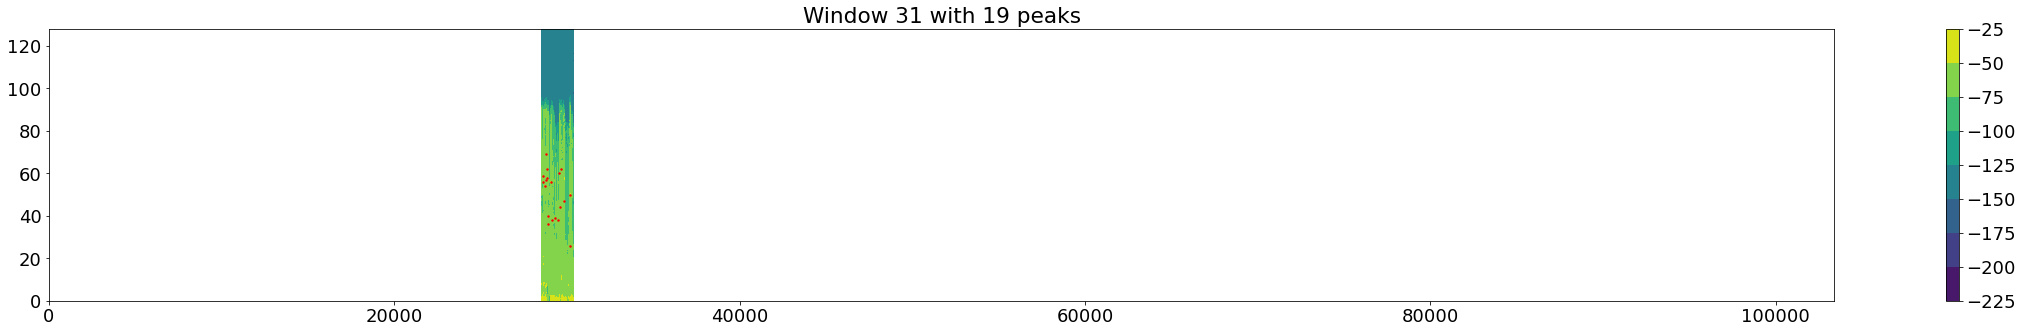

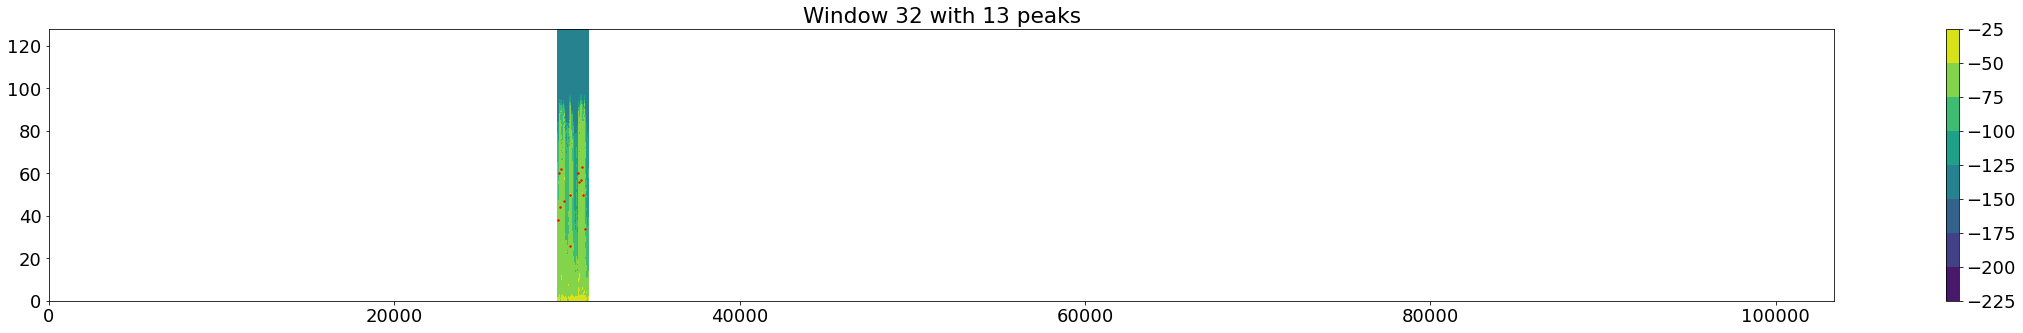

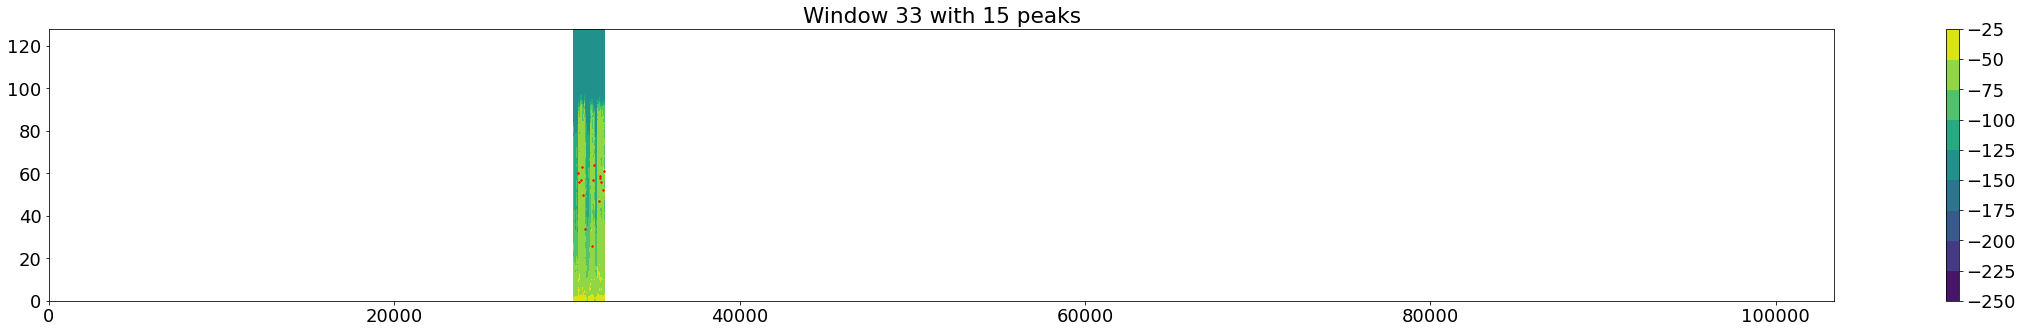

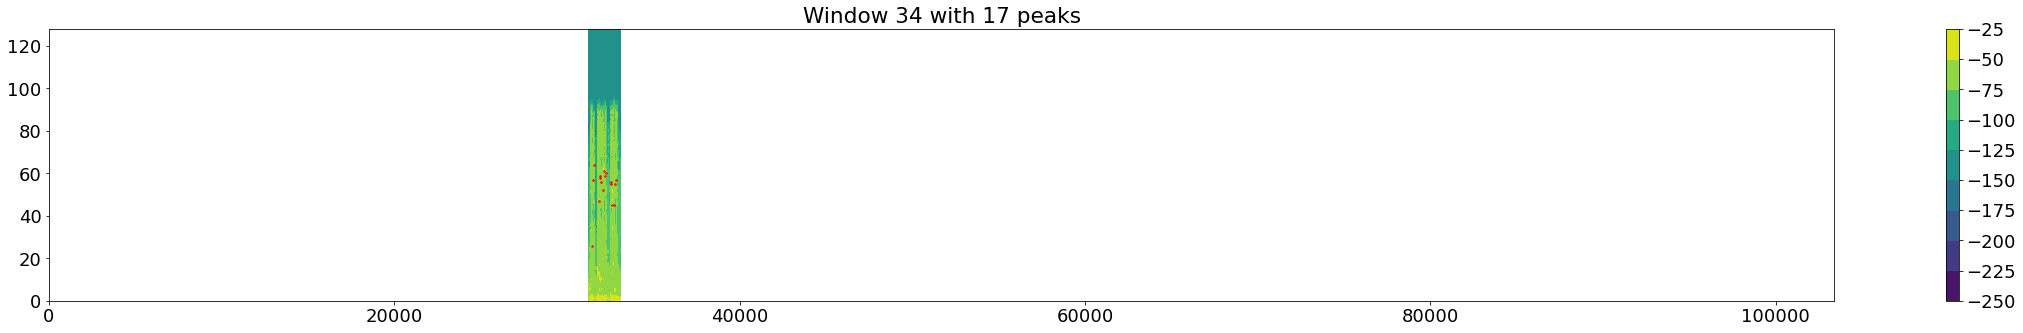

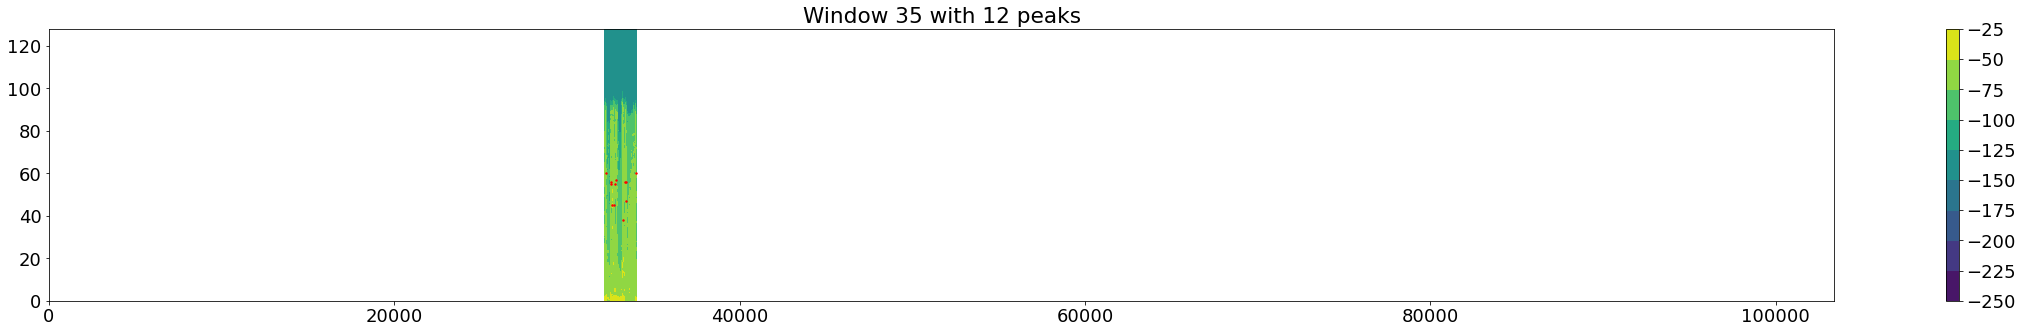

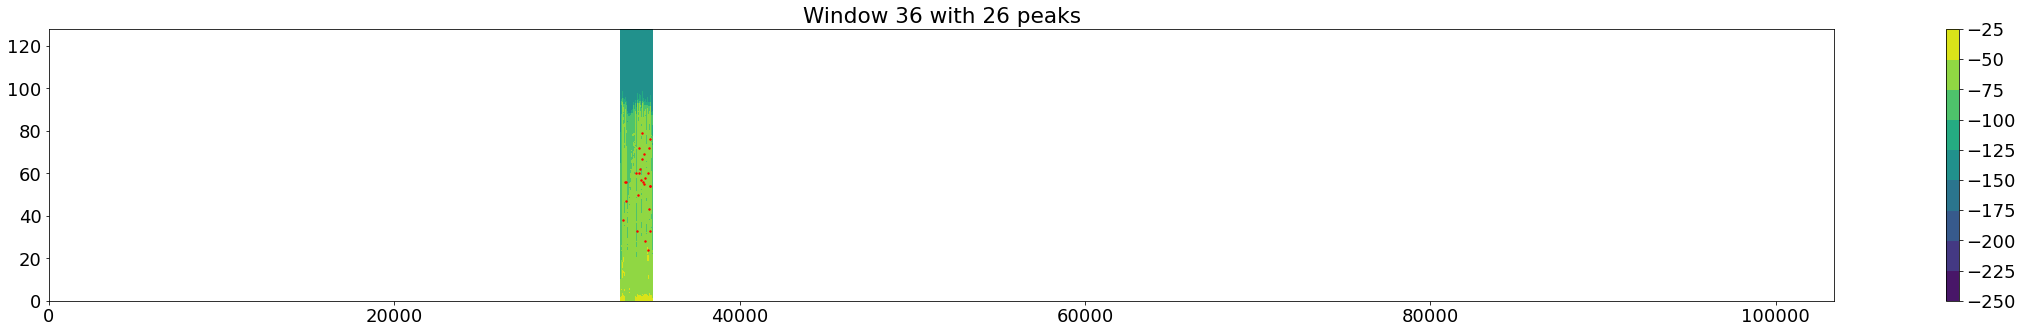

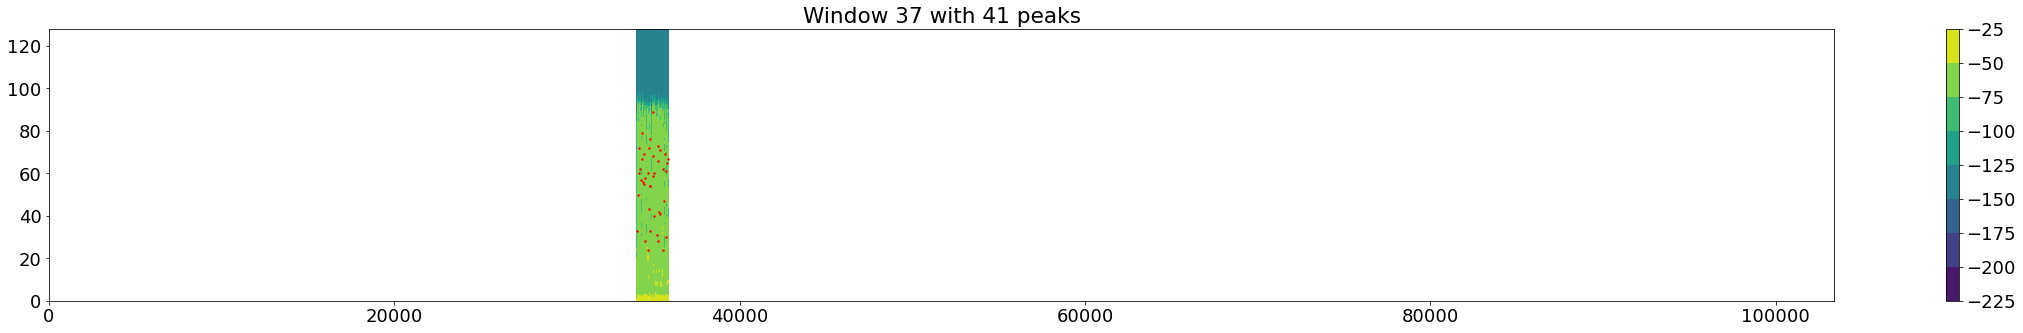

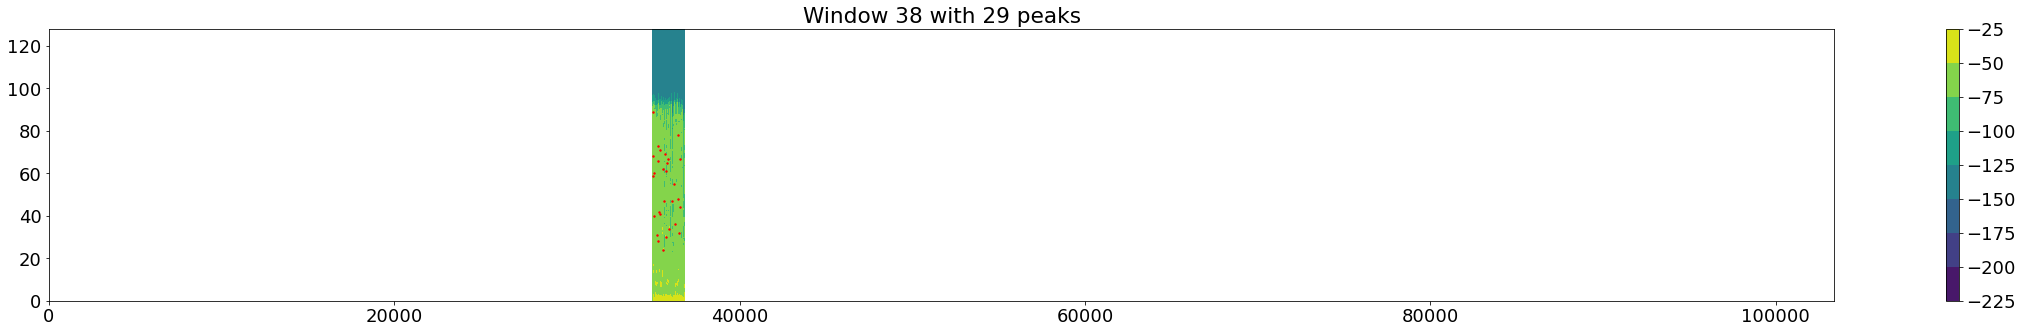

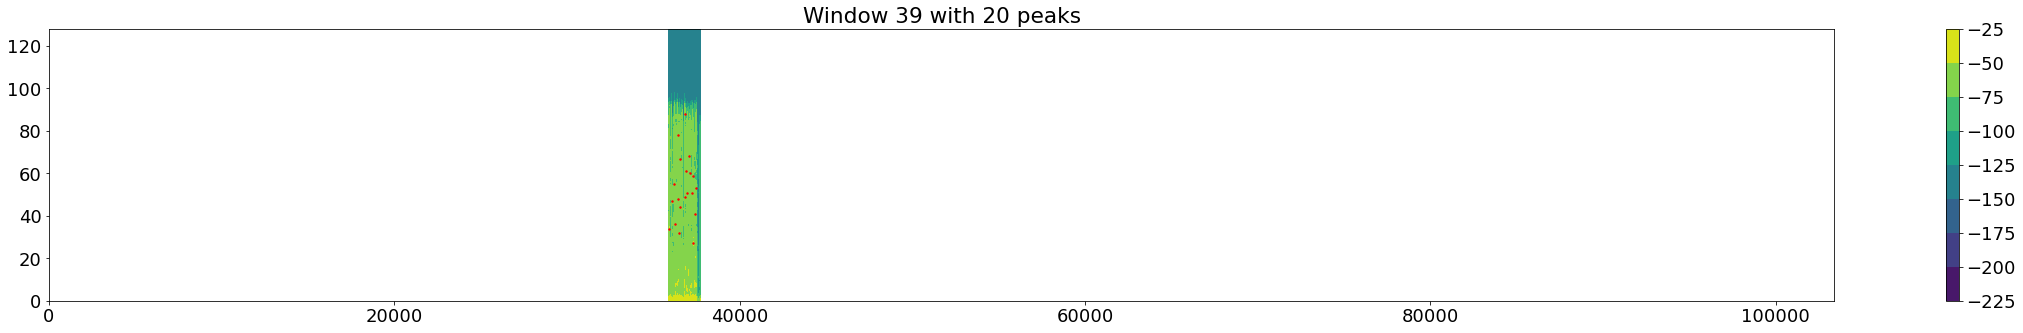

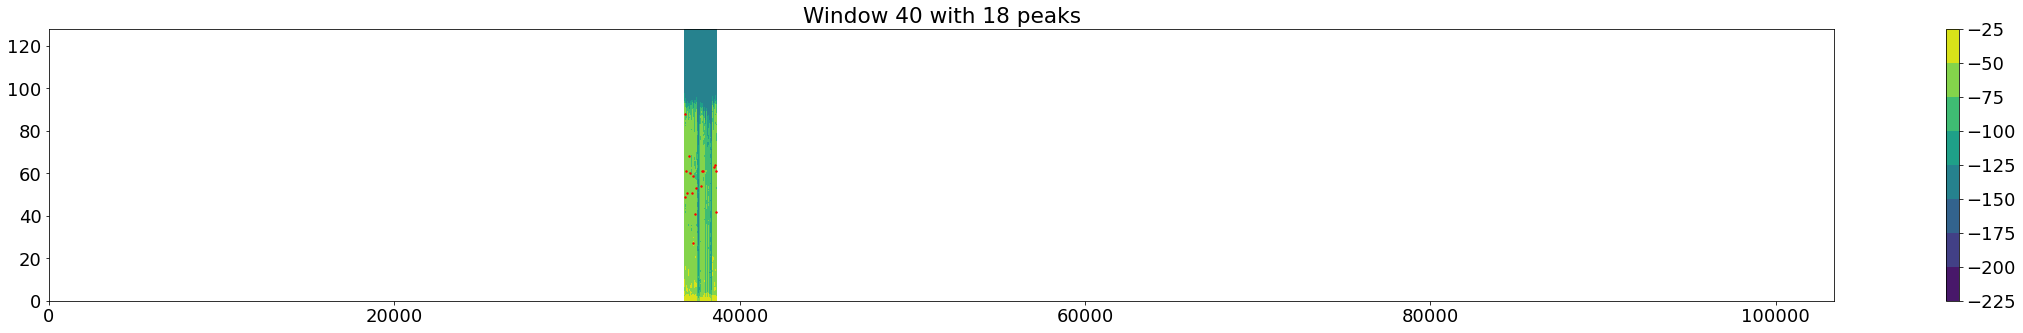

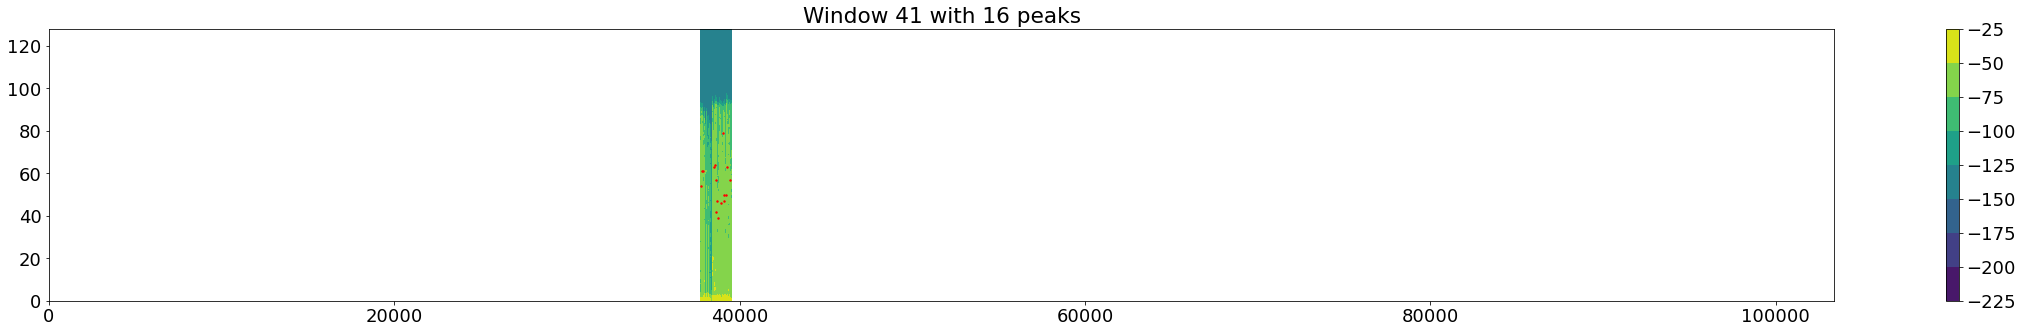

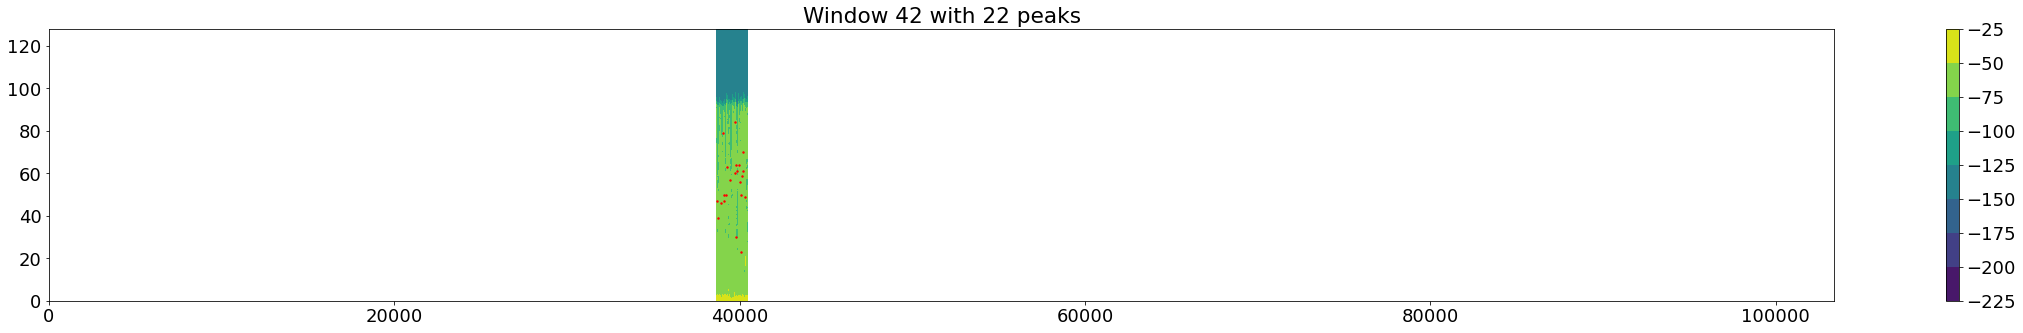

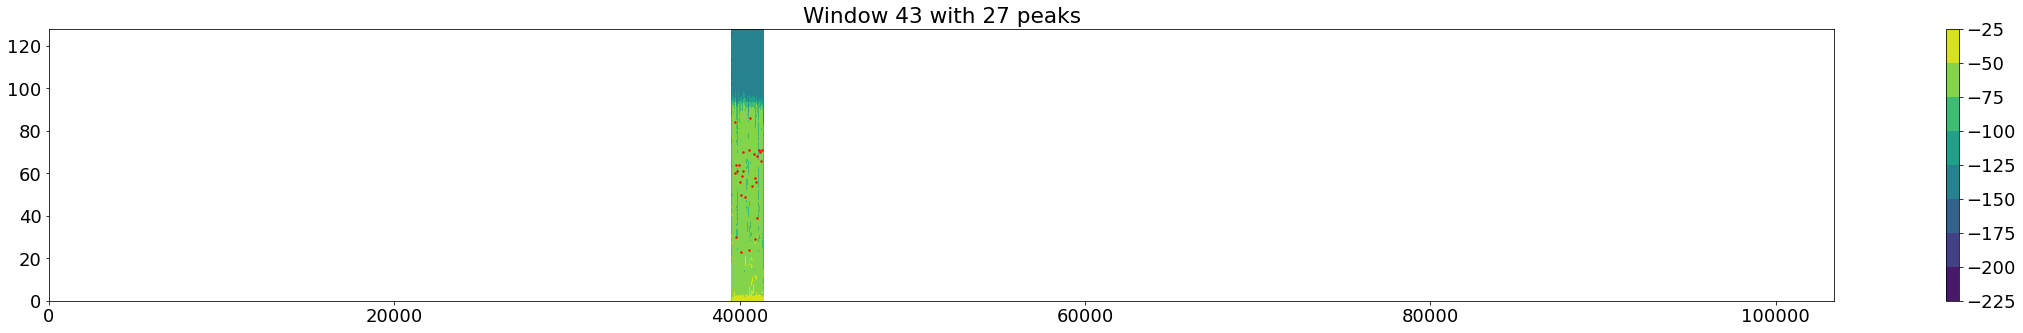

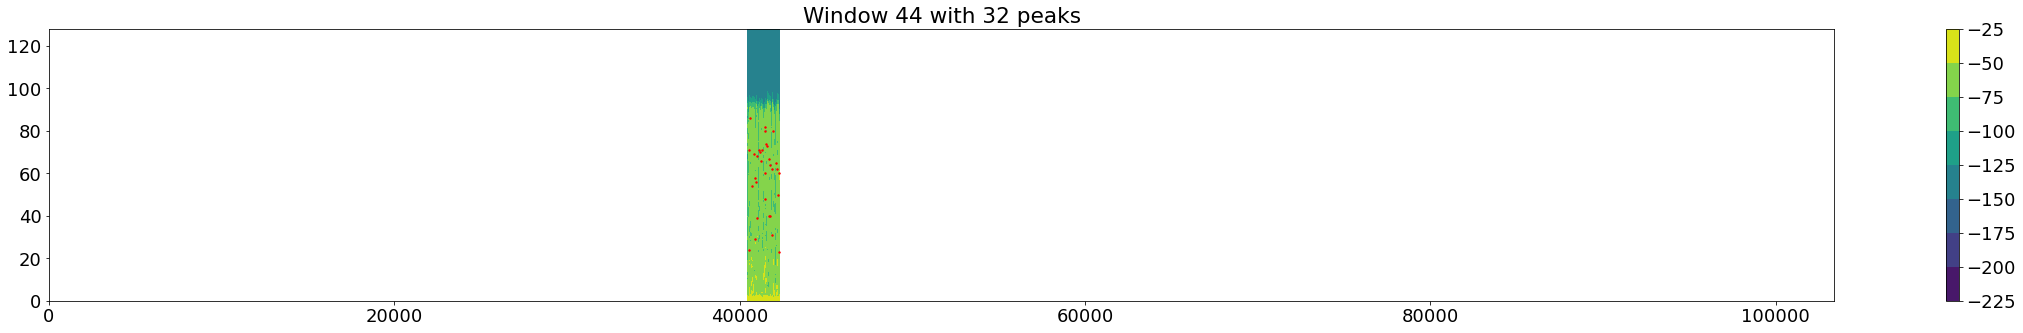

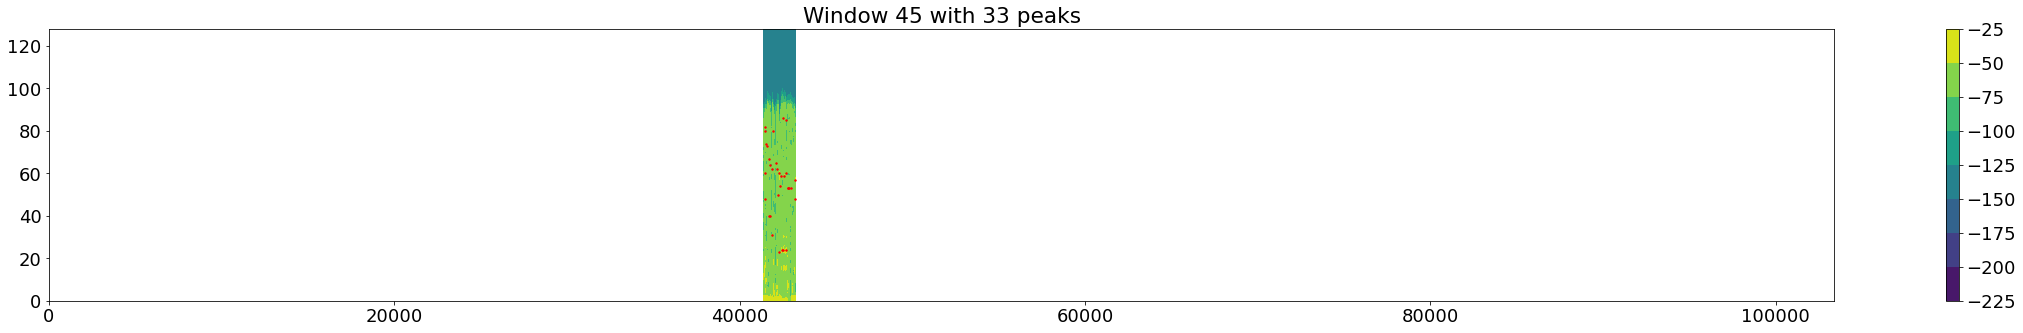

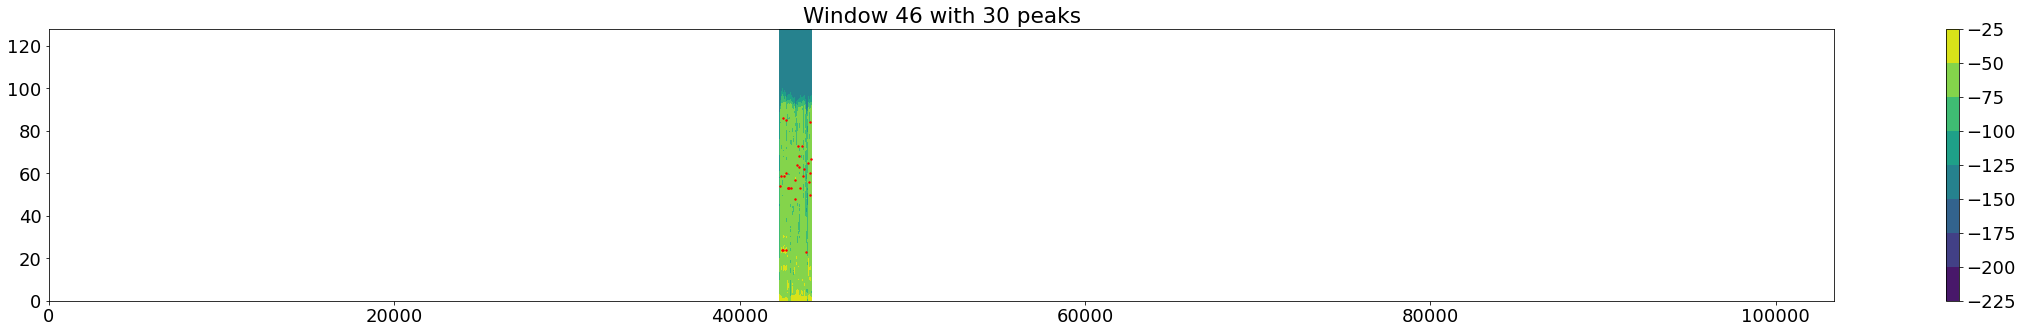

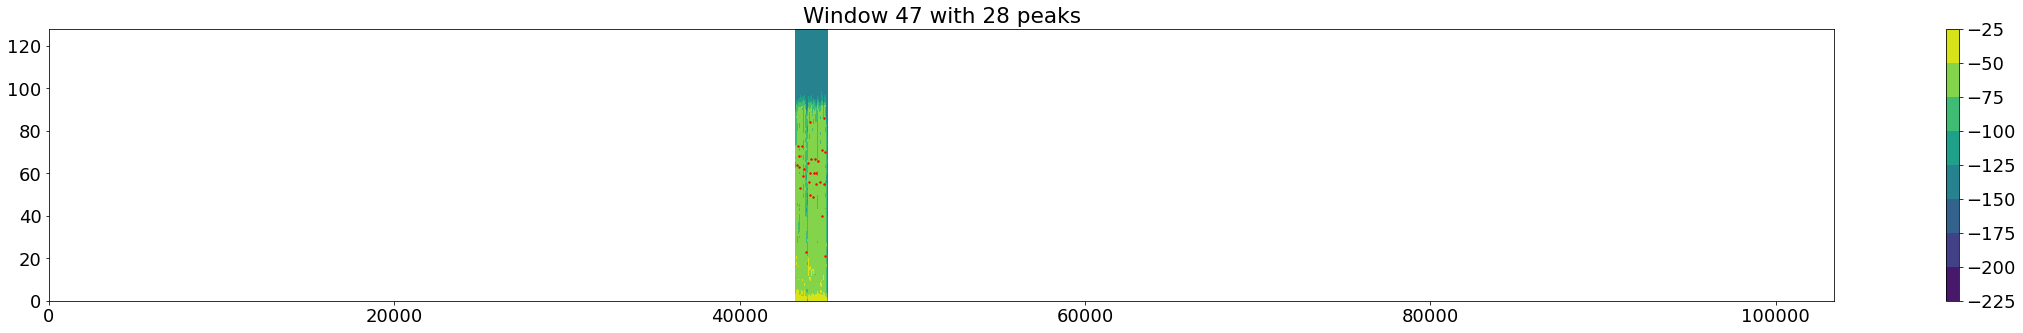

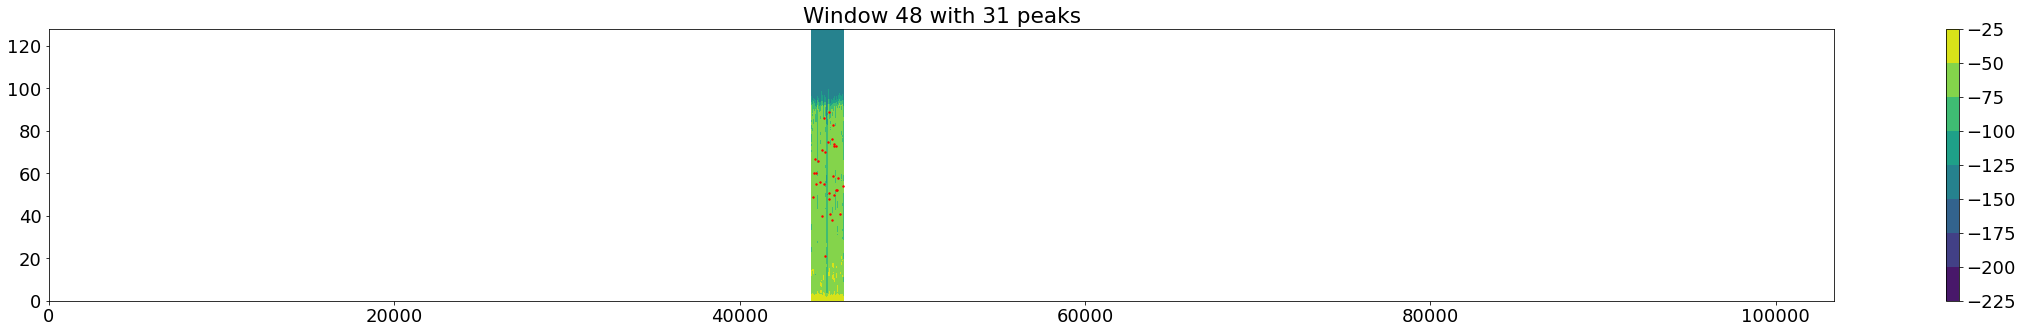

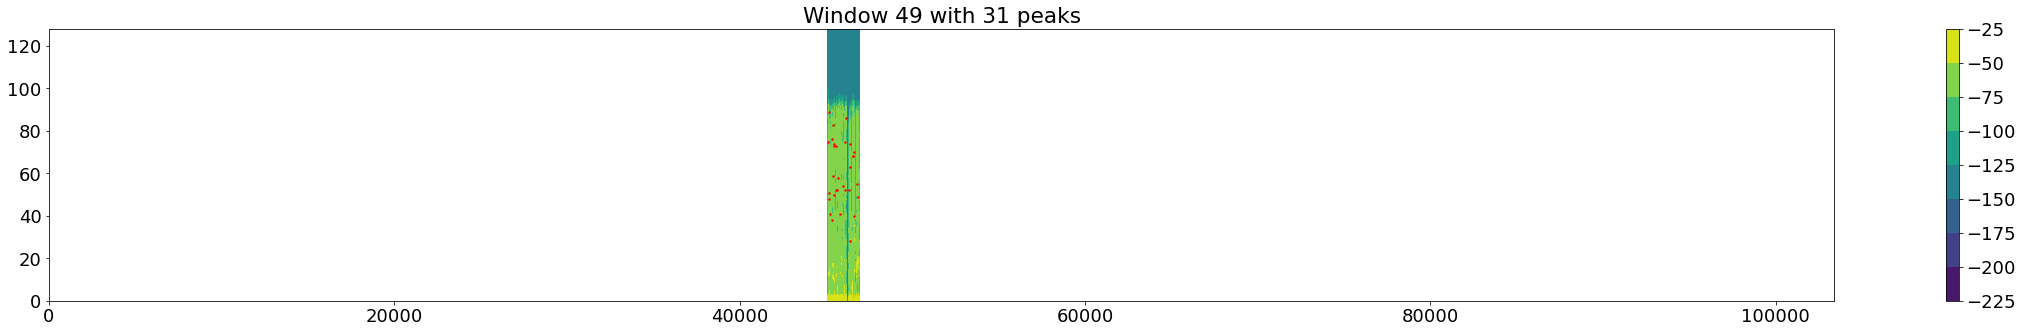

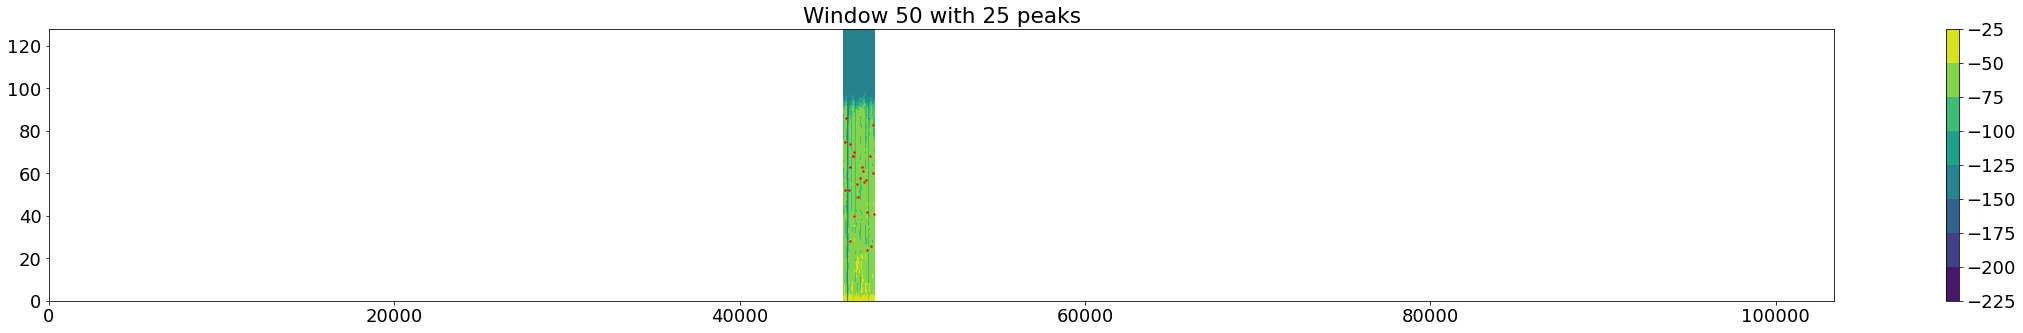

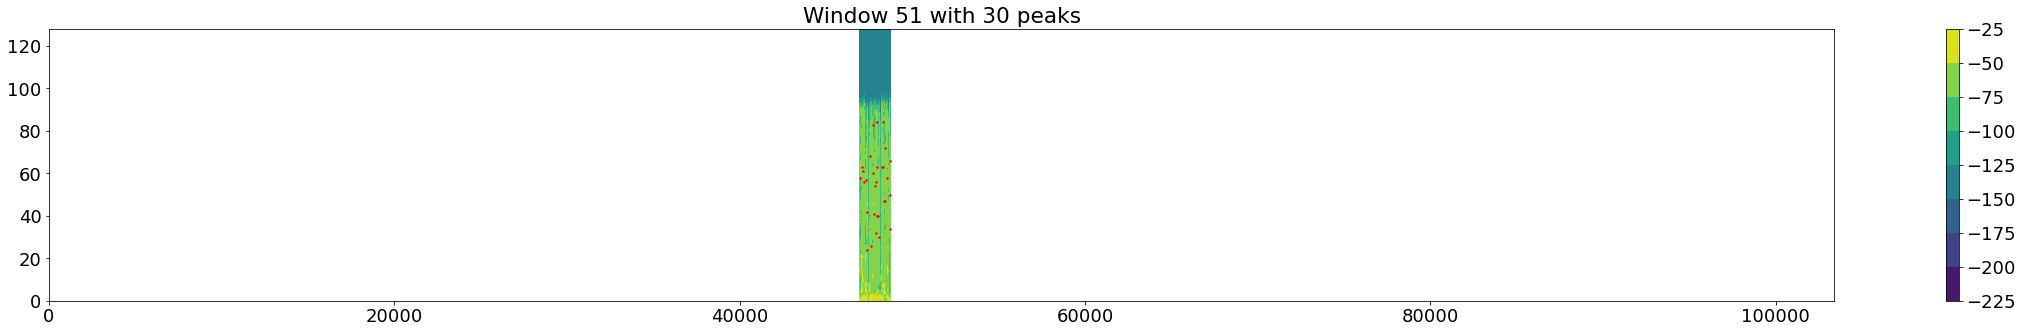

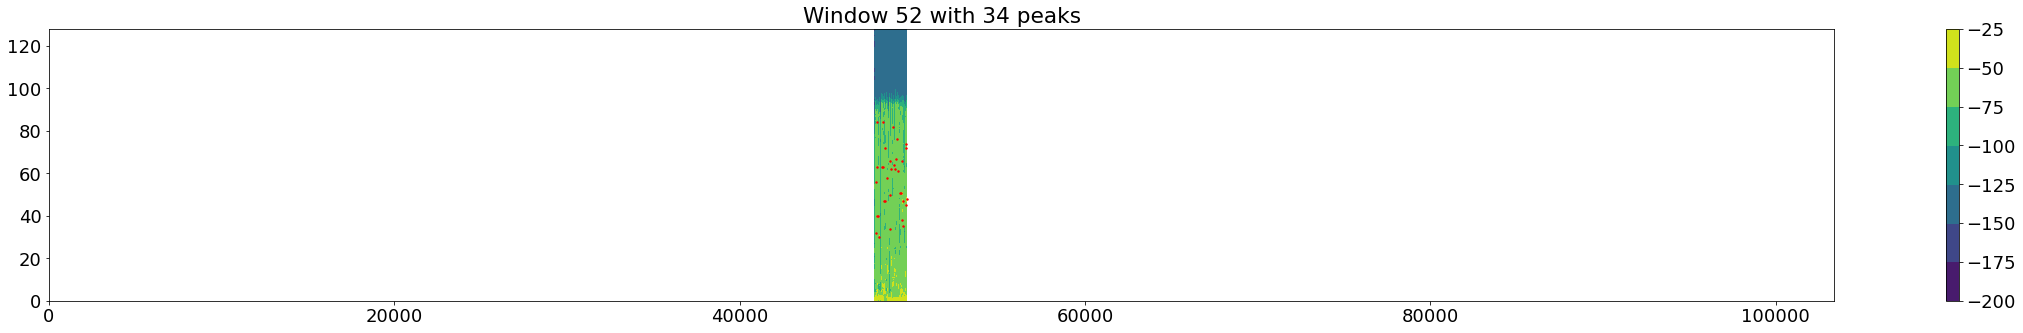

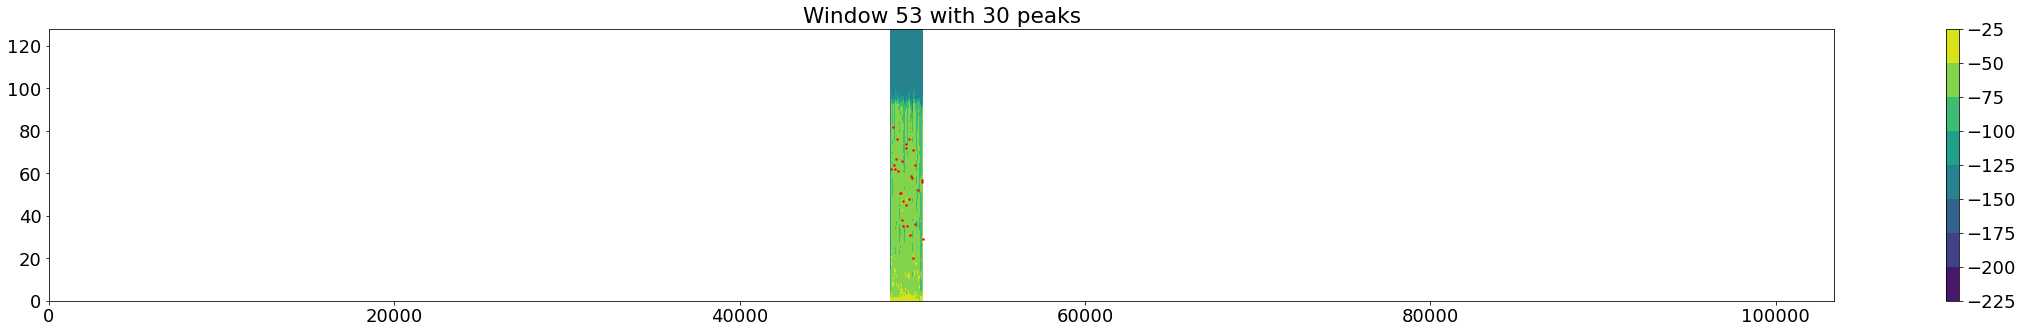

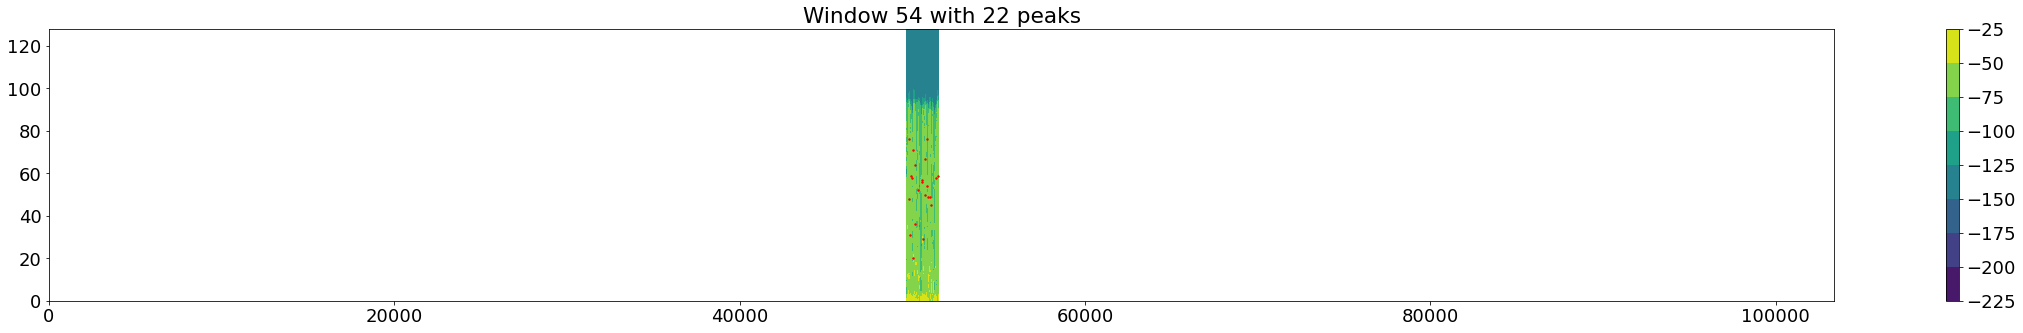

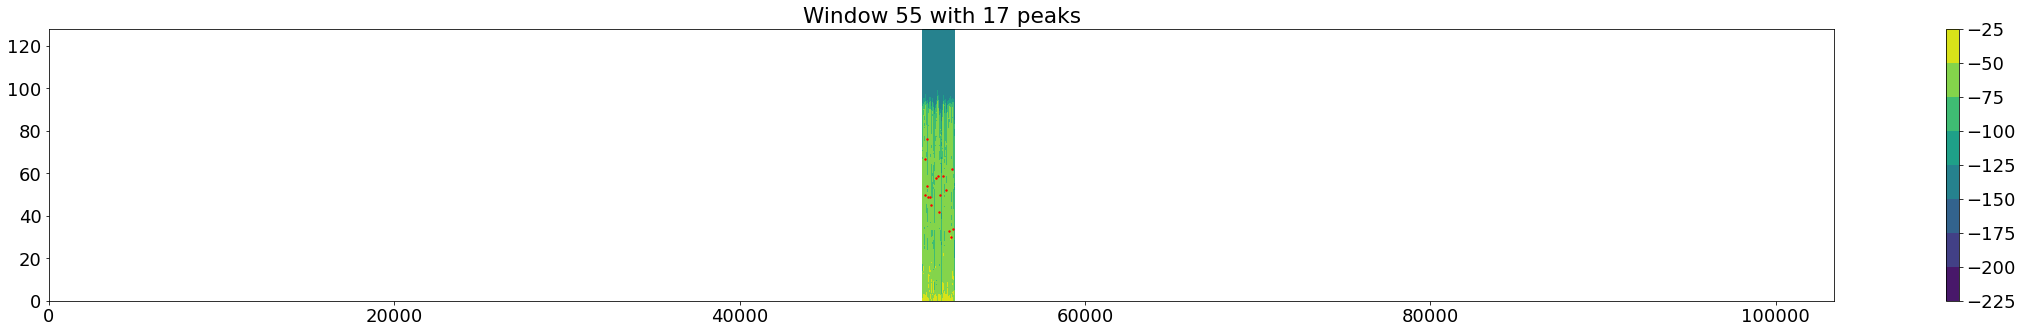

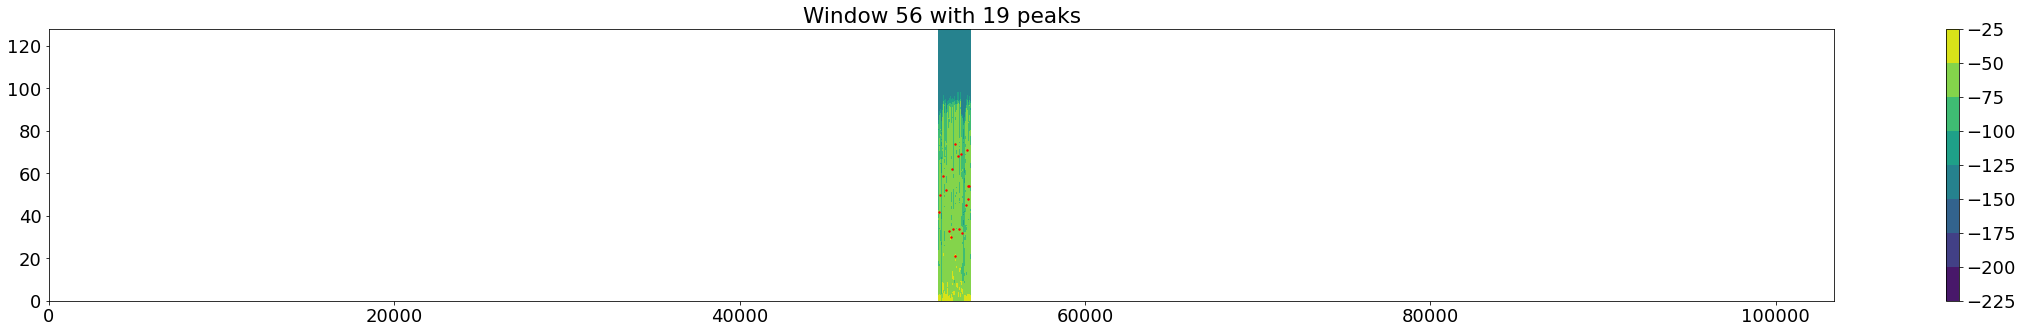

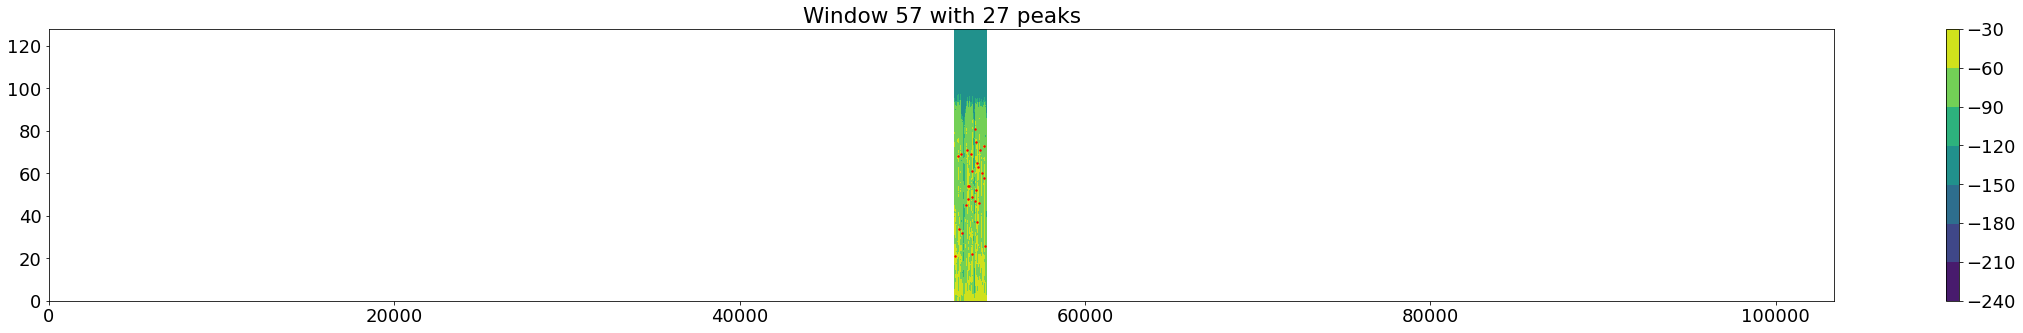

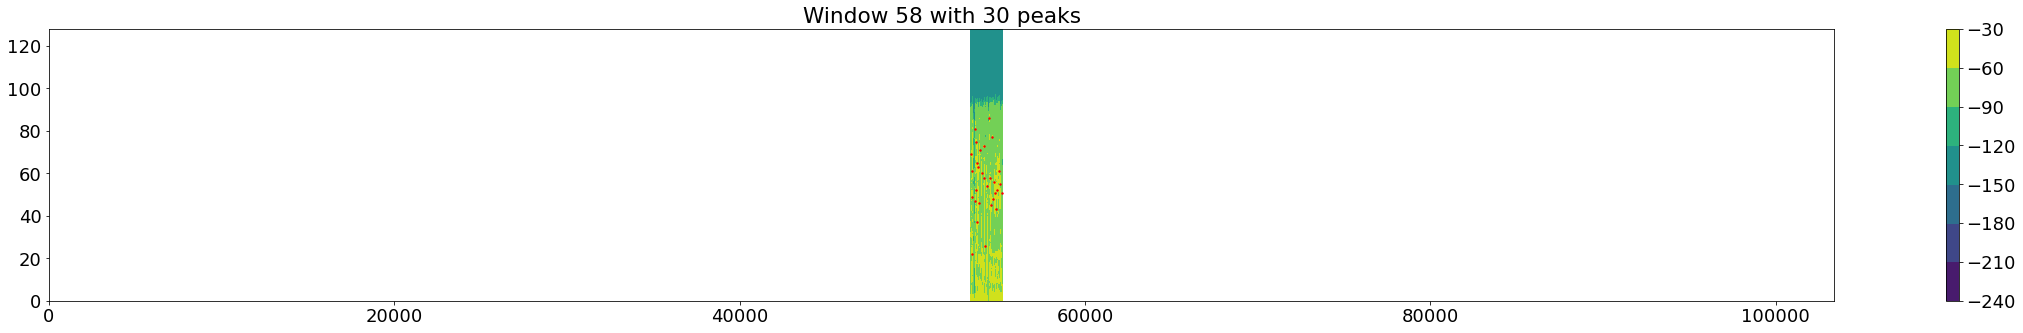

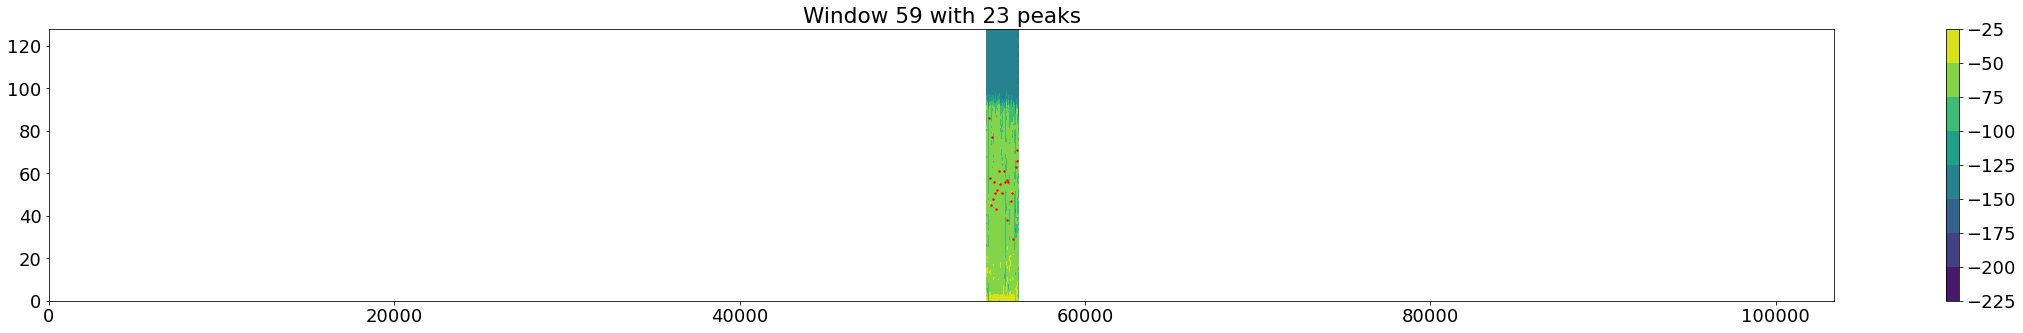

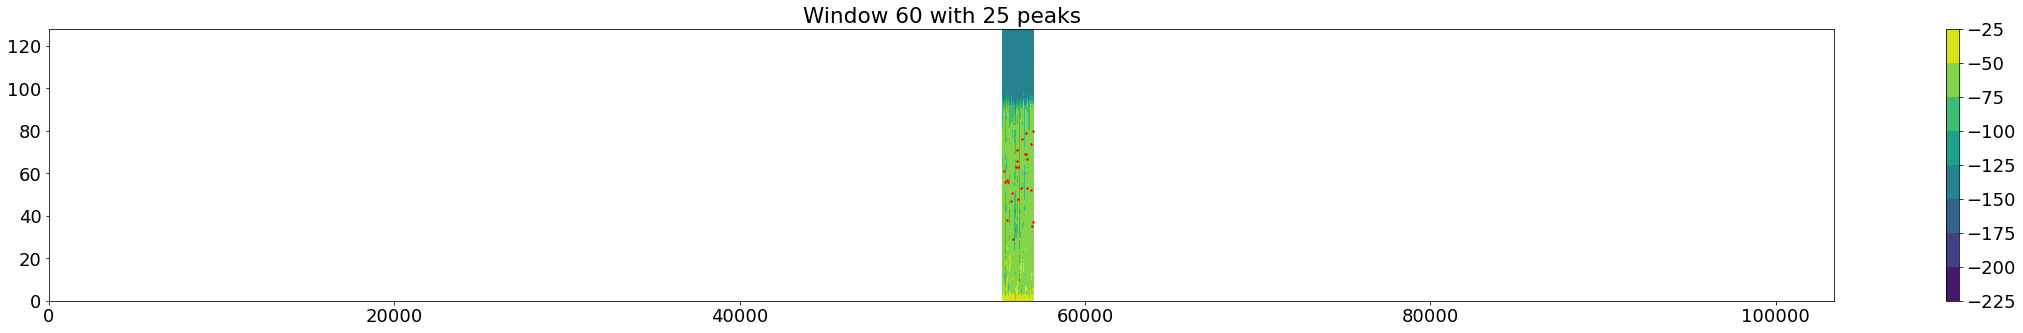

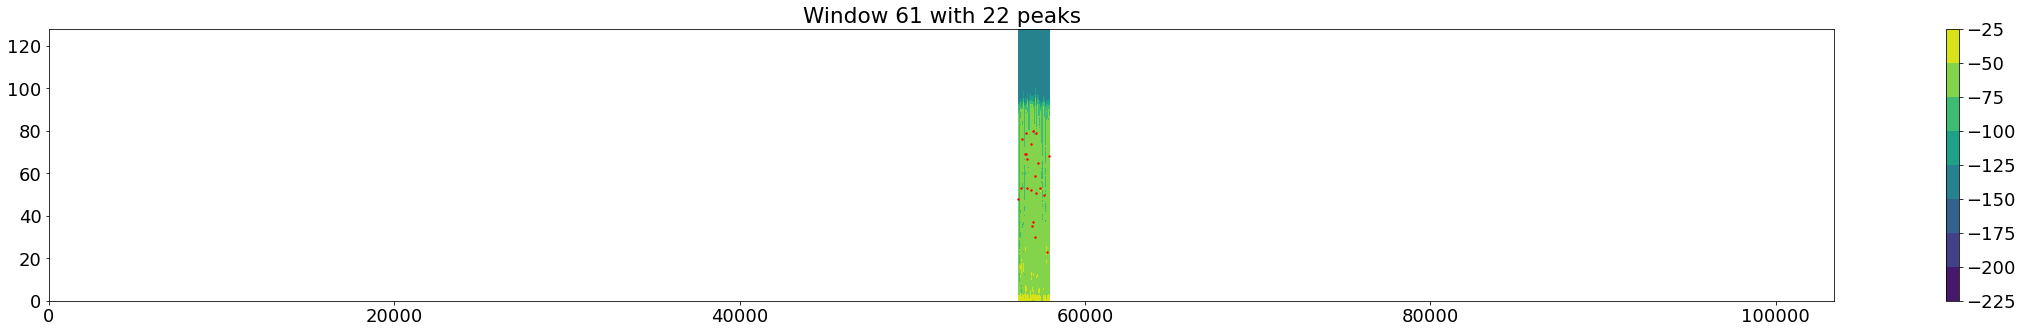

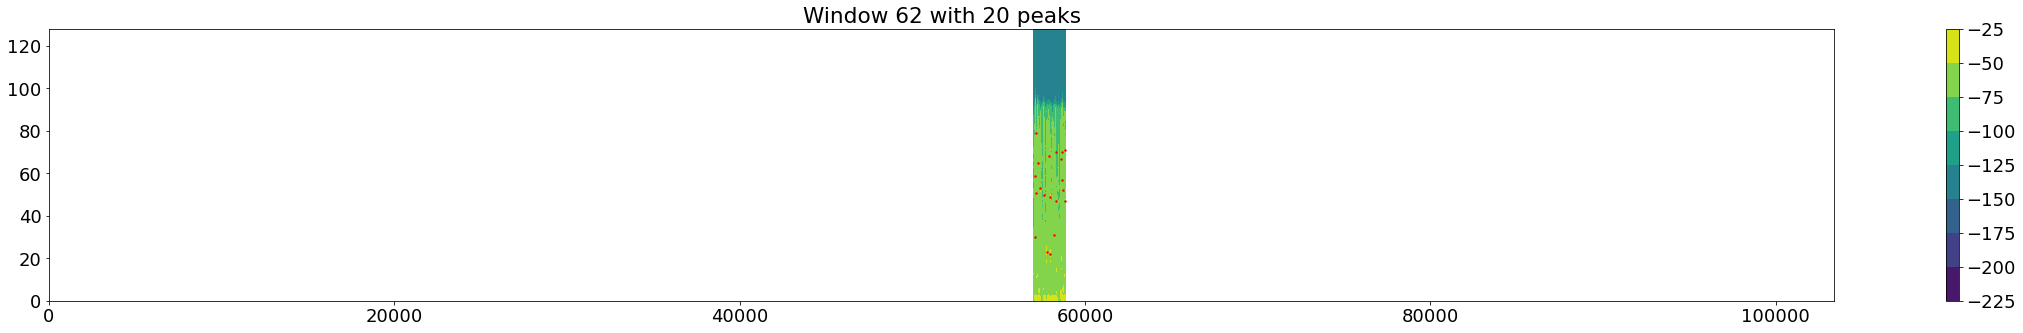

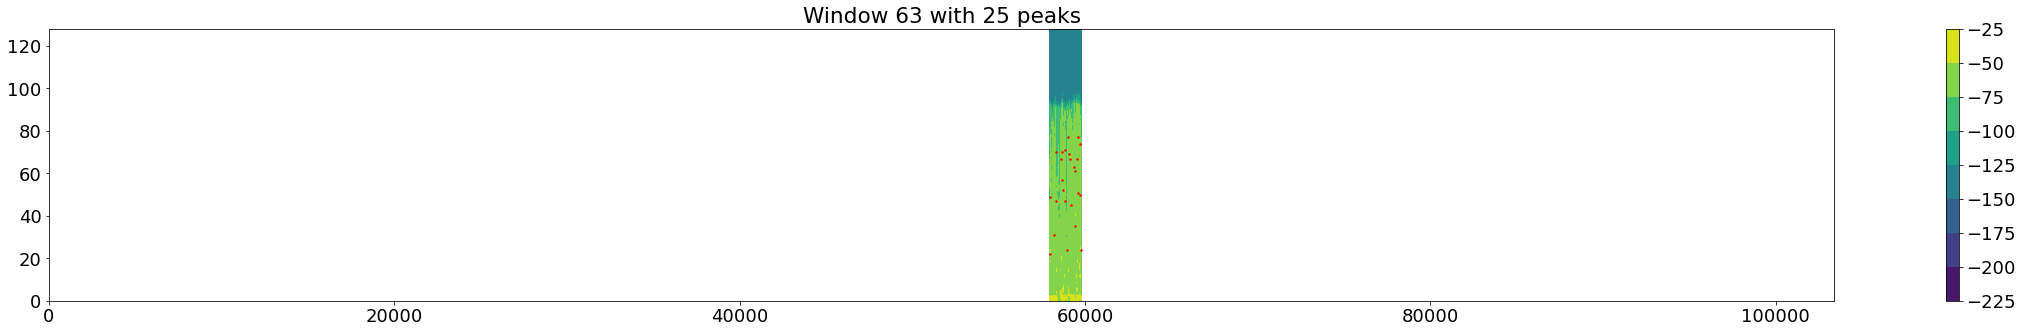

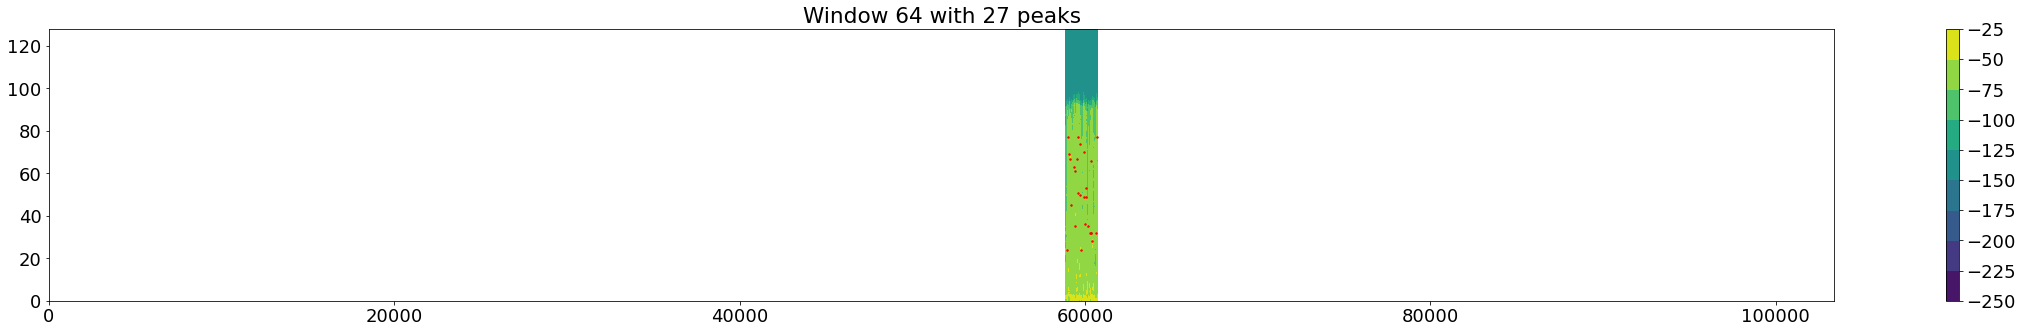

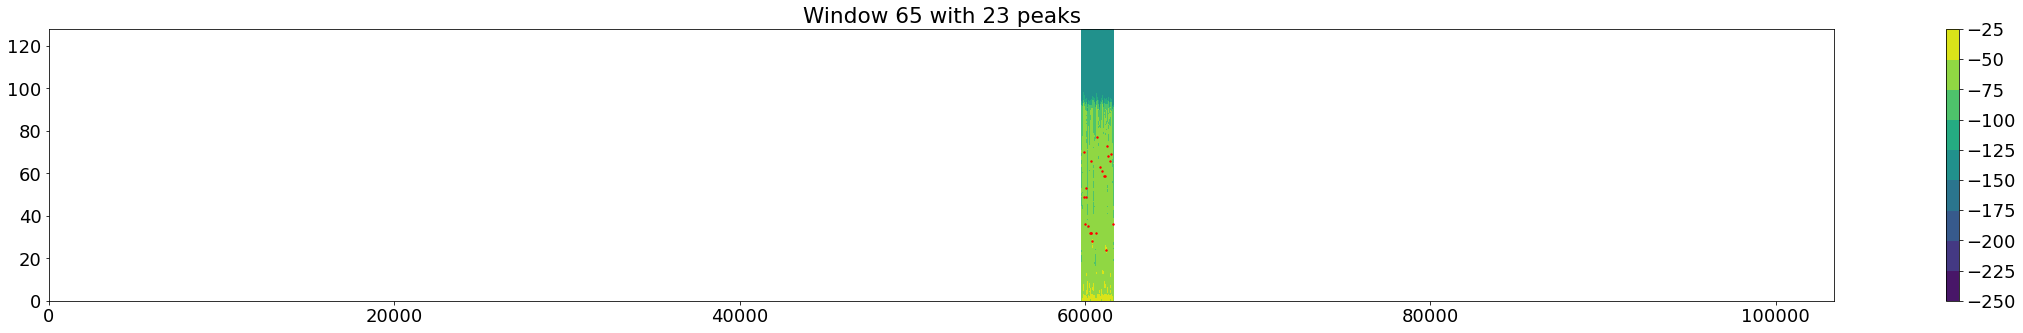

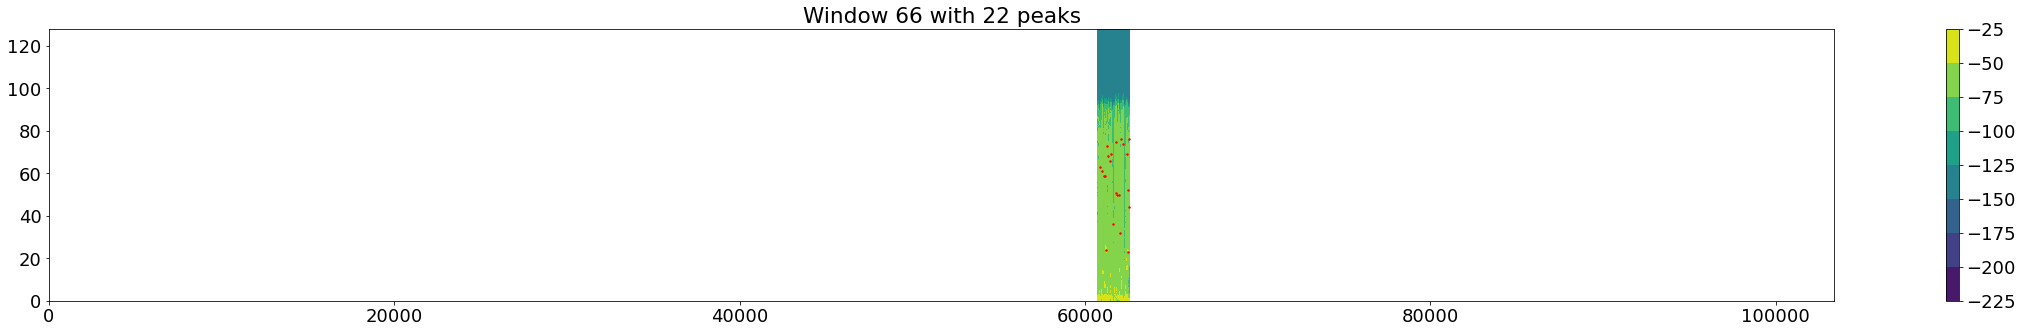

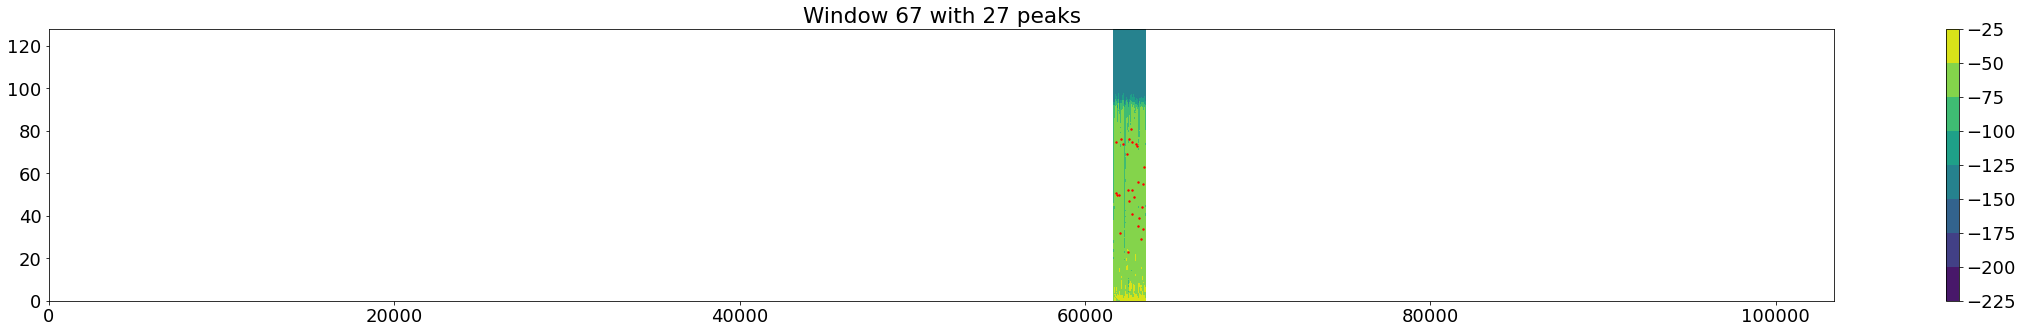

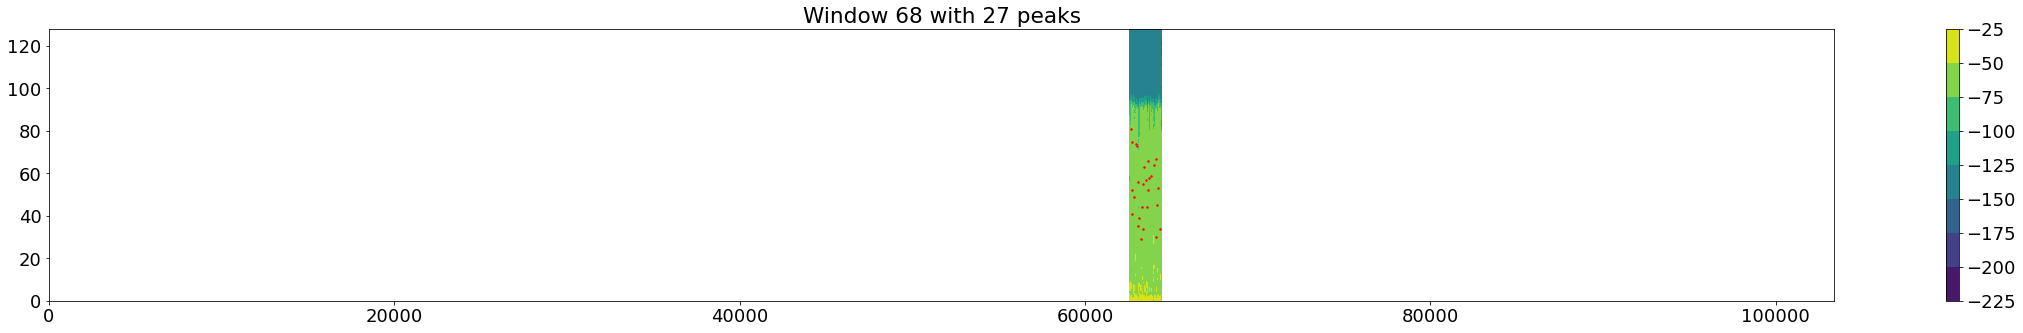

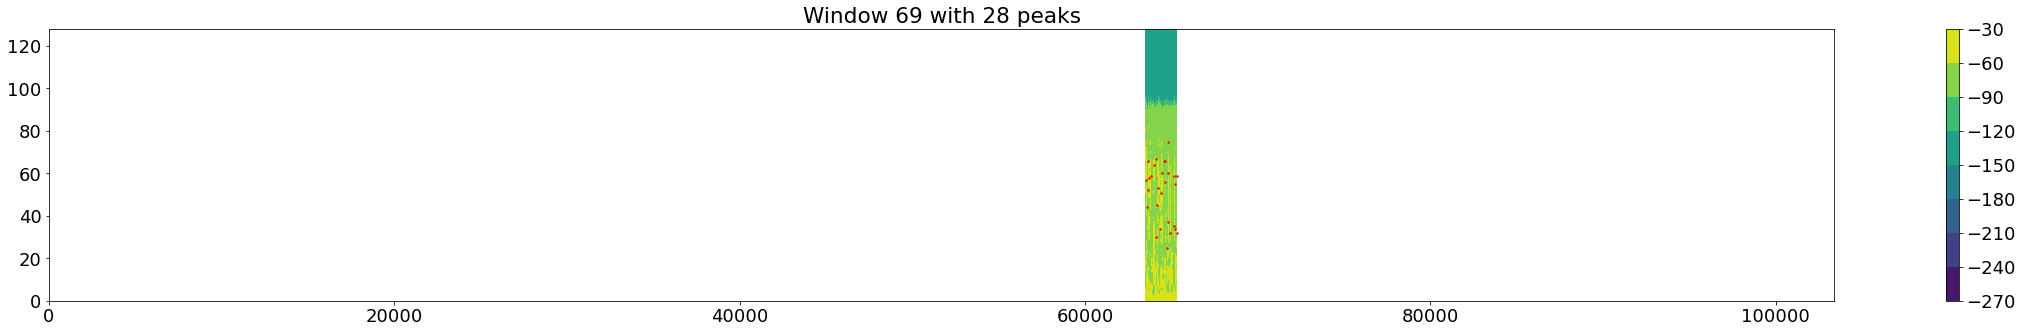

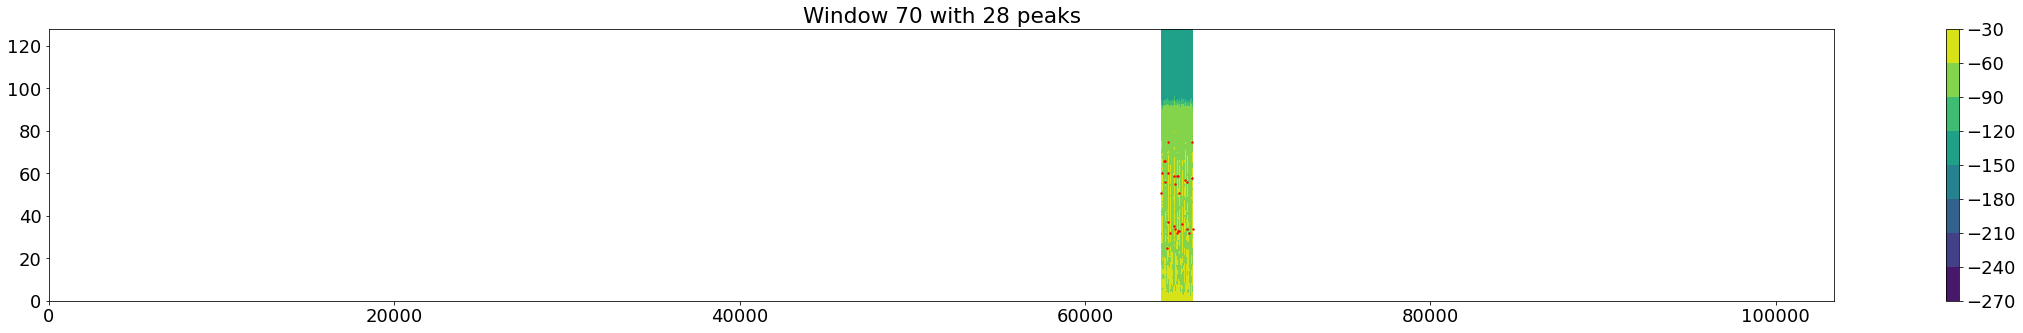

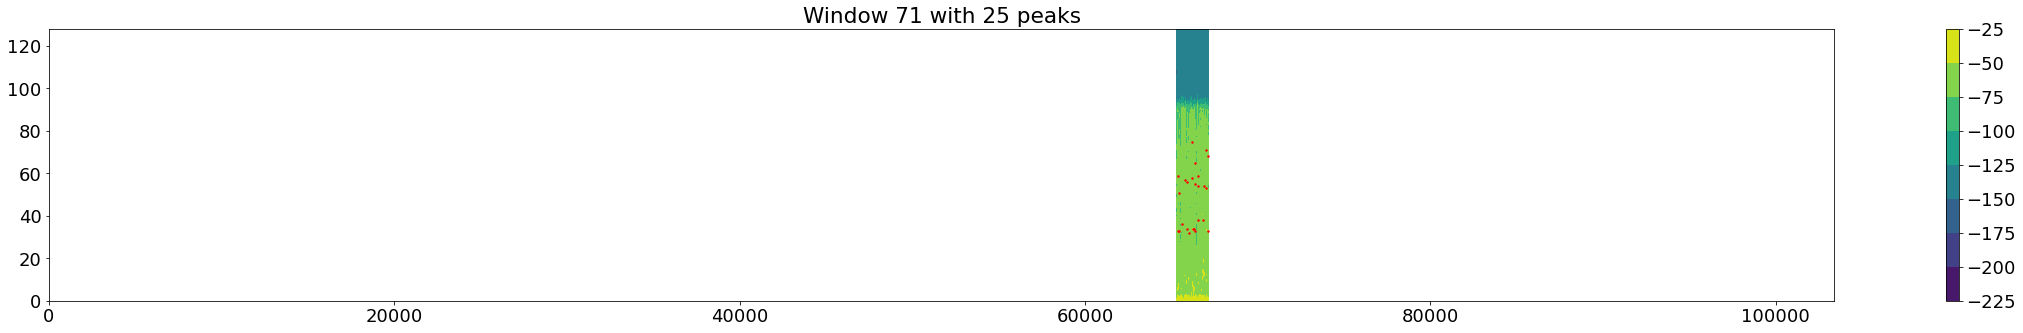

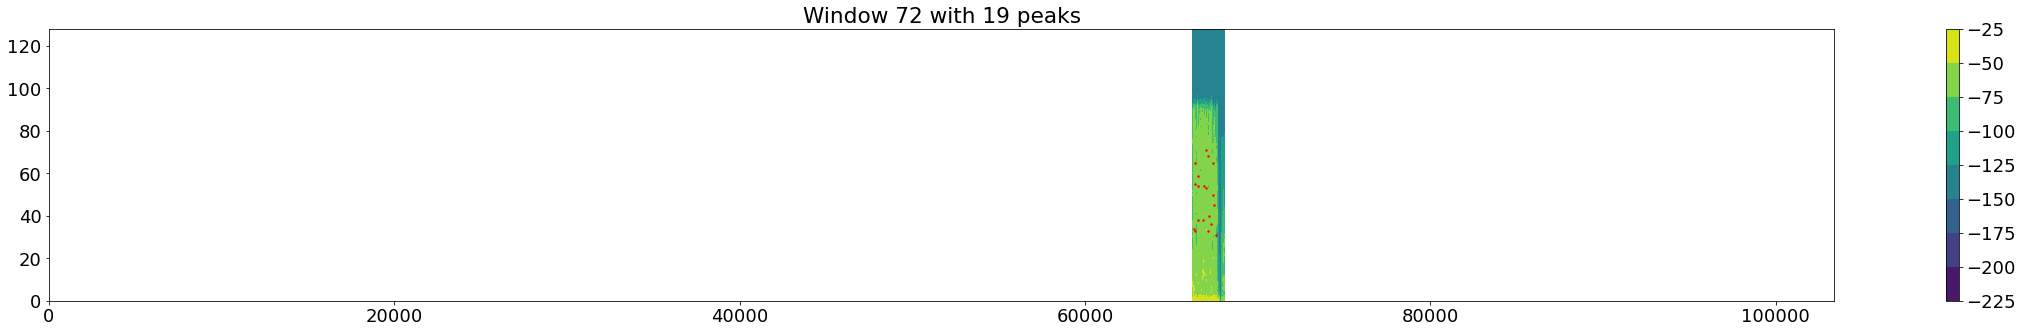

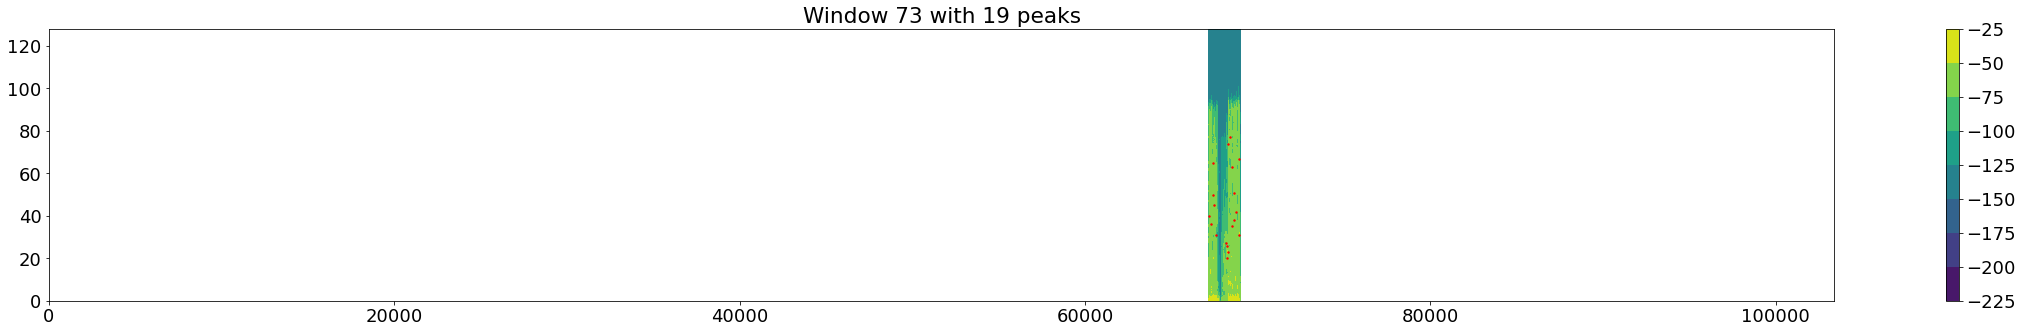

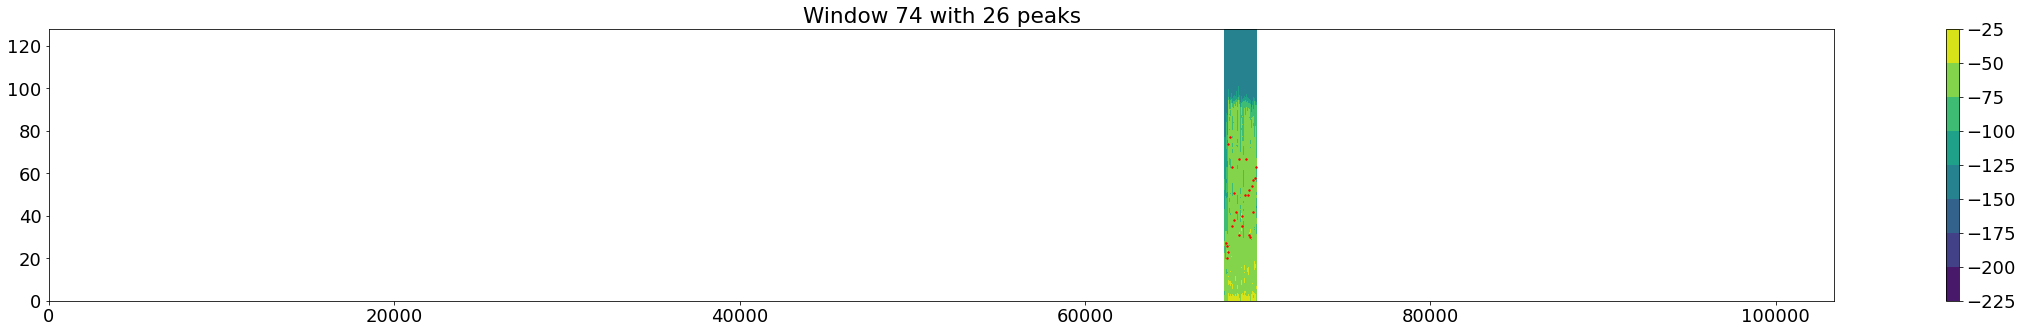

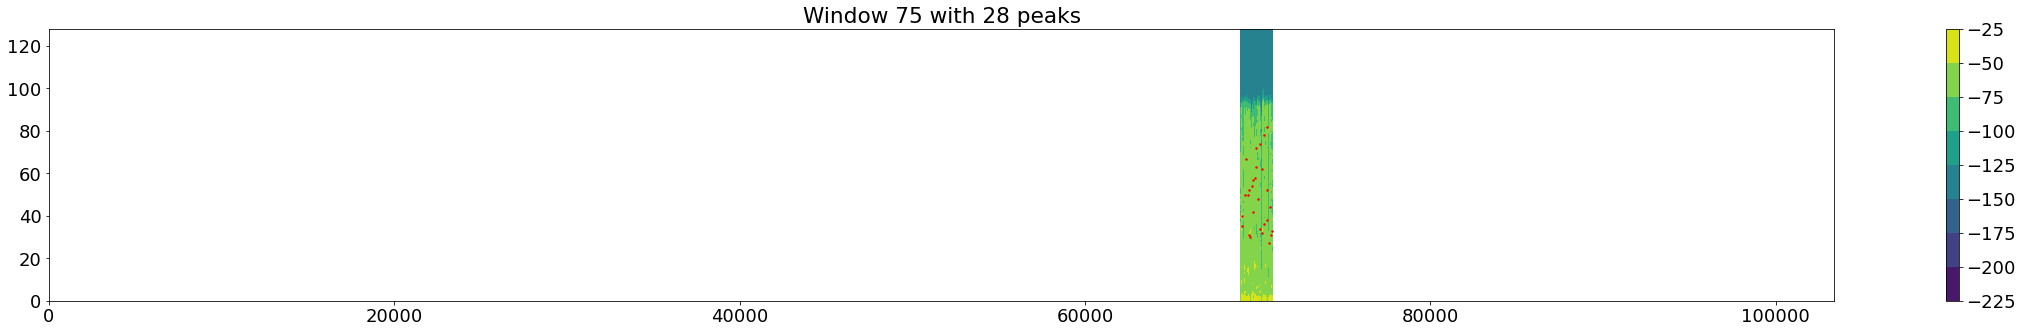

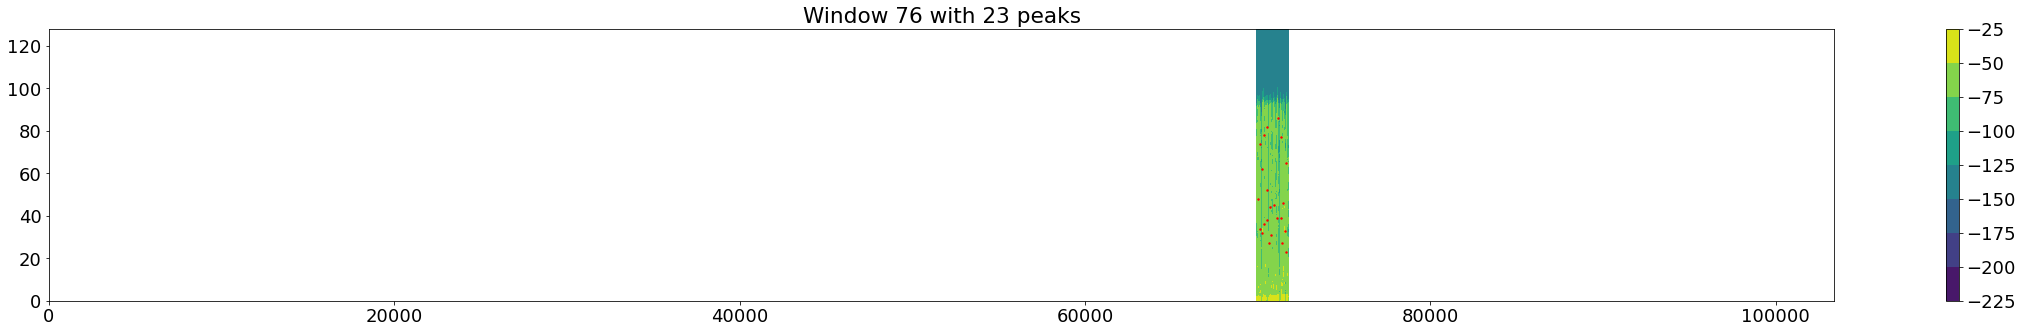

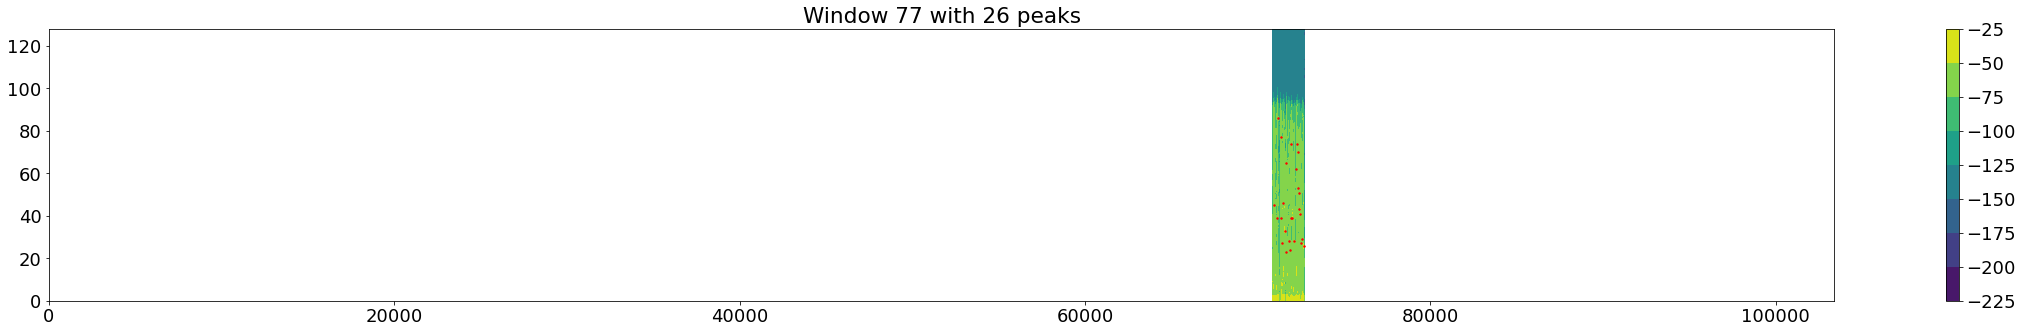

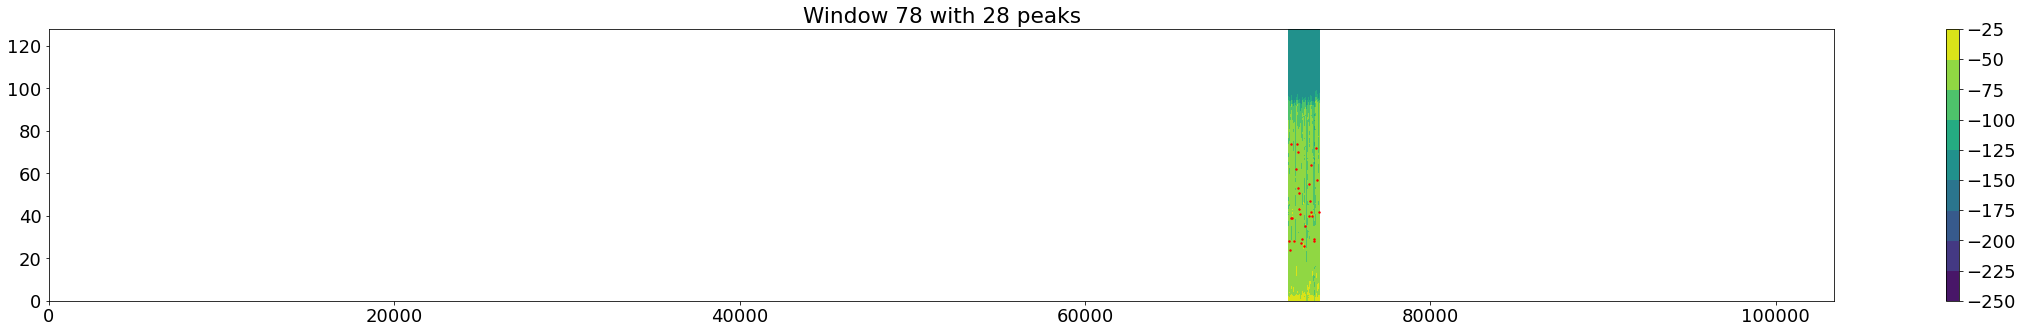

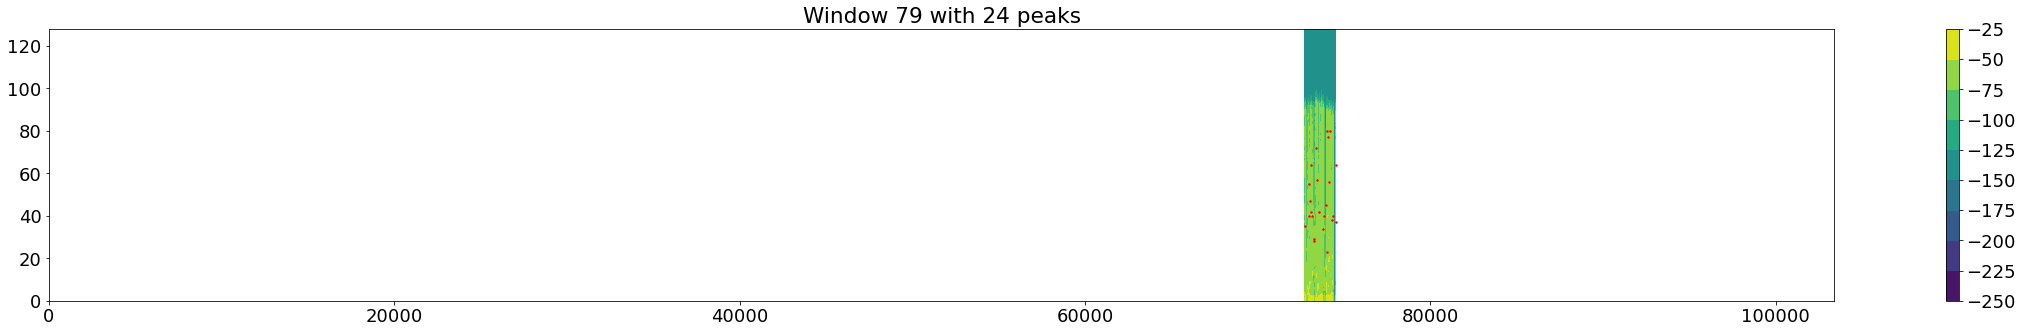

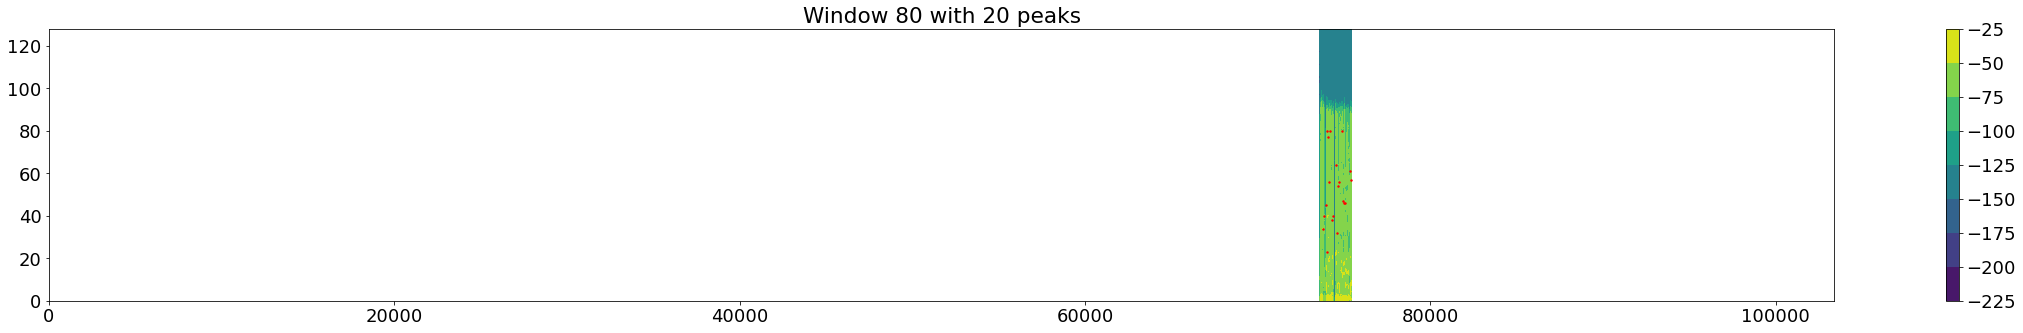

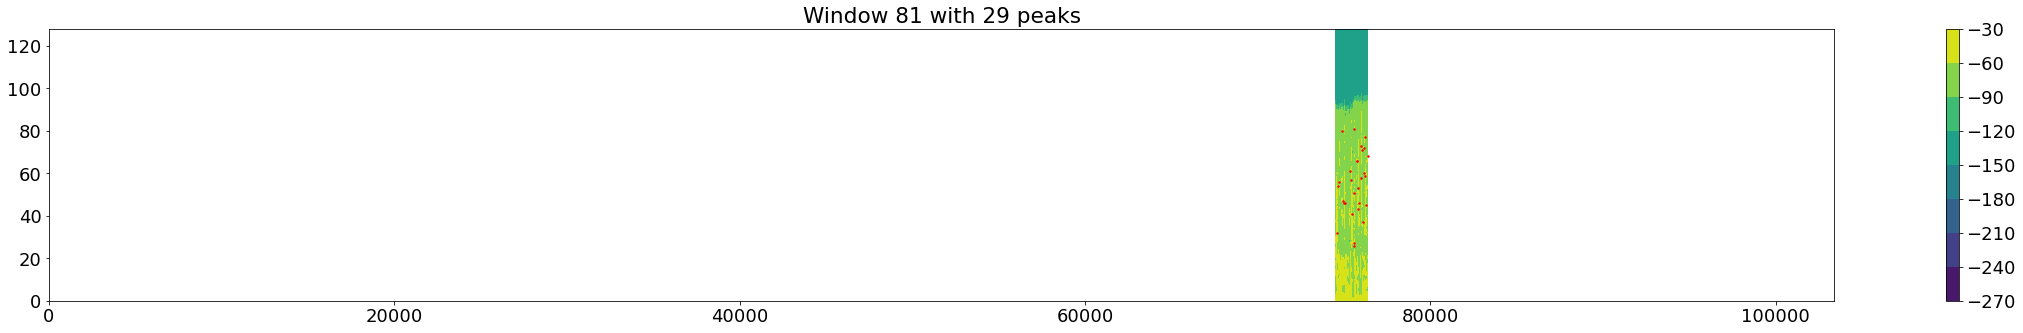

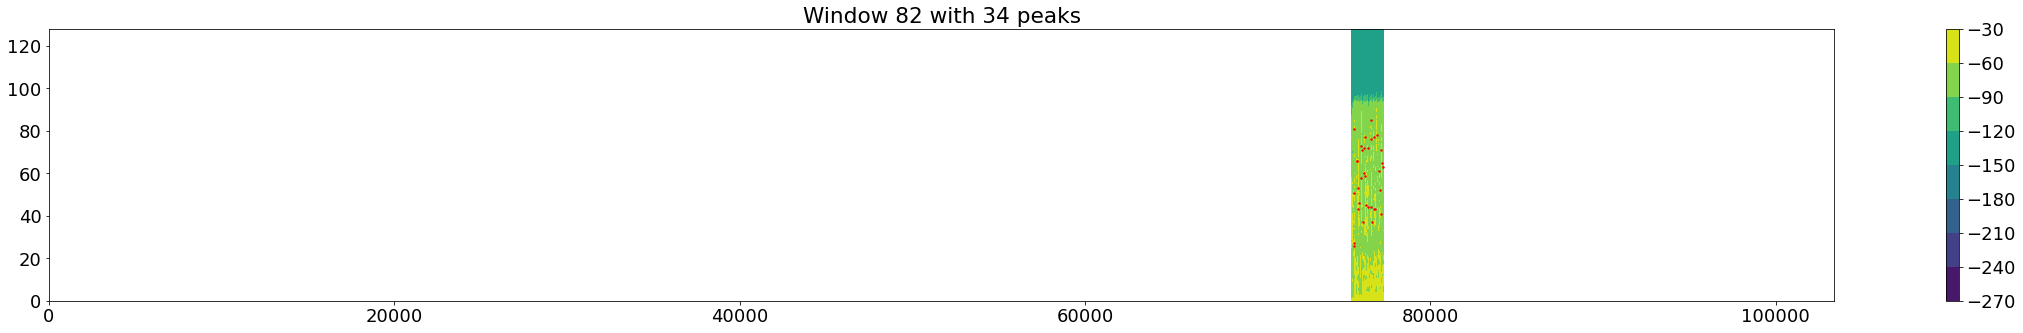

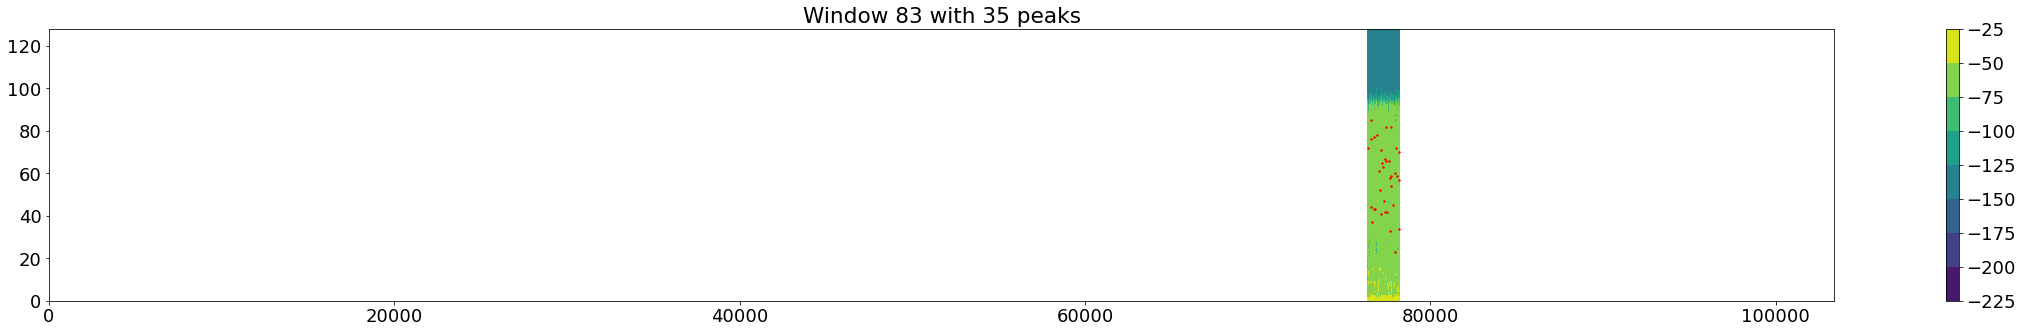

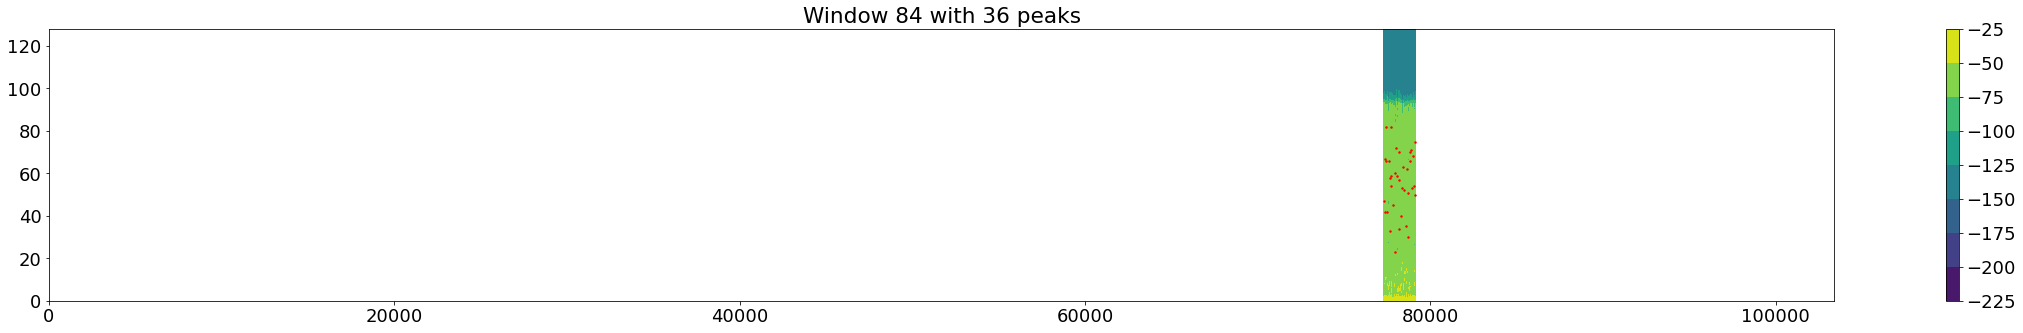

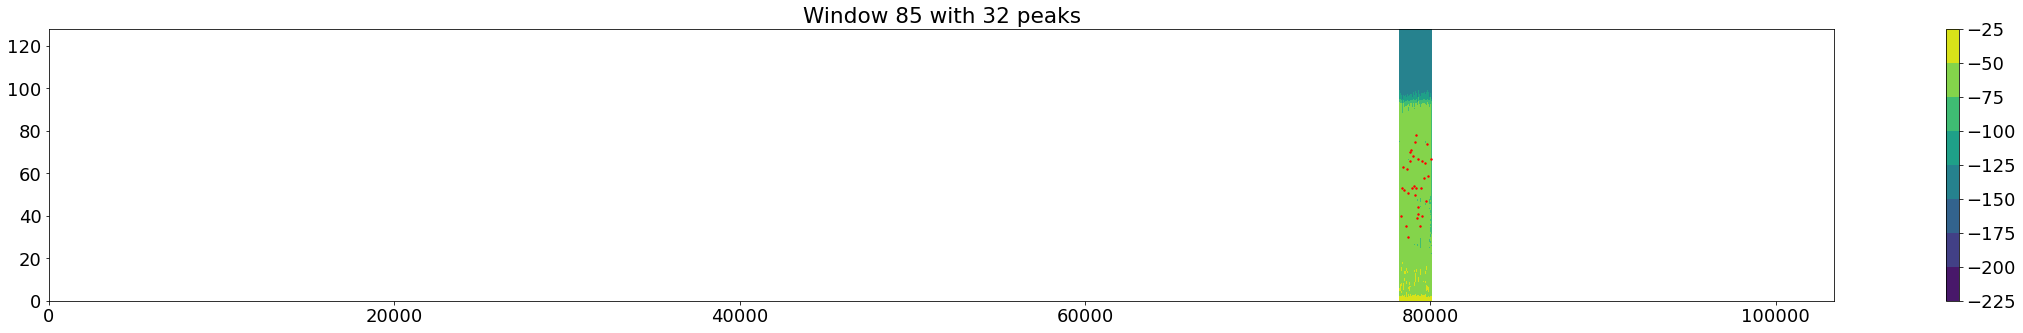

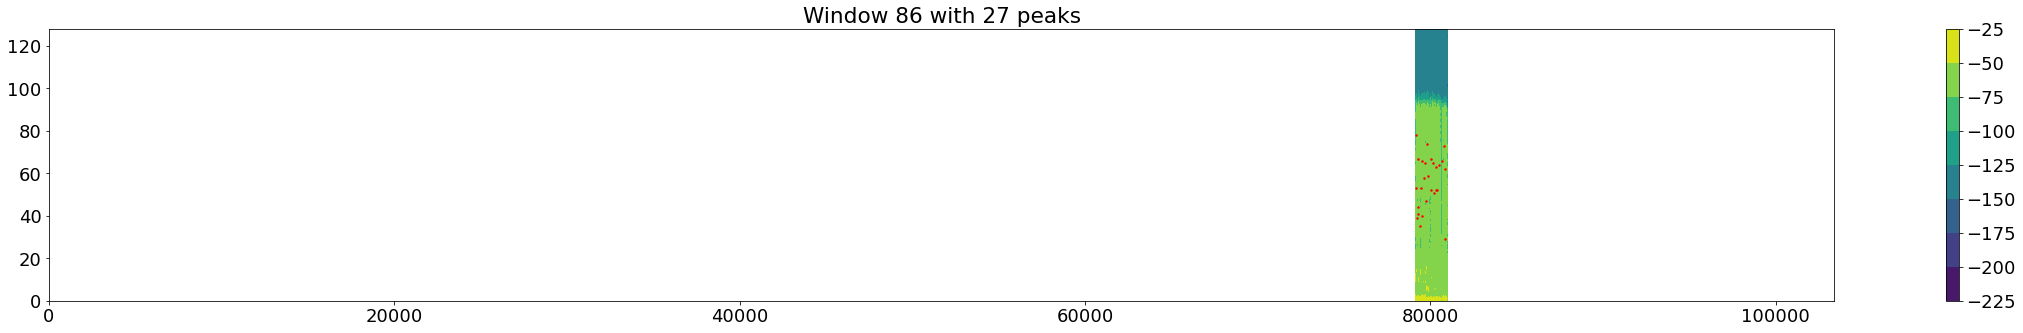

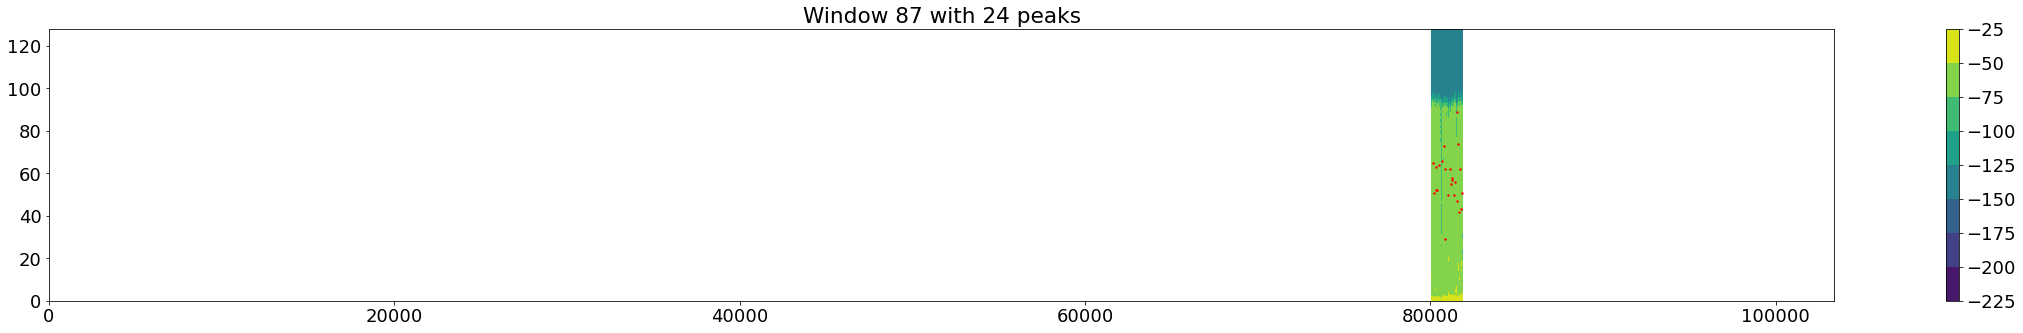

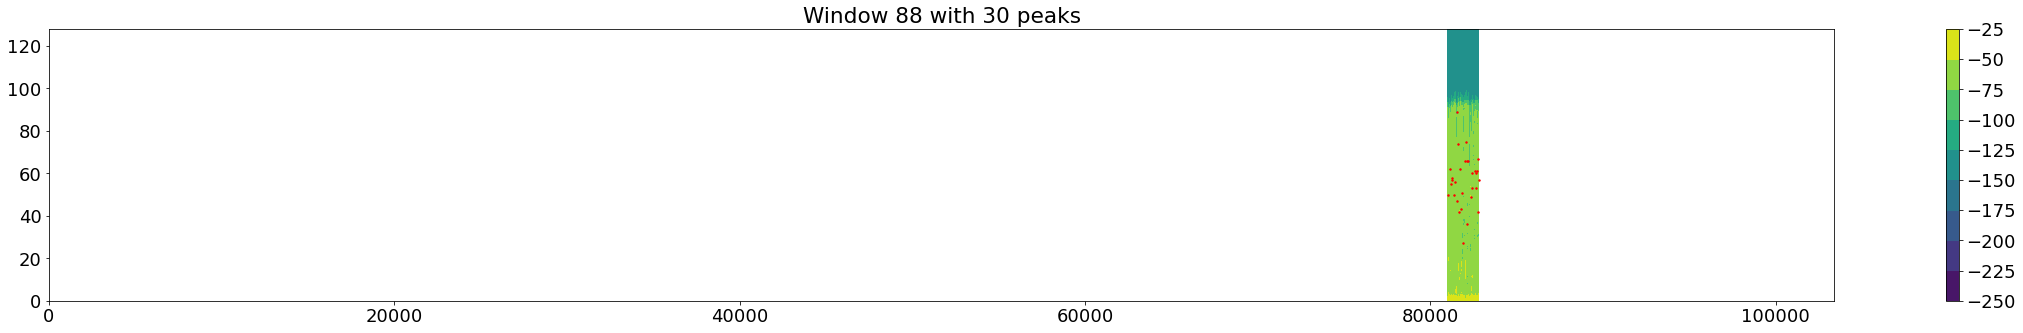

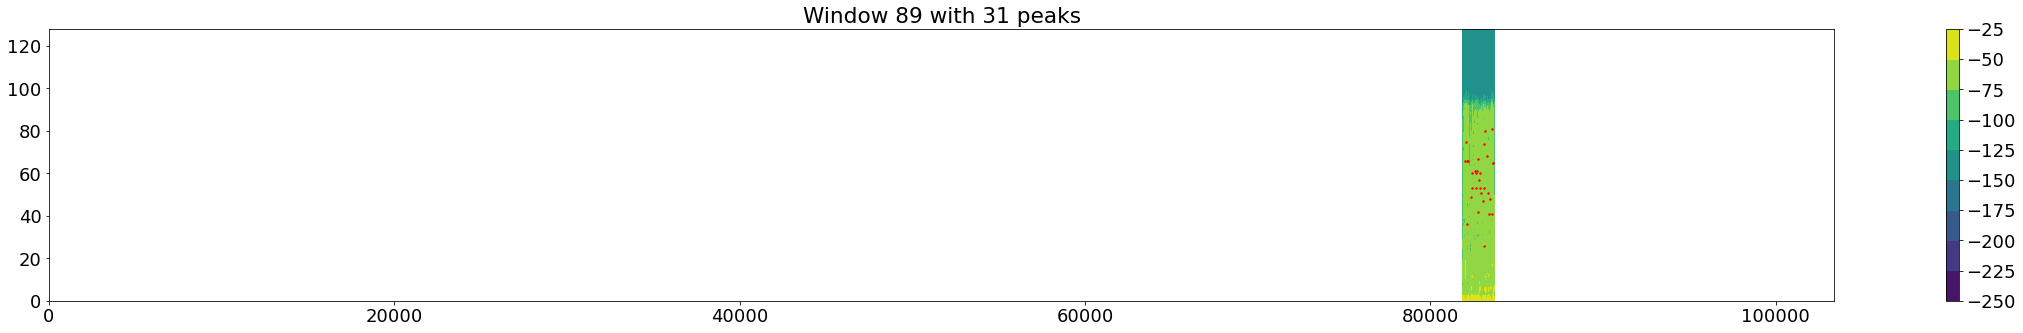

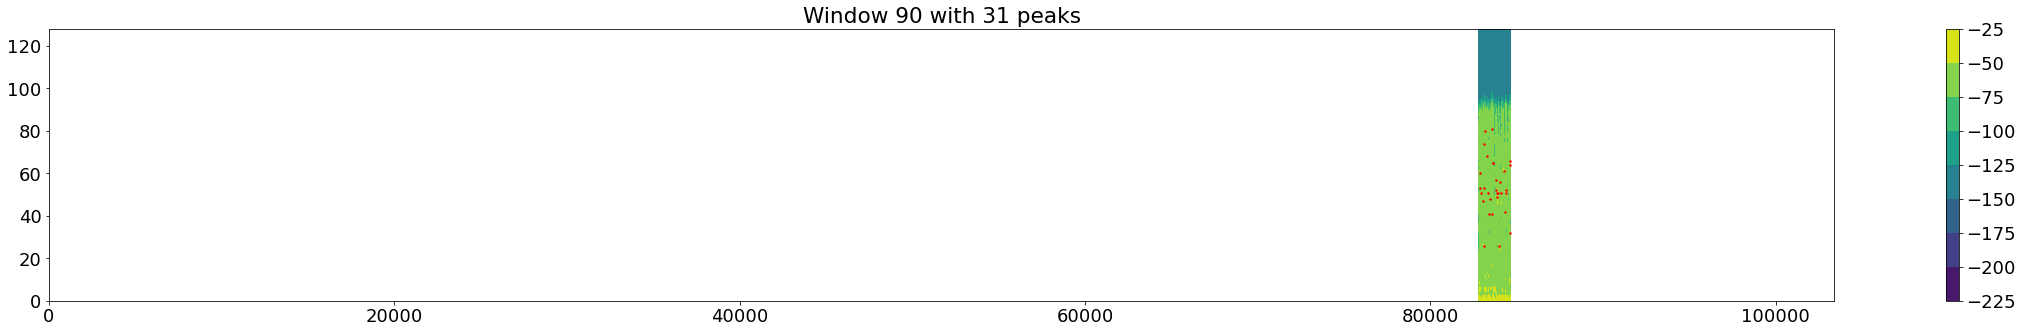

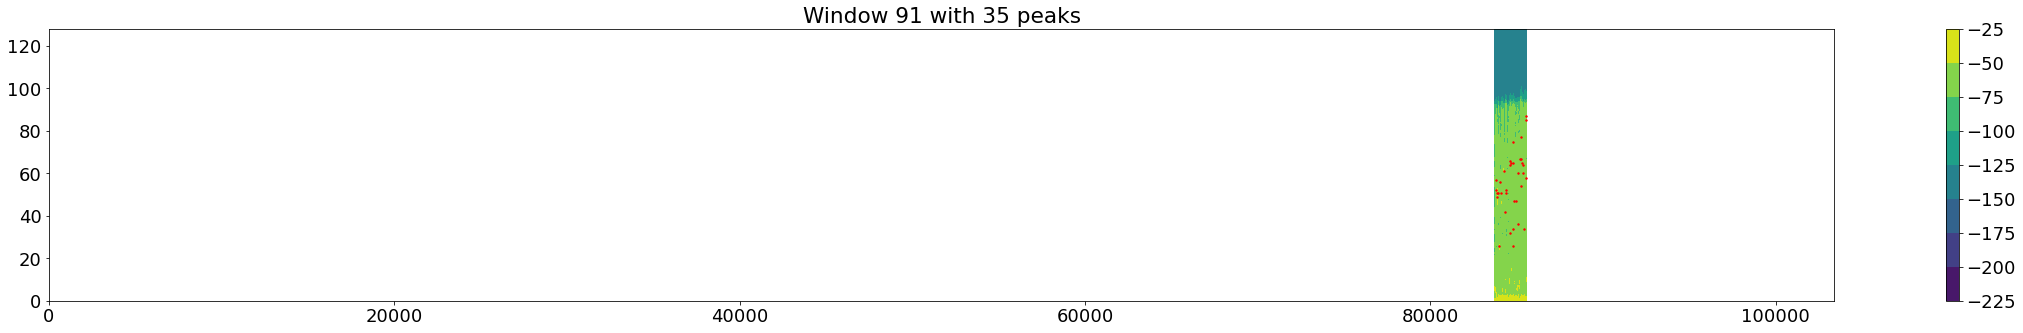

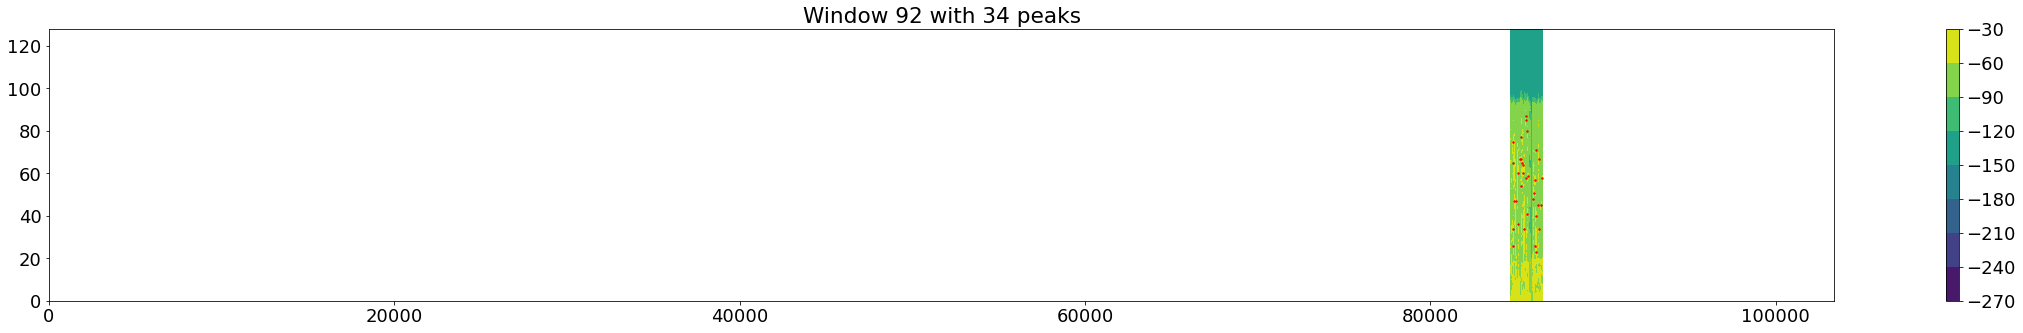

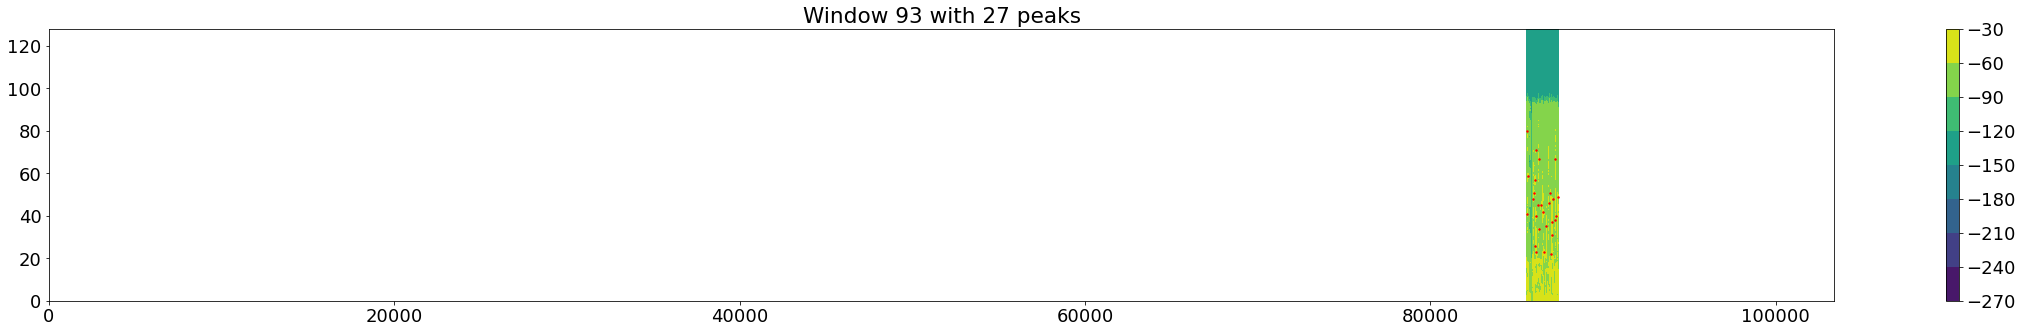

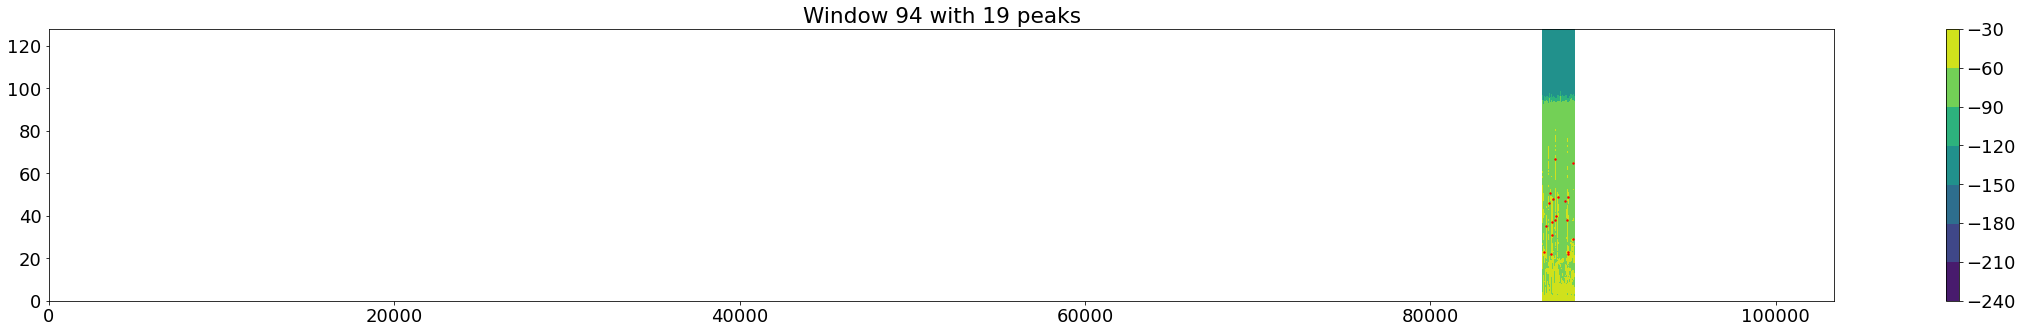

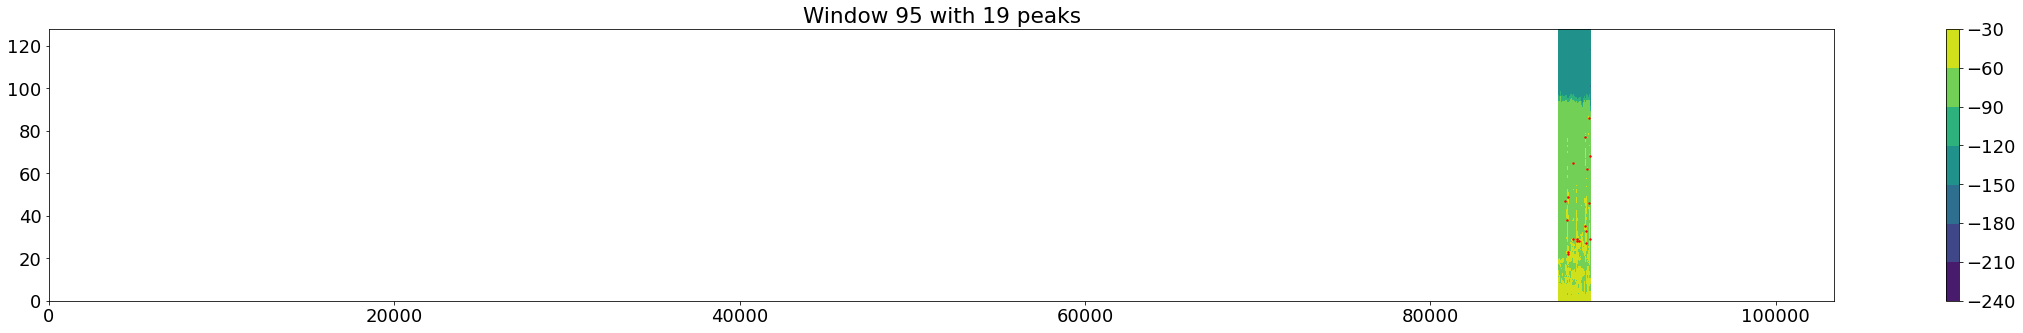

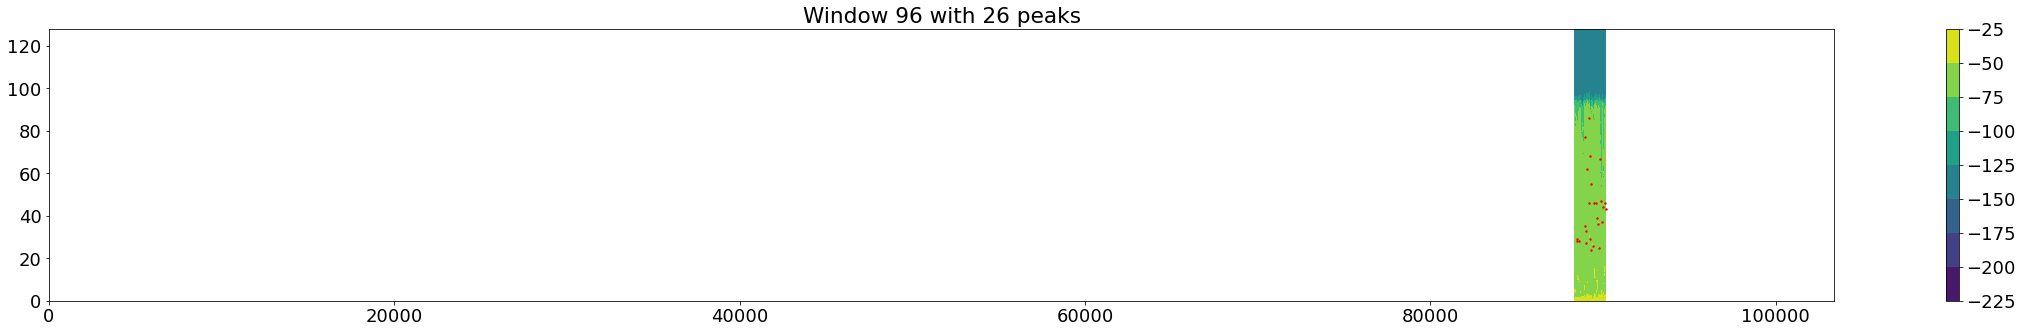

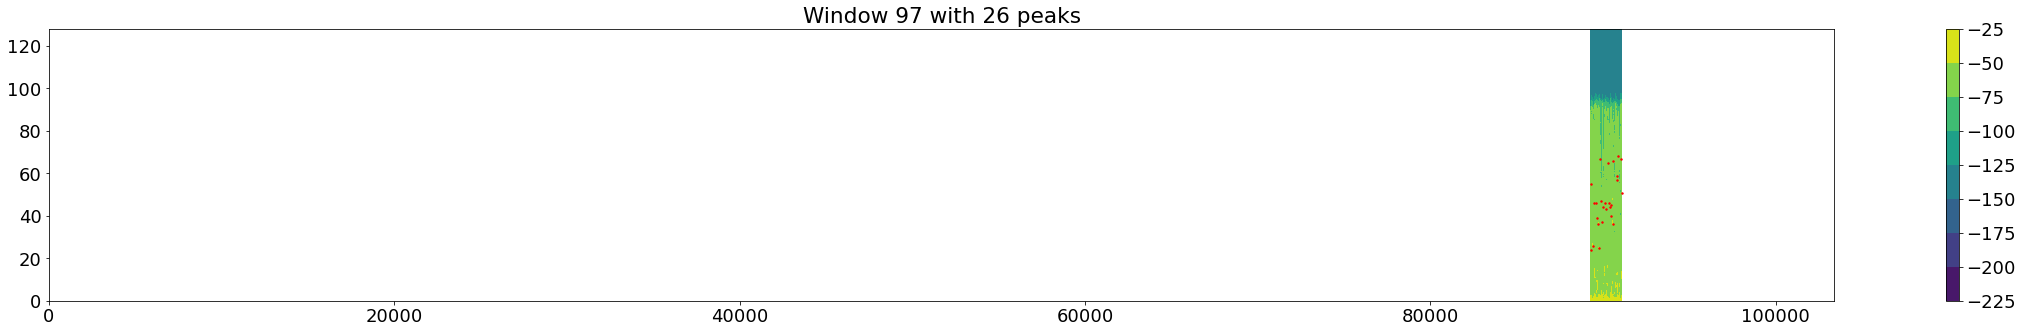

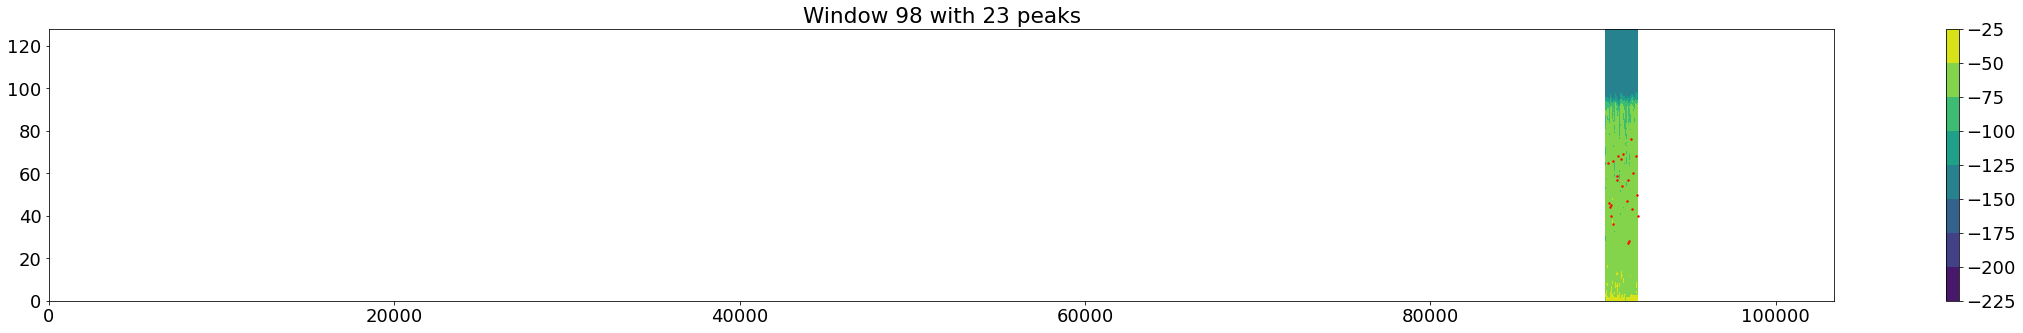

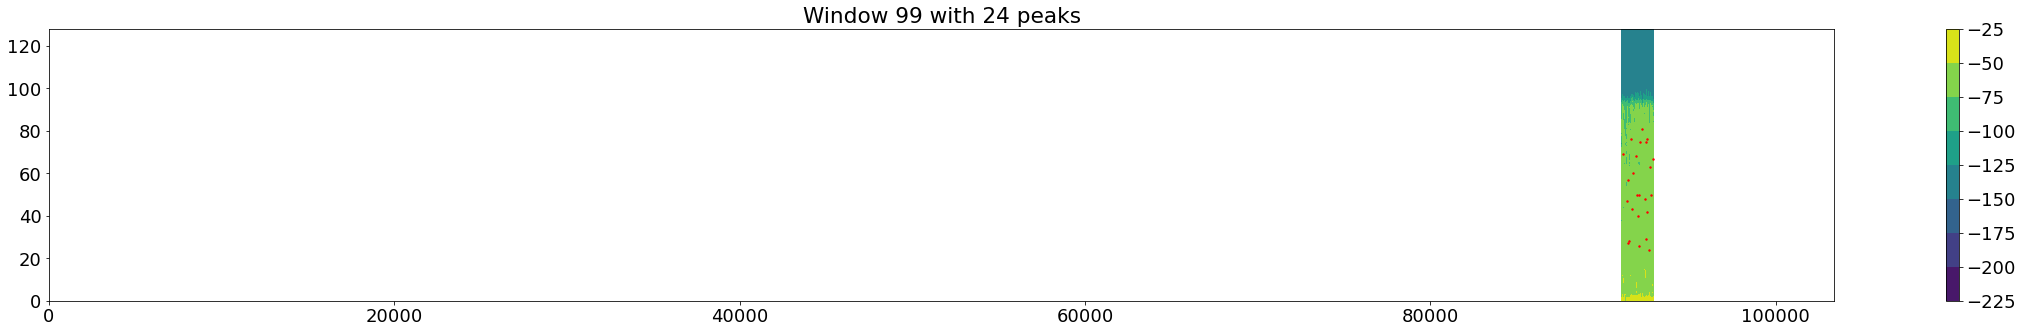

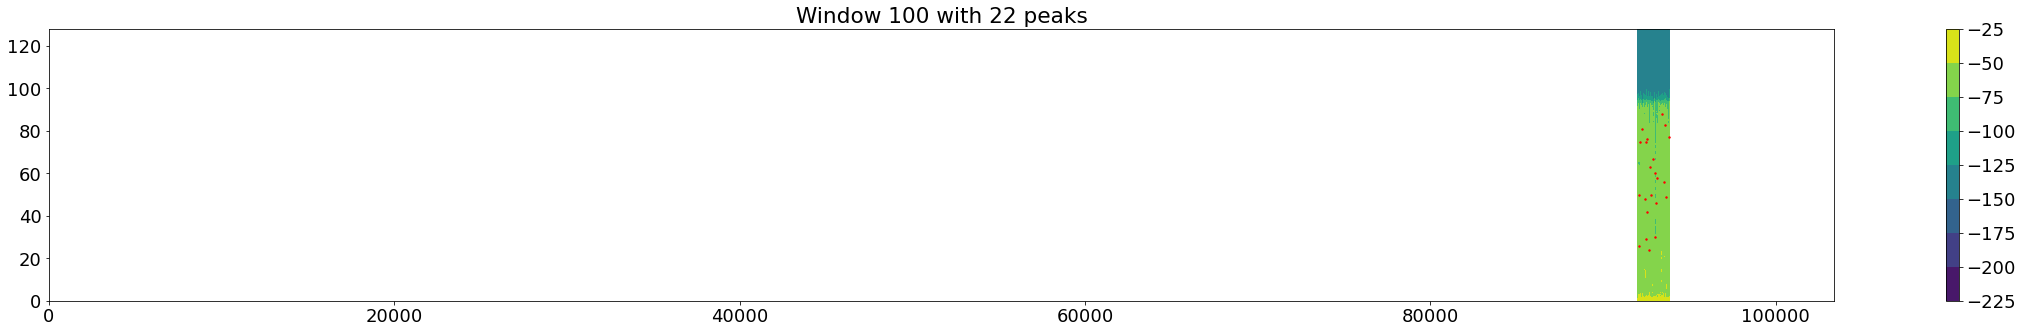

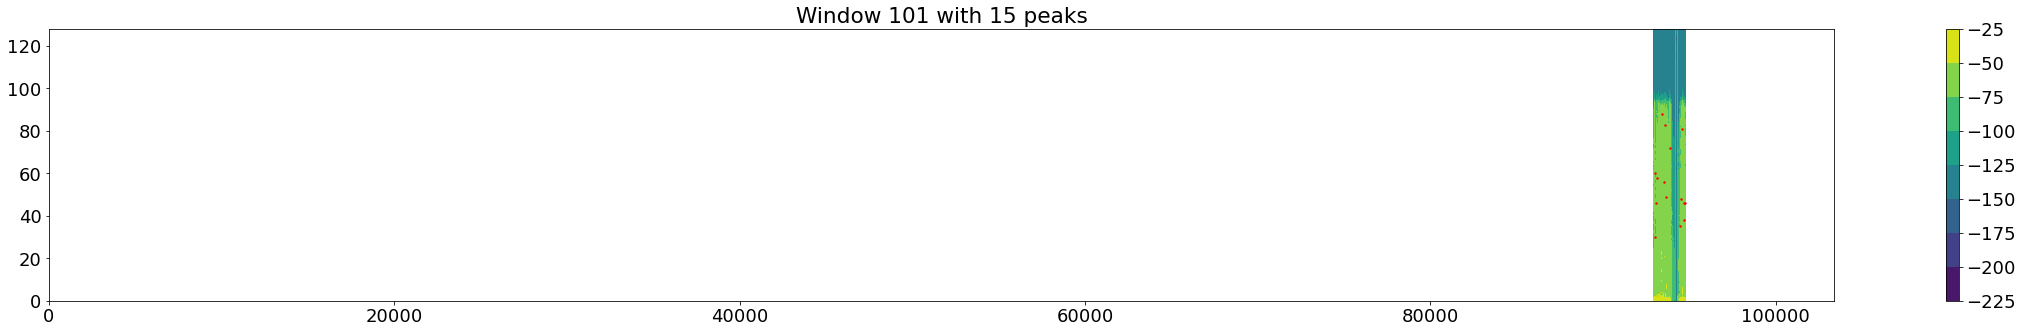

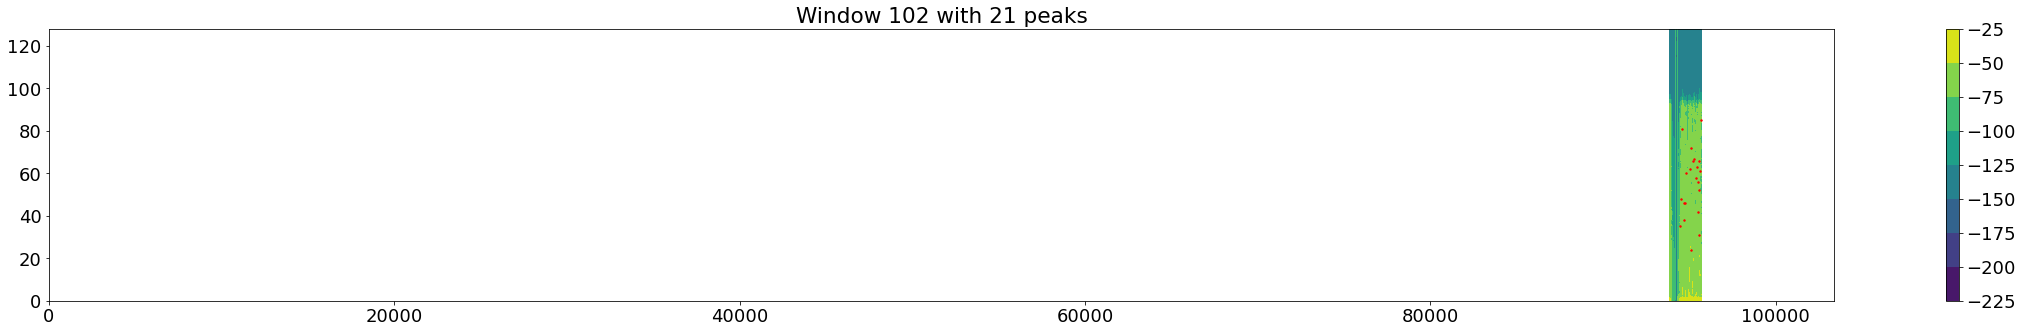

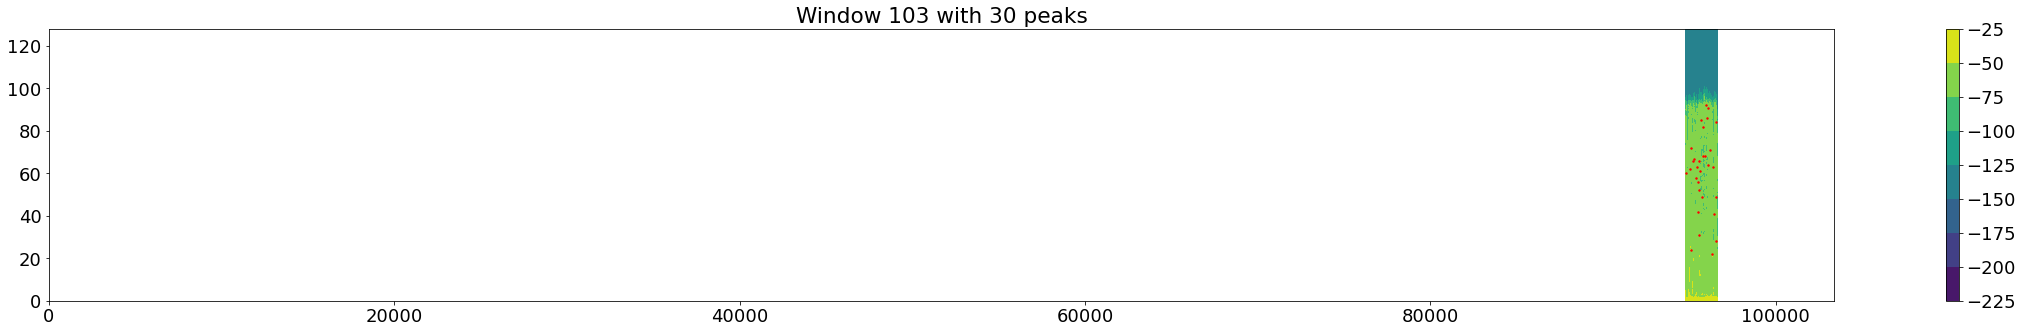

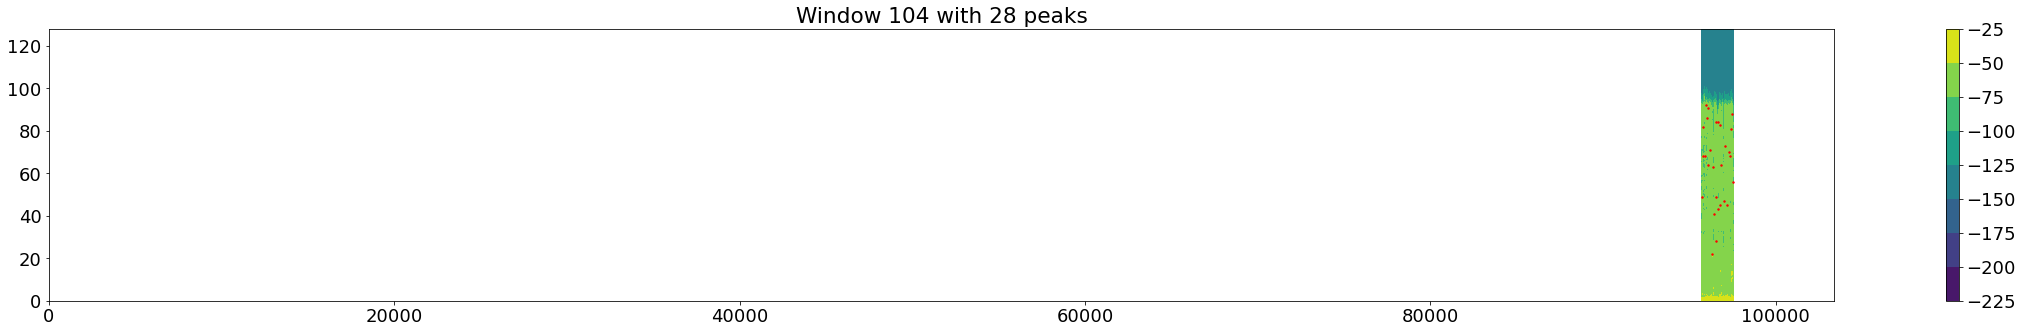

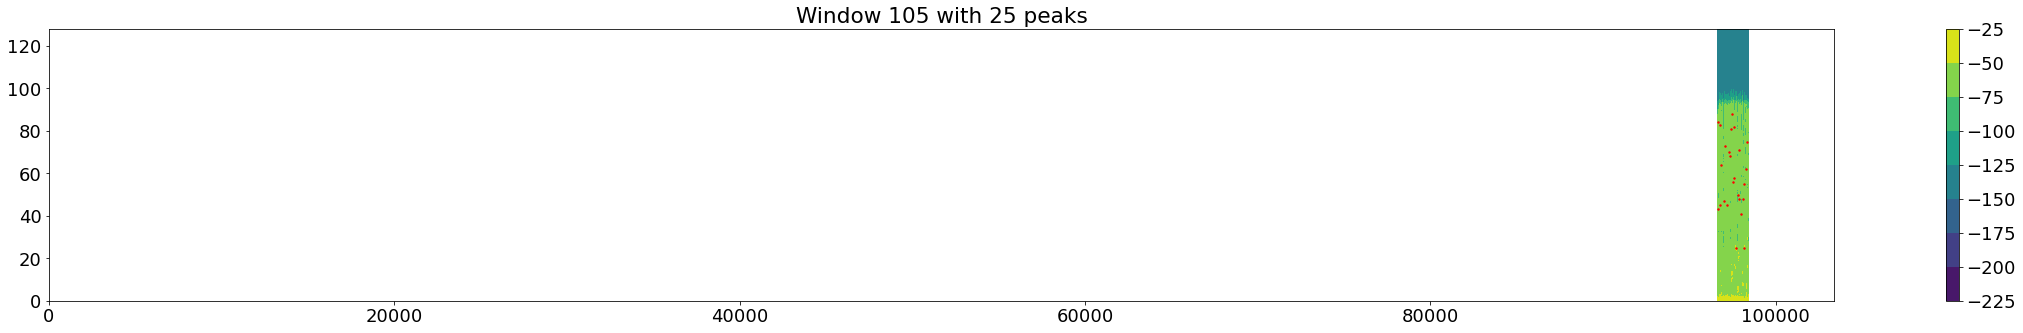

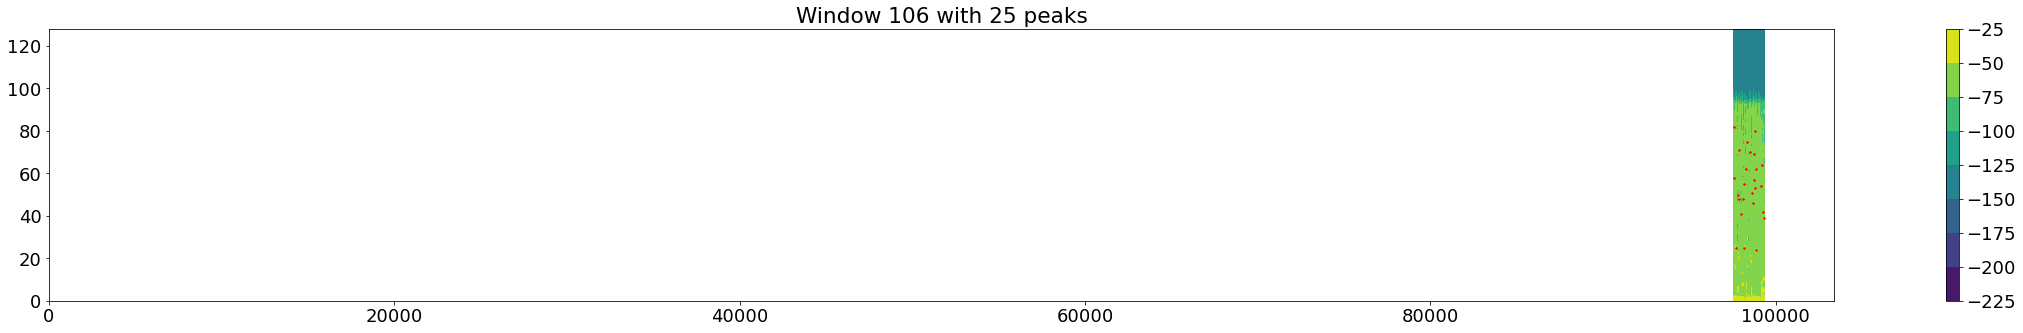

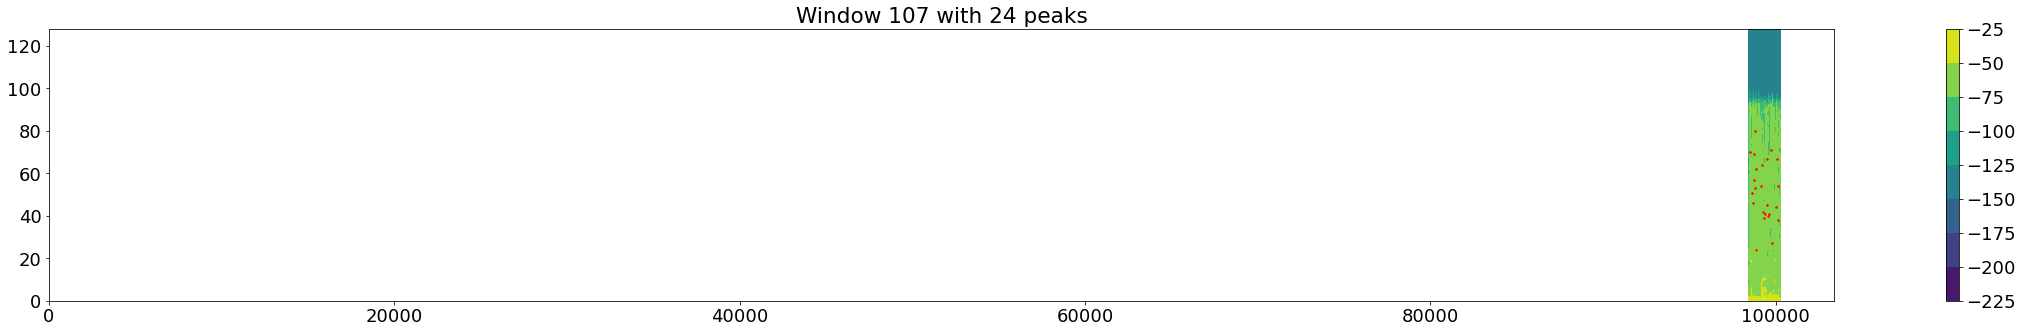

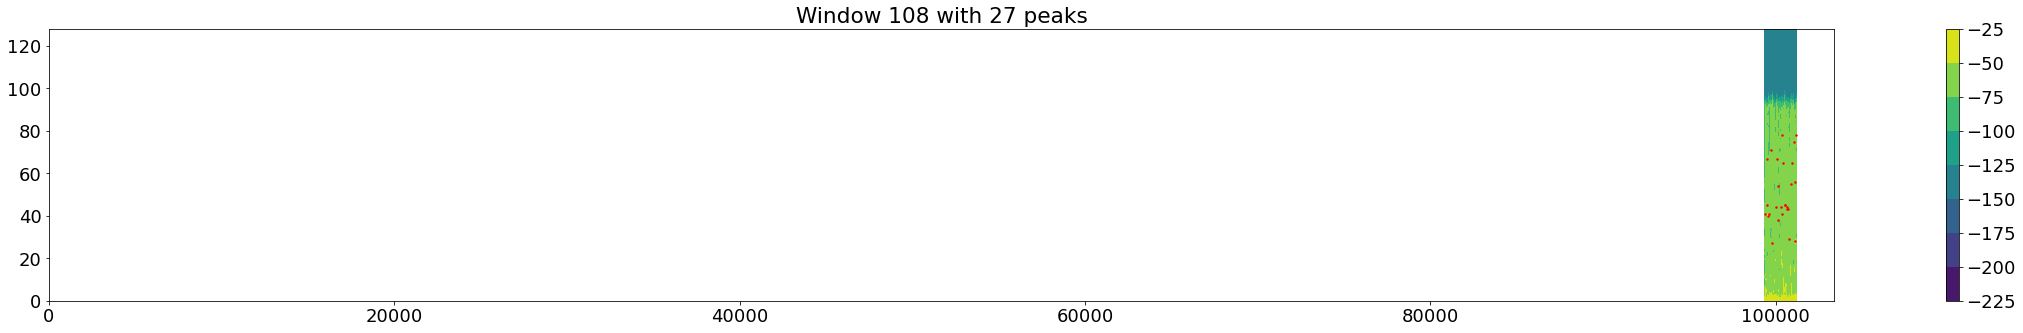

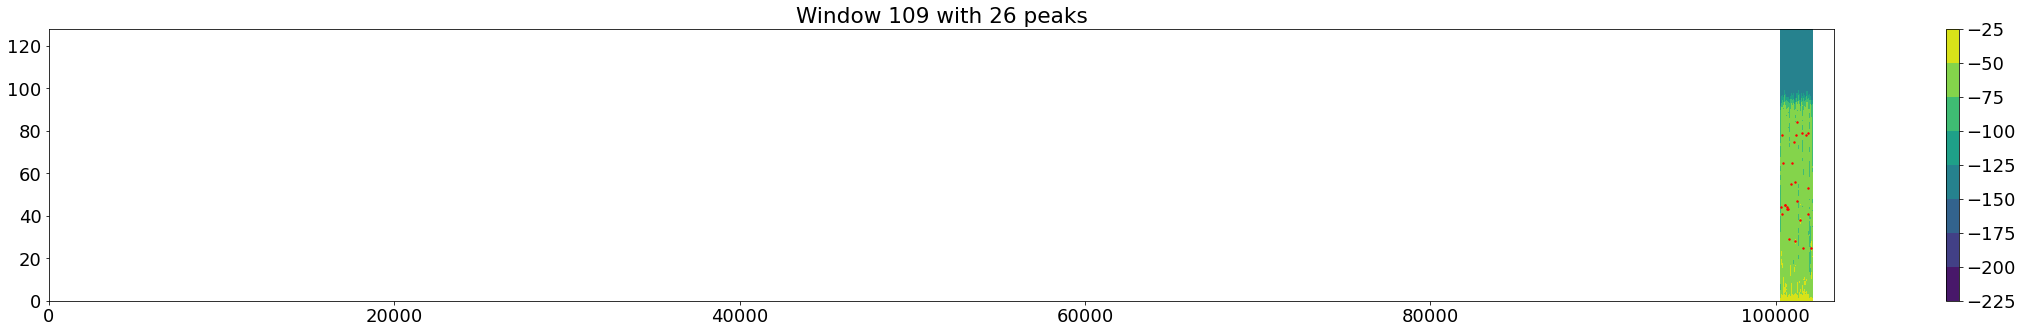

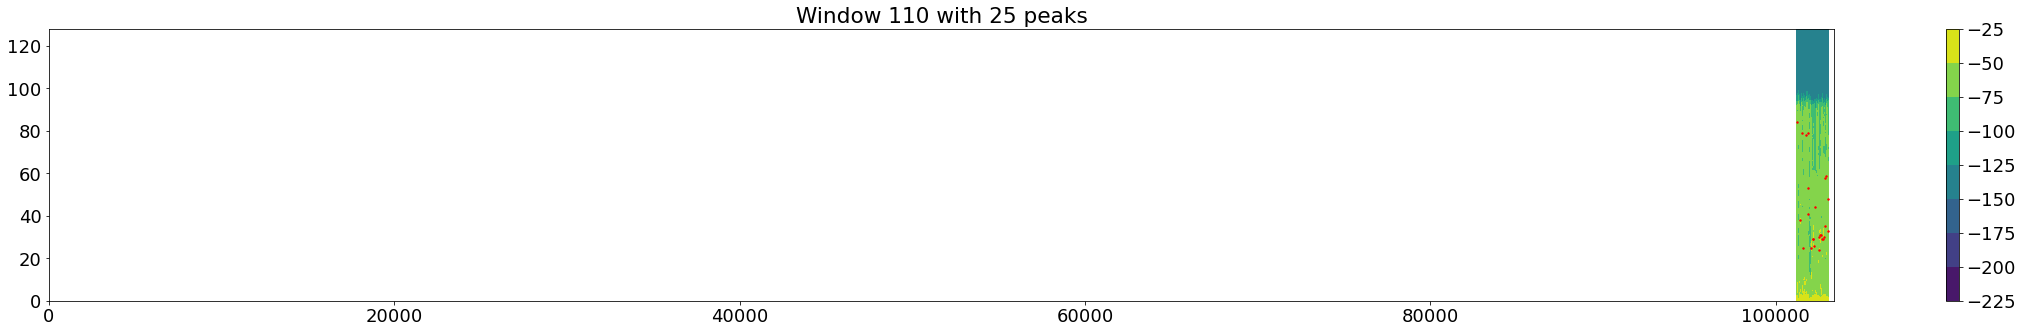

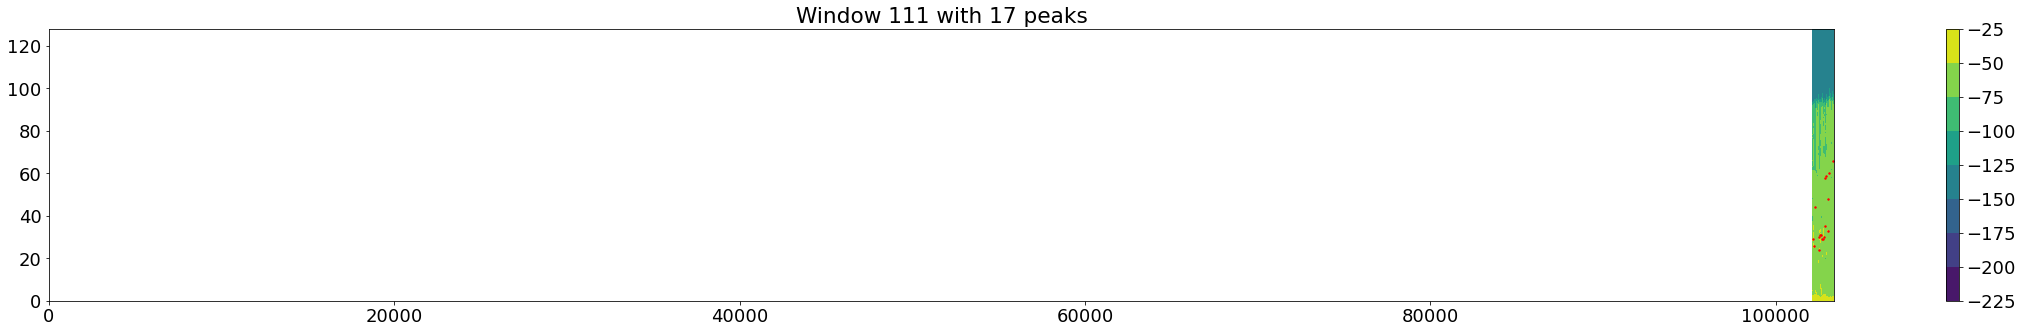

171
36
['0b101010001100010000000011001110', '0b101010010001010000000101100111', '0b101010001010000000000110101111', '0b101010001001100000000111110000', '0b101010001010100000001000101000', '0b101010001100110000001000111111', '0b101010001101010000001010111101', '0b101010001001110000001100000010', '0b110001010001010000000010011001', '0b110001001010000000000011100001', '0b110001001001100000000100100010', '0b110001001010100000000101011010', '0b110001001100110000000101110001', '0b110001001101010000000111101111', '0b110001001001110000001000110100', '0b1000101001010000000000001001000', '0b1000101001001100000000010001001', '0b1000101001010100000000011000001', '0b1000101001100110000000011011000', '0b1000101001101010000000101010110', '0b1000101001001110000000110011011', '0b101000001001100000000001000001', '0b101000001010100000000001111001', '0b101000001100110000000010010000', '0b101000001101010000000100001110', '0b101000001001110000000101010011', '0b100110001010100000000000111000', '0b10011000110

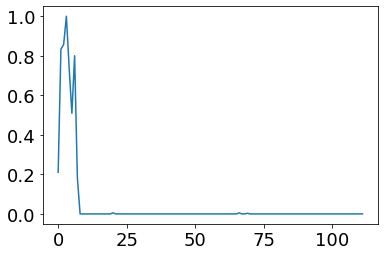

In [91]:
plt.plot(check_matches(ALDI_hash, full_spec_dB, freq, full_t, window_length=1840, min_distance=20, threshold_abs=-60))

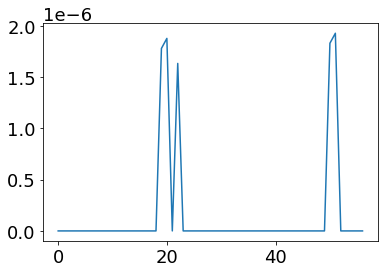

In [161]:
plt.plot(check_matches(ALDI_hash, full_spec_dB, freq, full_t, window_length=230, min_distance=5, threshold_abs=-80))

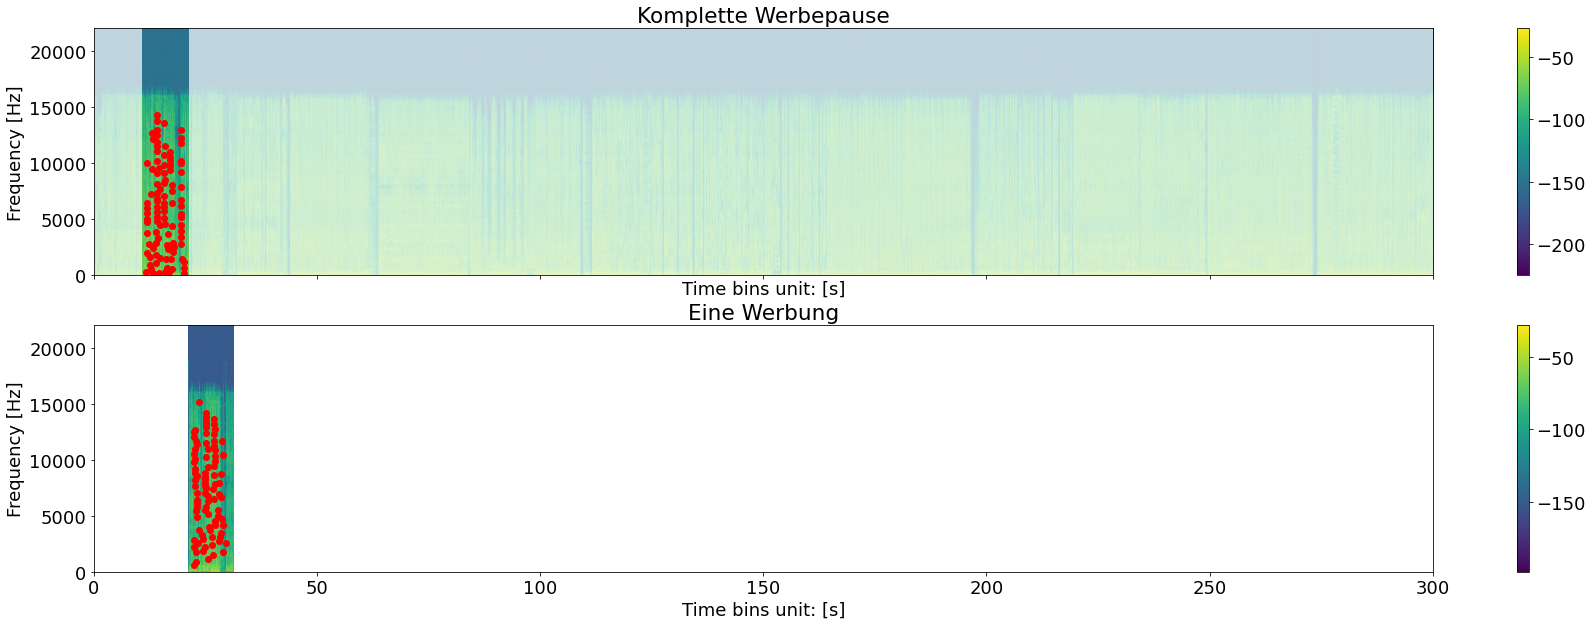

In [29]:
window_start = 230
window_length = 230
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 10), facecolor='white', sharex=True, sharey=True)
ax = axes.ravel()

# Plot the complete spectrum
im0 = ax[0].imshow(np.flipud(full_spec_dB), cmap='viridis', extent=(0, np.amax(full_t), freq[0], freq[-1]))
# Add some white shading
ax[0].broken_barh([(0, full_t[window_start]), (full_t[window_start + window_length], full_t[-1] - full_t[window_start + window_length])], (freq[0], freq[-1]), facecolors='w', alpha=.7)
# Obtain and plot the coordinates in the non-shaeded area.
freq_coords, time_coords = identify_peaks(full_spec_dB[:, window_start : window_start + window_length + 1], min_distance=20, threshold_abs=-60)
ax[0].scatter(full_t[time_coords + window_start], freq[freq_coords], color='r')

ax[0].set_xlabel('Time bins unit: [s]')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('Komplette Werbepause')
ax[0].axis('auto')
plt.colorbar(mappable=im0, ax=ax[0])

im1 = ax[1].imshow(np.flipud(ALDI_spec_dB), cmap='viridis', extent=(full_t[452], full_t[452 + ALDI_spec_dB.shape[1]], freq[0], freq[-1]))
# Obtain and plot the coordinates in the peaks
freq_coords, time_coords = identify_peaks(ALDI_spec_dB, min_distance=20, threshold_abs=-60)
ax[1].scatter(full_t[time_coords + 452], freq[freq_coords], color='r')
ax[1].set_xlabel('Time bins unit: [s]')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('Eine Werbung')
ax[1].axis('auto')
plt.colorbar(mappable=im1, ax=ax[1])

plt.show()